# Conditional variational autoencoder (using the VAE class)

# SETUP

In [1]:
!python --version


Python 3.6.7


# CVAE

generative process

2dimention data

c=f(ut,s(t-1))

st~p(st|ut, s(t-1))=N(c , sigma)

ot~p(ot|st)=N(st,sigma)

それぞれの分散共分散行列には対角行列を使用（制御がめんどそうだから

In [86]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tensorboardX import SummaryWriter
import numpy as np

from tqdm import tqdm

batch_size = 128
epochs =400#10
seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [87]:
root = '../data'
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambd=lambda o: o.view(-1))])
kwargs = {'batch_size': batch_size, 'num_workers': 1, 'pin_memory': True}

# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST(root=root, train=True, transform=transform, download=True),
#     shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST(root=root, train=False, transform=transform),
#     shuffle=False, **kwargs)

In [88]:
from pixyz.distributions import Normal, Bernoulli
from pixyz.losses import KullbackLeibler
from pixyz.models import VAE

In [89]:
#function for generate data
import torch.distributions as dist

def origin_datagenerator(sample_num,dsigma,axis):
  ca_axis=[-3,-2]
  cb_axis=[3,3]
  cc_axis=[7,5]
  
  data_cso={}
  
  ones=torch.ones(int(sample_num/3))
  
  sample_ca = torch.stack([ones*axis[0][0],ones*axis[0][1]],1)
  sample_cb = torch.stack([ones*axis[1][0],ones*axis[1][1]],1)
  sample_cc = torch.stack([ones*axis[2][0],ones*axis[2][1]],1)
  data_cso.update({"c":torch.cat([sample_ca,sample_cb,sample_cc],dim=0)})
  data_cso.update({"s":dist.Normal(data_cso["c"],dsigma).sample()})
  data_cso.update({"o":dist.Normal(data_cso["s"],dsigma).sample()})
#   data_cso.update([ ("c",torch.cat([sample_ca,sample_cb,sample_cc],dim=0)), ("s",dist.Normal(data_cso["c"],dsigma).sample()) ])
  
  return data_cso
  
#
def unique_datagenerator(sample_num,dsigma,u_fragx,u_fragy):
    data_cso={}
    
    #st-1
    sample_sx=torch.rand(sample_num)*200-100#-100~100の範囲で一様分布#一旦0~100
    sample_sy=torch.rand(sample_num)*200-100
    st1=torch.cat([sample_sx.view(sample_num,1),sample_sy.view(sample_num,1)],dim=1)
    print(st1)
    
    if u_fragx == 0.0 and u_fragy ==0.0:
        #ut
        sample_ux=torch.rand(sample_num)*20-10#移動距離は-10~10
        sample_uy=torch.rand(sample_num)*20-10
        ut=torch.cat([sample_ux.view(sample_num,1),sample_uy.view(sample_num,1)],dim=1)
        print(ut)
    else:
        sample_ux=torch.ones(sample_num)*u_fragx#移動距離は-10~10
        sample_uy=torch.ones(sample_num)*u_fragy
        ut=torch.cat([sample_ux.view(sample_num,1),sample_uy.view(sample_num,1)],dim=1)
        print(ut)
        
    #その他
    sample_c=st1+ut

    print(sample_c)
    data_cso.update({"st1":st1})#t-1時刻の位置
    data_cso.update({"u":ut})#制御
    data_cso.update({"c":sample_c})#動作モデルを通したs(分散なし)
    data_cso.update({"s":dist.Normal(data_cso["c"],dsigma).sample()})#真の位置(分散を通している)
    data_cso.update({"o":dist.Normal(data_cso["s"],dsigma).sample()})#計測値（stと同じ位置だが，分散が載っている

    return data_cso

In [90]:
sample_num=3000
ssigma=torch.Tensor([0.5,0.5]*sample_num).view(sample_num,2)#状態遷移時の分散
osigma=torch.Tensor([0.5,0.5]*sample_num).view(sample_num,2)#計測情報の分散

axis=[[-3,-2],[3,3],[7,5]]#originalの場合の点の指定

max_data=100.0
min_data=-100.0

data=unique_datagenerator(sample_num,ssigma,0.0,0.0)
test_data=unique_datagenerator(sample_num,ssigma,0.0,0.0)

print(data)

train = torch.utils.data.TensorDataset(data["o"], data["c"])
train_loader = torch.utils.data.DataLoader(train, shuffle=False,**kwargs)
test = torch.utils.data.TensorDataset(test_data["o"], test_data["c"])
test_loader = torch.utils.data.DataLoader(test, shuffle=False,**kwargs)

tensor([[ 51.5263,  31.3168],
        [-44.1378,  -3.1747],
        [-19.3861,  75.2899],
        ...,
        [ 77.6884,  60.9761],
        [ 45.9967, -10.7347],
        [-63.1686, -80.5281]])
tensor([[-7.3585,  7.8155],
        [-2.0600, -6.5741],
        [-6.2988,  4.2397],
        ...,
        [ 4.5941, -4.9911],
        [-6.0039,  7.9783],
        [ 3.4886,  8.7453]])
tensor([[ 44.1679,  39.1323],
        [-46.1978,  -9.7489],
        [-25.6849,  79.5296],
        ...,
        [ 82.2825,  55.9850],
        [ 39.9928,  -2.7564],
        [-59.6800, -71.7828]])
tensor([[-99.2595,  87.1309],
        [ 86.3463,  -6.9568],
        [ 16.7784, -45.5382],
        ...,
        [  5.3470,  66.8863],
        [ 73.4186,  90.8019],
        [ -2.0553,  95.7045]])
tensor([[-2.0936, -6.2989],
        [ 1.2211,  5.2460],
        [-9.2955,  6.4088],
        ...,
        [ 3.0505,  9.0703],
        [-0.9756, -5.0563],
        [ 8.5588,  6.9065]])
tensor([[-101.3532,   80.8320],
        [  87.5674,   

In [91]:
o_dim = 2
c_dim = 2
s_dim = 2


# inference model q(z|x,y)
class Inference(Normal):
    def __init__(self):
        super(Inference, self).__init__(cond_var=["o","c"], var=["s"], name="q")

        self.fc1 = nn.Linear(o_dim+c_dim, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc31 = nn.Linear(4, s_dim)
        self.fc32 = nn.Linear(4, s_dim)

    def forward(self, o, c):
        h = F.relu(self.fc1( torch.cat([o,c],1) ))
        h = F.relu(self.fc2(h))        
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

    
# generative model p(x|z,y)    
class Generator(Bernoulli):
    def __init__(self):
        super(Generator, self).__init__(cond_var=["s"], var=["o"], name="p")

        self.fc1 = nn.Linear(s_dim, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, o_dim)

    def forward(self, s):
#         print(s)
#         print(s.shape)
        h = F.relu(self.fc1(s))
        h = F.relu(self.fc2(h))
        return {"probs": torch.sigmoid(self.fc3(h))}
    
class Generator2(Normal):
    def __init__(self):
        super().__init__(cond_var=["s"], var=["o"], name="p")

        self.fc1 = nn.Linear(s_dim, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, o_dim)

    def forward(self, s):
#         print(s)
#         print(s.shape)
        h = F.relu(self.fc1(s))
        h = F.relu(self.fc2(h))
        return {"loc": self.fc3(h),"scale":0.3}      
    

# prior = Normal(loc=loc, scale=scale, cond_var=["c"],var=["s"], dim=s_dim, name="p_prior")

In [92]:
# prior model p(z|c)
class prior_set(Normal):
    def forward(self, c):
        return{"loc":c, "scale":torch.tensor([0.5,0.5]).to(device)}
      
prior = prior_set(cond_var=["c"],var=["s"], dim=s_dim, name="p_prior")
print(prior)

Distribution:
  p_prior(s|c) (Normal)
Network architecture:
  prior_set()


In [93]:
p = Generator2()
q = Inference()

p.to(device)
q.to(device)

print(p)
print(q)

Distribution:
  p(o|s) (Normal)
Network architecture:
  Generator2(
    (fc1): Linear(in_features=2, out_features=4, bias=True)
    (fc2): Linear(in_features=4, out_features=4, bias=True)
    (fc3): Linear(in_features=4, out_features=2, bias=True)
  )
Distribution:
  q(s|o,c) (Normal)
Network architecture:
  Inference(
    (fc1): Linear(in_features=4, out_features=4, bias=True)
    (fc2): Linear(in_features=4, out_features=4, bias=True)
    (fc31): Linear(in_features=4, out_features=2, bias=True)
    (fc32): Linear(in_features=4, out_features=2, bias=True)
  )


In [94]:
kl = KullbackLeibler(q, prior)
print(kl)

KL[q(s|o,c)||p_prior(s|c)]


In [95]:
model = VAE(q, p, regularizer=kl, optimizer=optim.Adam, optimizer_params={"lr":1e-3})
print(model)

Distributions (for training): 
  q(s|o,c), p(o|s) 
Loss function: 
  mean(-E_q(s|o,c)[log p(o|s)] + KL[q(s|o,c)||p_prior(s|c)]) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0
  )


In [96]:
def train(epoch):
    train_loss = 0
    for o,c in tqdm(train_loader):
        o = o.to(device)
        c = c.to(device)
#         print(o.size())
#         print(c.size())
#         print(o)
        loss = model.train({"o": o, "c": c})
        train_loss += loss
        
#     print(kl.gauss_gauss_kl(, scale1, loc2, scale2, dim=None))
    train_loss = train_loss * train_loader.batch_size / len(data["c"])
    print('Epoch: {} Train loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

In [97]:
# print(train_loader.batch_size)
# print(len(train_loader))
# print(dc)

In [98]:
def test(epoch):
    test_loss = 0
    for o, c in test_loader:
        o = o.to(device)
        c = c.to(device)
        loss = model.test({"o": o, "c": c})
        test_loss += loss
        

    test_loss = test_loss * test_loader.batch_size / len(test_data["c"])
    print('Test loss: {:.4f}'.format(test_loss))
    return test_loss

In [99]:
# model.test({"o":do[0].unsqueeze(0).to(device),"c":dc[0].unsqueeze(0).to(device)})
# q.sample("o":do[0],"c":dc[0], return_all=False)

In [100]:
def plot_reconstrunction(o, c):
    with torch.no_grad():
        s = q.sample({"o": o, "c": c}, return_all=False)
        s.update({"c": c})
        recon_batch = p.sample_mean(s).view(-1, 1, 28, 28)
    
        recon = torch.cat([o.view(-1, 1, 28, 28), recon_batch]).cpu()
        return recon
    
def plot_image_from_latent(s, c):
    with torch.no_grad():
        sample = p.sample_mean({"s": s, "c": c}).view(-1, 1, 28, 28).cpu()
        return sample
    
def plot_reconstrunction_changing_y(o, c):
    c_change = torch.eye(10)[range(7)].to(device)
    batch_dummy = torch.ones(o.size(0))[:, None].to(device)    
    recon_all = []
    
    with torch.no_grad():
        for _c in c_change:
            s = q.sample({"o": o, "c": c}, return_all=False)
            s.update({"c": batch_dummy * _c[None,:]})
            recon_batch = p.sample_mean(s).view(-1, 1, 28, 28)
            recon_all.append(recon_batch)
    
        recon_changing_c = torch.cat(recon_all)
        recon_changing_c = torch.cat([o.view(-1, 1, 28, 28), recon_changing_c]).cpu()
        return recon_changing_c

In [101]:
#prepare for plot
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import HTML
history = {"train_loss":[],"test_loss":[]}

ims=[]#animation variable
grid_inter=50.0

100%|██████████| 24/24 [00:00<00:00, 59.92it/s]

Epoch: 1 Train loss: 52058.9453


Test loss: 51508.6523


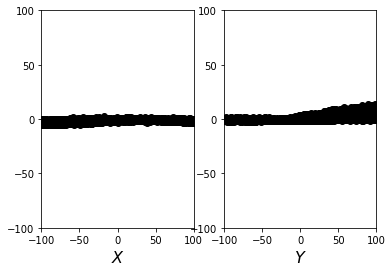

100%|██████████| 24/24 [00:00<00:00, 45.22it/s]

Epoch: 2 Train loss: 51728.7305


Test loss: 51113.2539


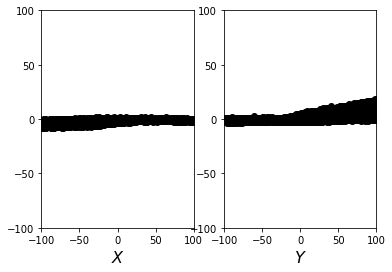

100%|██████████| 24/24 [00:00<00:00, 64.99it/s]

Epoch: 3 Train loss: 51252.3555


Test loss: 50540.9766


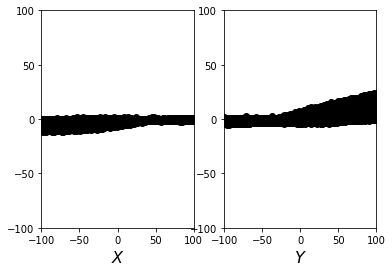

100%|██████████| 24/24 [00:00<00:00, 73.69it/s]

Epoch: 4 Train loss: 50541.0234


Test loss: 49651.9727


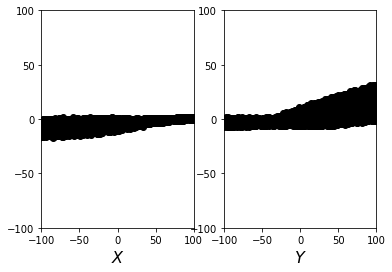

100%|██████████| 24/24 [00:00<00:00, 73.25it/s]

Epoch: 5 Train loss: 49417.8633


Test loss: 48199.8789


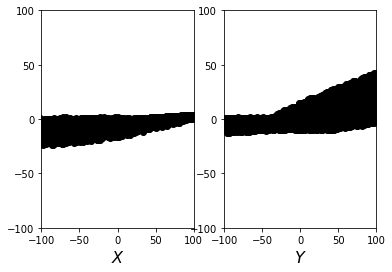

100%|██████████| 24/24 [00:00<00:00, 65.18it/s]

Epoch: 6 Train loss: 47575.3164


Test loss: 45777.3320


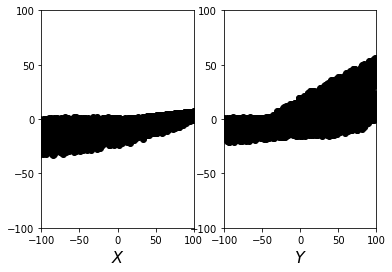

100%|██████████| 24/24 [00:00<00:00, 74.45it/s]

Epoch: 7 Train loss: 44587.7148


Test loss: 41862.1875


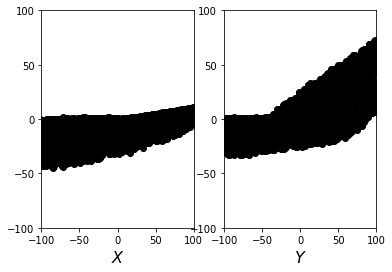

100%|██████████| 24/24 [00:00<00:00, 75.21it/s]

Epoch: 8 Train loss: 40156.5938


Test loss: 36511.1289


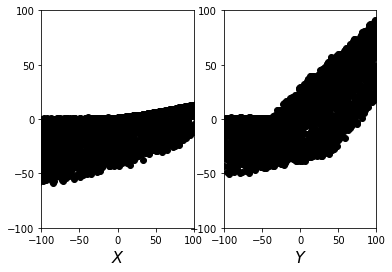

100%|██████████| 24/24 [00:00<00:00, 75.40it/s]

Epoch: 9 Train loss: 34918.3359


Test loss: 31180.6934


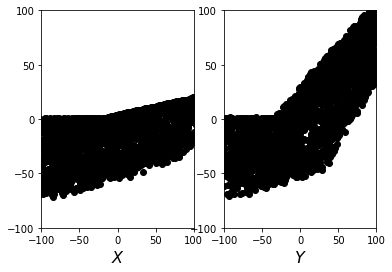

100%|██████████| 24/24 [00:00<00:00, 74.61it/s]

Epoch: 10 Train loss: 30925.6270


Test loss: 28485.2168


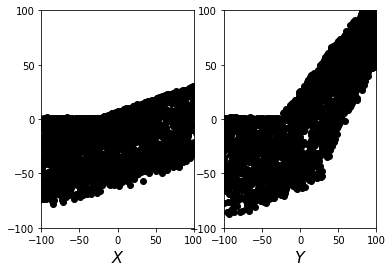

100%|██████████| 24/24 [00:00<00:00, 45.80it/s]

Epoch: 11 Train loss: 29458.3223


Test loss: 27807.2871


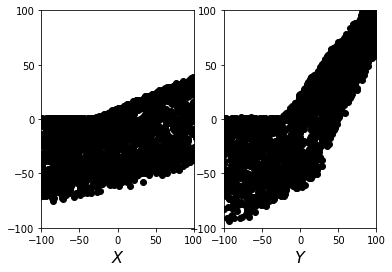

100%|██████████| 24/24 [00:00<00:00, 51.57it/s]

Epoch: 12 Train loss: 28930.7090


Test loss: 27367.5059


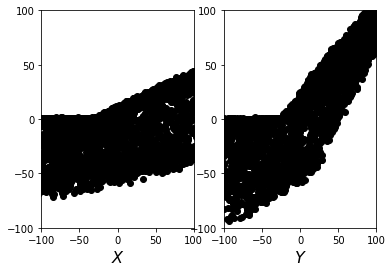

100%|██████████| 24/24 [00:00<00:00, 62.76it/s]

Epoch: 13 Train loss: 28508.8809


Test loss: 26986.4434


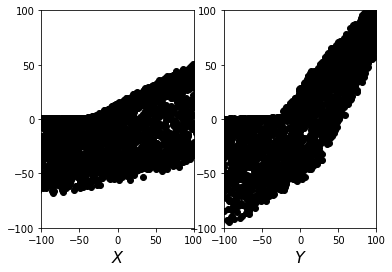

100%|██████████| 24/24 [00:00<00:00, 45.04it/s]

Epoch: 14 Train loss: 28142.2559


Test loss: 26661.7090


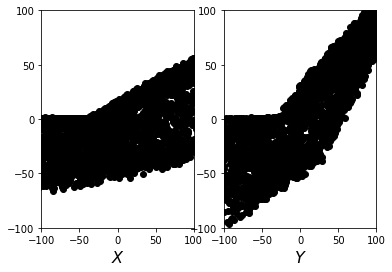

100%|██████████| 24/24 [00:00<00:00, 43.59it/s]

Epoch: 15 Train loss: 27834.3359


Test loss: 26389.4102


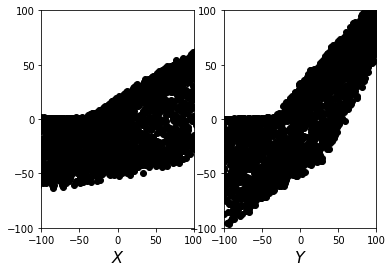

100%|██████████| 24/24 [00:00<00:00, 46.51it/s]

Epoch: 16 Train loss: 27567.8262


Test loss: 26153.2422


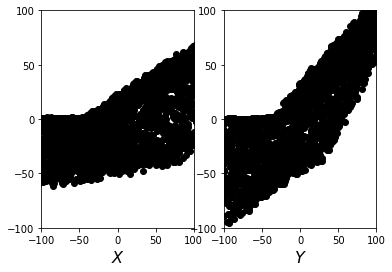

100%|██████████| 24/24 [00:00<00:00, 46.73it/s]

Epoch: 17 Train loss: 27333.9941


Test loss: 25949.1543


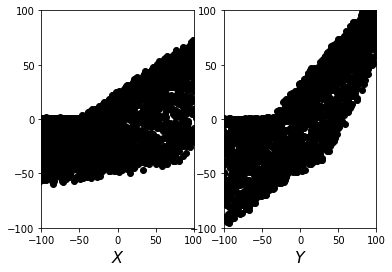

100%|██████████| 24/24 [00:00<00:00, 34.43it/s]

Epoch: 18 Train loss: 27124.4316


Test loss: 25762.5117


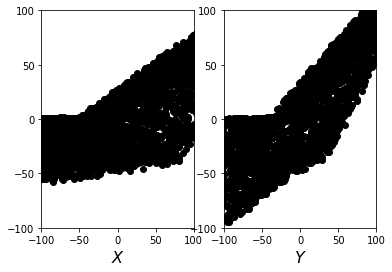

100%|██████████| 24/24 [00:00<00:00, 50.88it/s]

Epoch: 19 Train loss: 26927.8613


Test loss: 25581.1289


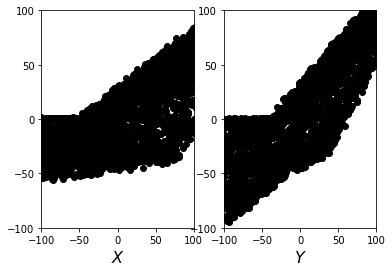

100%|██████████| 24/24 [00:00<00:00, 47.21it/s]

Epoch: 20 Train loss: 26742.6035


Test loss: 25413.9316


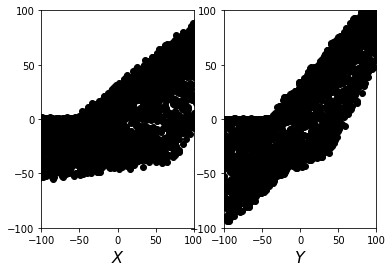

100%|██████████| 24/24 [00:00<00:00, 46.42it/s]

Epoch: 21 Train loss: 26571.0801


Test loss: 25261.2422


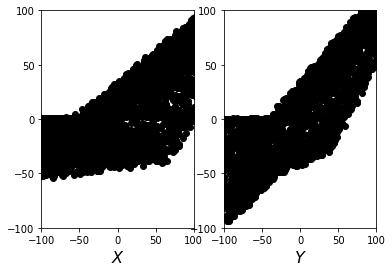

100%|██████████| 24/24 [00:00<00:00, 46.97it/s]

Epoch: 22 Train loss: 26404.1250


Test loss: 25115.0996


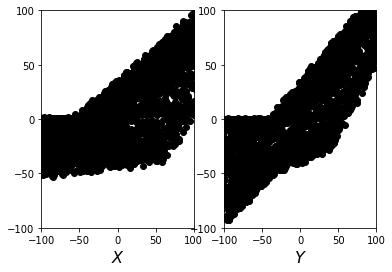

100%|██████████| 24/24 [00:00<00:00, 52.72it/s]

Epoch: 23 Train loss: 26232.4082


Test loss: 24928.5762


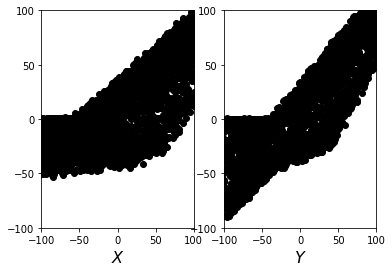

100%|██████████| 24/24 [00:00<00:00, 59.37it/s]

Epoch: 24 Train loss: 25982.6934


Test loss: 24657.6133


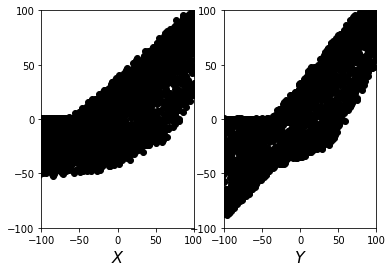

100%|██████████| 24/24 [00:00<00:00, 59.06it/s]

Epoch: 25 Train loss: 25665.9863


Test loss: 24360.1191


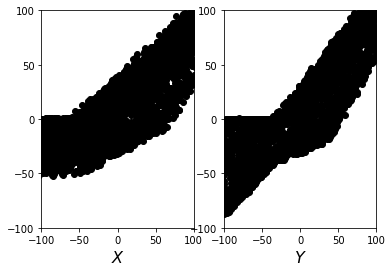

100%|██████████| 24/24 [00:00<00:00, 63.01it/s]

Epoch: 26 Train loss: 25353.6855


Test loss: 24081.0293


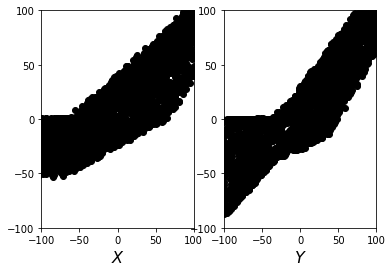

100%|██████████| 24/24 [00:00<00:00, 37.00it/s]

Epoch: 27 Train loss: 25076.3789


Test loss: 23851.0215


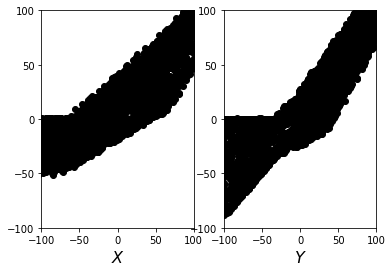

100%|██████████| 24/24 [00:00<00:00, 36.62it/s]

Epoch: 28 Train loss: 24842.5410


Test loss: 23648.7969


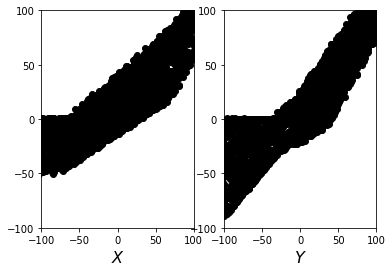

100%|██████████| 24/24 [00:00<00:00, 48.91it/s]

Epoch: 29 Train loss: 24638.5645


Test loss: 23467.3672


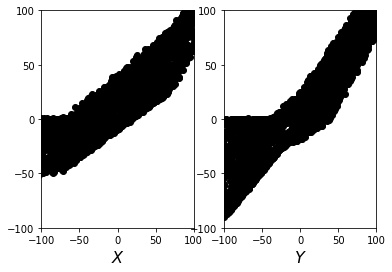

100%|██████████| 24/24 [00:00<00:00, 45.39it/s]

Epoch: 30 Train loss: 24453.1992


Test loss: 23301.2637


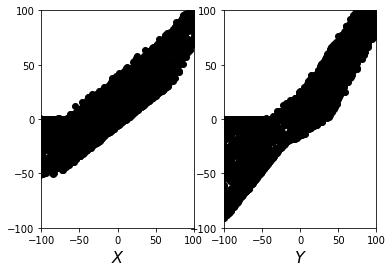

100%|██████████| 24/24 [00:00<00:00, 50.08it/s]

Epoch: 31 Train loss: 24283.3281


Test loss: 23140.4219


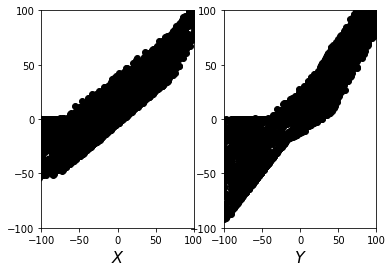

100%|██████████| 24/24 [00:00<00:00, 51.05it/s]

Epoch: 32 Train loss: 24097.1172


Test loss: 22935.0859


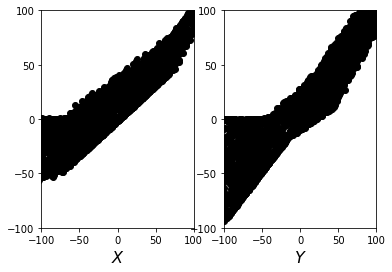

100%|██████████| 24/24 [00:00<00:00, 62.62it/s]

Epoch: 33 Train loss: 23818.3730


Test loss: 22577.4023


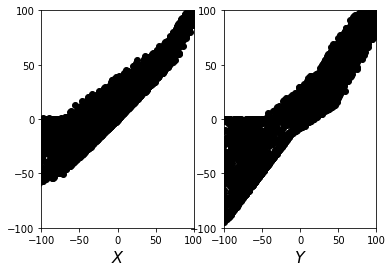

100%|██████████| 24/24 [00:00<00:00, 63.56it/s]

Epoch: 34 Train loss: 23284.6035


Test loss: 21790.8398


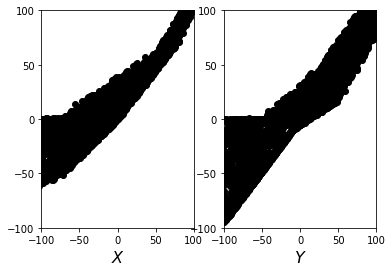

100%|██████████| 24/24 [00:00<00:00, 57.42it/s]

Epoch: 35 Train loss: 22075.1992


Test loss: 20004.1094


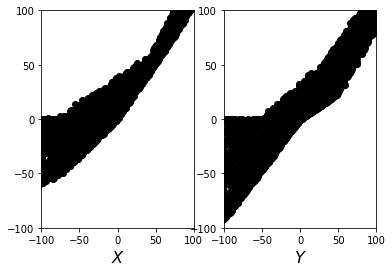

100%|██████████| 24/24 [00:00<00:00, 54.51it/s]

Epoch: 36 Train loss: 19825.7910


Test loss: 17460.1074


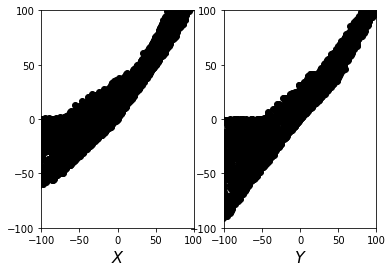

100%|██████████| 24/24 [00:00<00:00, 43.93it/s]

Epoch: 37 Train loss: 17494.9316


Test loss: 15605.3242


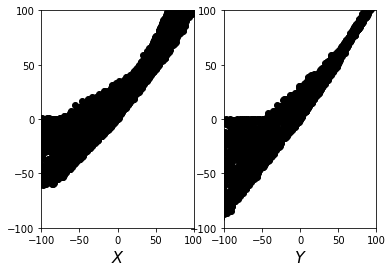

100%|██████████| 24/24 [00:00<00:00, 38.41it/s]

Epoch: 38 Train loss: 16024.5117


Test loss: 14565.5801


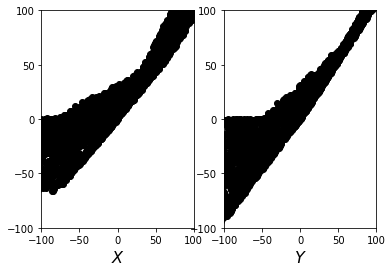

100%|██████████| 24/24 [00:00<00:00, 44.67it/s]

Epoch: 39 Train loss: 15078.3311


Test loss: 13822.8730


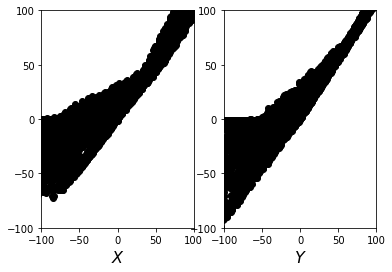

100%|██████████| 24/24 [00:00<00:00, 43.39it/s]

Epoch: 40 Train loss: 14316.7881


Test loss: 13201.2871


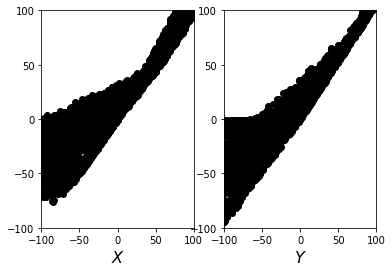

100%|██████████| 24/24 [00:00<00:00, 51.88it/s]

Epoch: 41 Train loss: 13637.2373


Test loss: 12625.1973


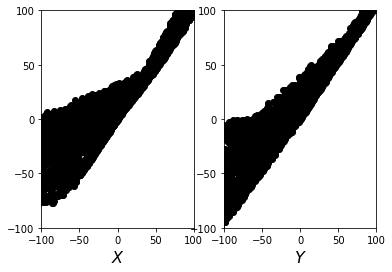

100%|██████████| 24/24 [00:00<00:00, 60.45it/s]


Epoch: 42 Train loss: 13009.7783
Test loss: 12074.5371


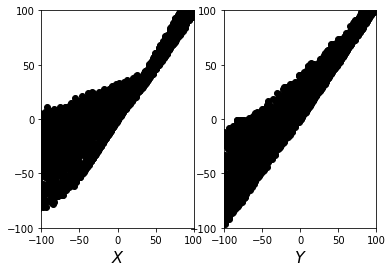

100%|██████████| 24/24 [00:00<00:00, 59.63it/s]

Epoch: 43 Train loss: 12227.1641


Test loss: 11248.8711


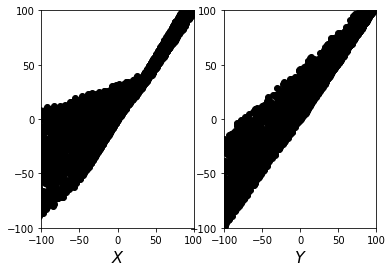

100%|██████████| 24/24 [00:00<00:00, 58.75it/s]

Epoch: 44 Train loss: 11339.4570


Test loss: 10595.3076


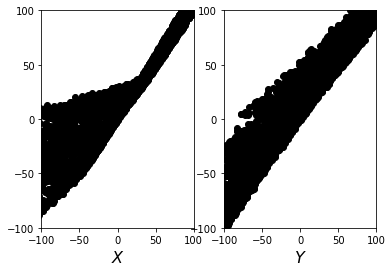

100%|██████████| 24/24 [00:00<00:00, 19.48it/s]

Epoch: 45 Train loss: 10683.1045


Test loss: 10120.0098


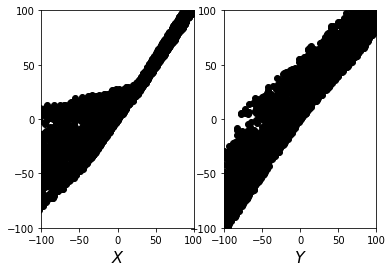

100%|██████████| 24/24 [00:00<00:00, 60.48it/s]

Epoch: 46 Train loss: 10196.9062


Test loss: 9767.0967


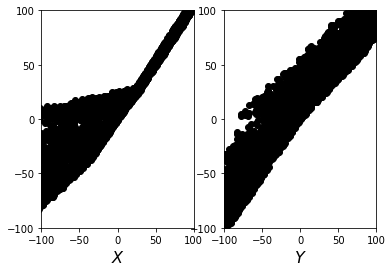

100%|██████████| 24/24 [00:00<00:00, 51.86it/s]

Epoch: 47 Train loss: 9856.8916


Test loss: 9508.6934


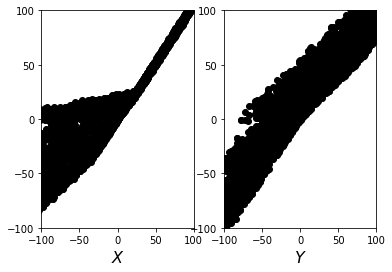

100%|██████████| 24/24 [00:00<00:00, 56.07it/s]

Epoch: 48 Train loss: 9580.9463


Test loss: 9272.1543


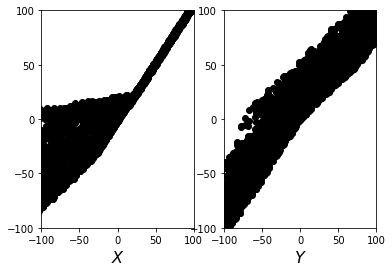

100%|██████████| 24/24 [00:00<00:00, 53.44it/s]

Epoch: 49 Train loss: 9331.6670


Test loss: 9064.3262


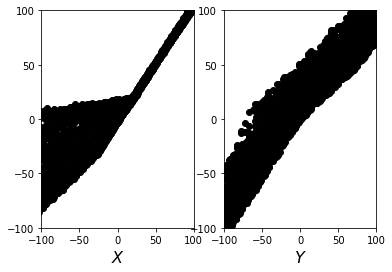

100%|██████████| 24/24 [00:00<00:00, 46.16it/s]

Epoch: 50 Train loss: 9108.2334


Test loss: 8864.7012


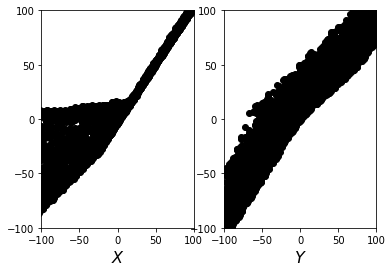

100%|██████████| 24/24 [00:00<00:00, 47.84it/s]

Epoch: 51 Train loss: 8904.8799


Test loss: 8671.9805


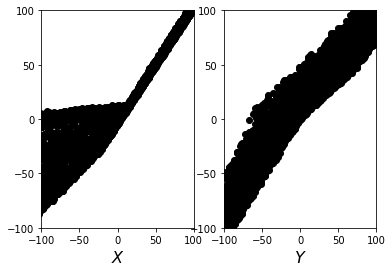

100%|██████████| 24/24 [00:00<00:00, 46.68it/s]

Epoch: 52 Train loss: 8701.5850


Test loss: 8482.9033


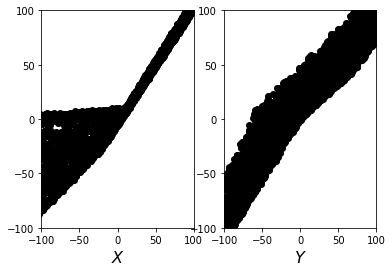

100%|██████████| 24/24 [00:00<00:00, 46.20it/s]

Epoch: 53 Train loss: 8506.6016


Test loss: 8297.4004


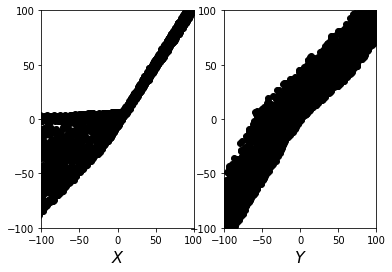

100%|██████████| 24/24 [00:00<00:00, 41.57it/s]

Epoch: 54 Train loss: 8315.6514


Test loss: 8116.8745


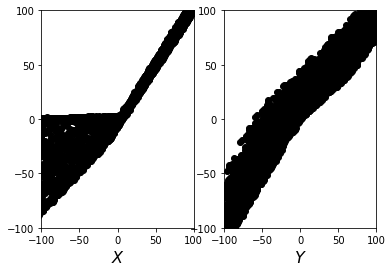

100%|██████████| 24/24 [00:00<00:00, 55.20it/s]

Epoch: 55 Train loss: 8123.3398


Test loss: 7920.2969


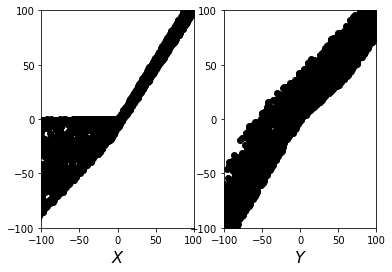

100%|██████████| 24/24 [00:02<00:00, 10.00it/s]

Epoch: 56 Train loss: 7935.5479


Test loss: 7747.8755


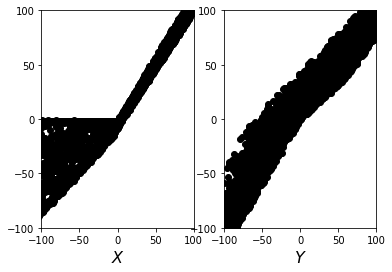

100%|██████████| 24/24 [00:00<00:00, 61.82it/s]

Epoch: 57 Train loss: 7763.5747


Test loss: 7590.5161


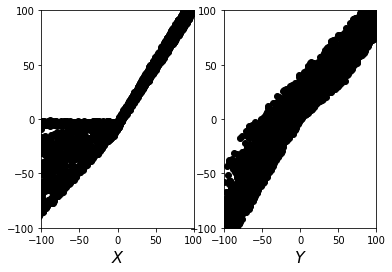

100%|██████████| 24/24 [00:00<00:00, 78.14it/s]


Epoch: 58 Train loss: 7559.1353
Test loss: 7317.9214


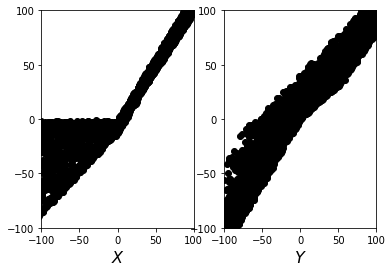

100%|██████████| 24/24 [00:00<00:00, 72.99it/s]

Epoch: 59 Train loss: 7147.4629


Test loss: 6874.5640


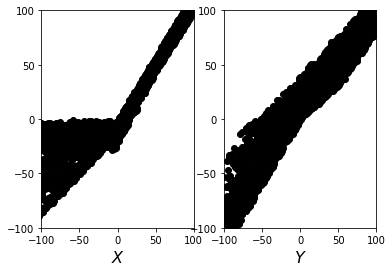

100%|██████████| 24/24 [00:00<00:00, 67.90it/s]

Epoch: 60 Train loss: 6712.3398


Test loss: 6429.2065


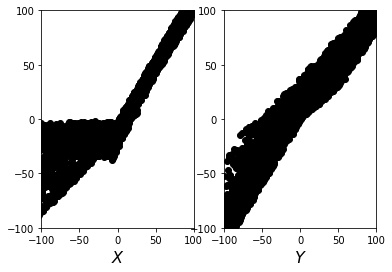

100%|██████████| 24/24 [00:00<00:00, 58.14it/s]

Epoch: 61 Train loss: 6265.1709


Test loss: 5963.5986


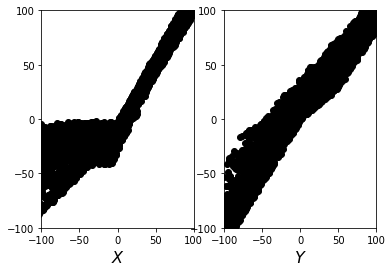

100%|██████████| 24/24 [00:00<00:00, 55.04it/s]

Epoch: 62 Train loss: 5752.1709


Test loss: 5278.8730


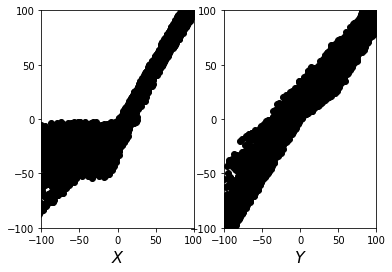

100%|██████████| 24/24 [00:00<00:00, 69.01it/s]

Epoch: 63 Train loss: 5040.2588


Test loss: 4648.6455


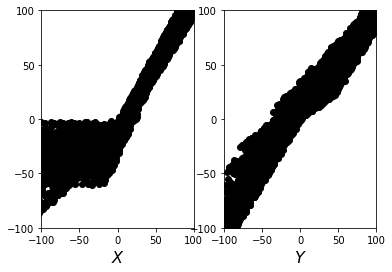

100%|██████████| 24/24 [00:00<00:00, 78.60it/s]

Epoch: 64 Train loss: 4572.7412


Test loss: 4240.0776


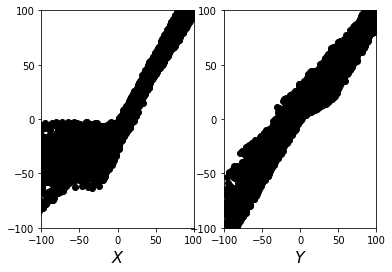

100%|██████████| 24/24 [00:00<00:00, 70.37it/s]

Epoch: 65 Train loss: 4210.9814


Test loss: 3925.8669


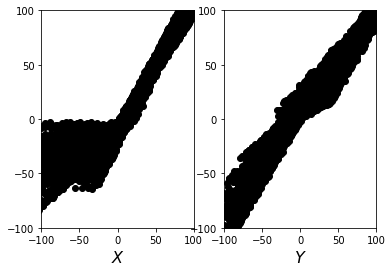

100%|██████████| 24/24 [00:00<00:00, 51.58it/s]

Epoch: 66 Train loss: 3924.3276


Test loss: 3676.0432


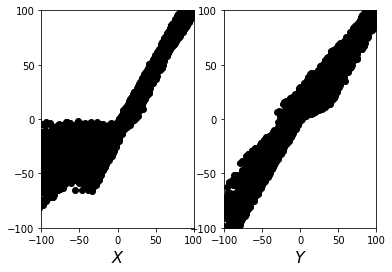

100%|██████████| 24/24 [00:00<00:00, 17.33it/s]

Epoch: 67 Train loss: 3682.1750


Test loss: 3469.2512


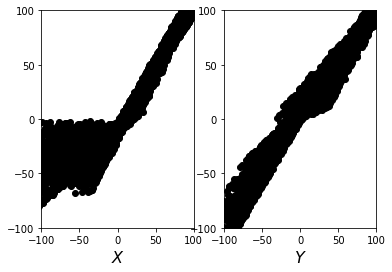

100%|██████████| 24/24 [00:00<00:00, 75.70it/s]

Epoch: 68 Train loss: 3457.0947


Test loss: 3295.1399


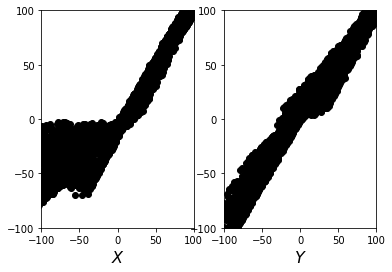

100%|██████████| 24/24 [00:00<00:00, 75.15it/s]

Epoch: 69 Train loss: 3274.8821


Test loss: 3160.3979


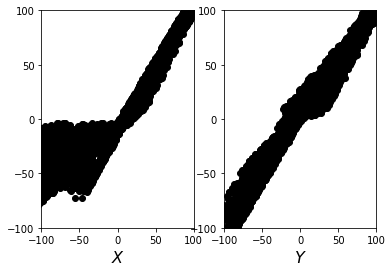

100%|██████████| 24/24 [00:00<00:00, 72.48it/s]

Epoch: 70 Train loss: 3127.5220


Test loss: 3044.0923


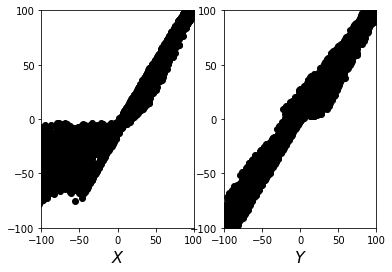

100%|██████████| 24/24 [00:00<00:00, 52.73it/s]

Epoch: 71 Train loss: 3008.6013


Test loss: 2943.4058


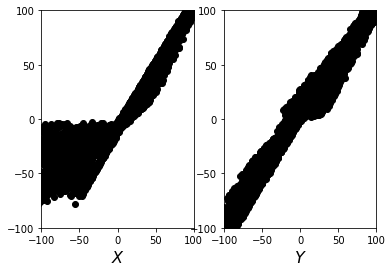

100%|██████████| 24/24 [00:00<00:00, 52.84it/s]

Epoch: 72 Train loss: 2911.2617


Test loss: 2860.8452


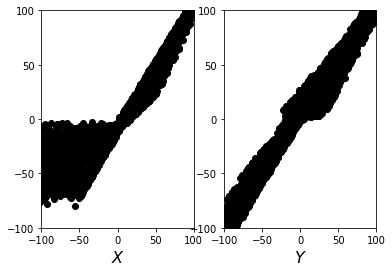

100%|██████████| 24/24 [00:00<00:00, 61.06it/s]

Epoch: 73 Train loss: 2835.7876


Test loss: 2787.1196


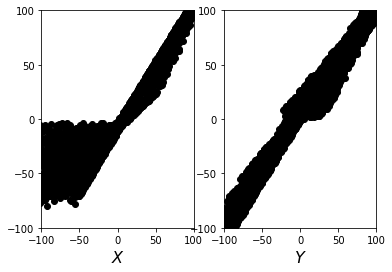

100%|██████████| 24/24 [00:00<00:00, 49.80it/s]

Epoch: 74 Train loss: 2758.1257


Test loss: 2712.7434


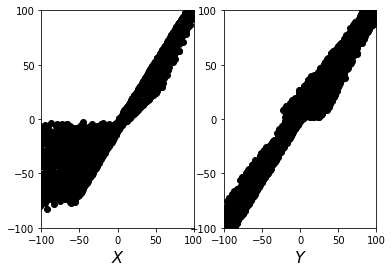

100%|██████████| 24/24 [00:00<00:00, 46.38it/s]

Epoch: 75 Train loss: 2688.5620


Test loss: 2650.3408


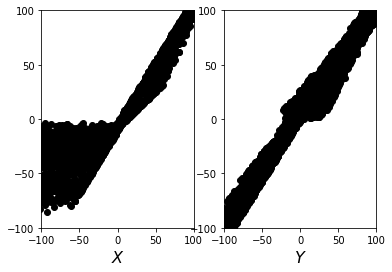

100%|██████████| 24/24 [00:00<00:00, 61.10it/s]

Epoch: 76 Train loss: 2623.4514


Test loss: 2586.5417


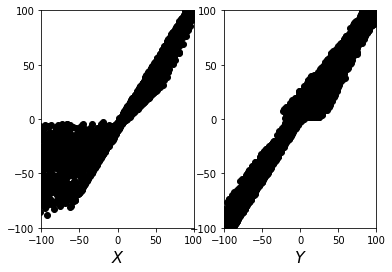

100%|██████████| 24/24 [00:00<00:00, 57.47it/s]

Epoch: 77 Train loss: 2561.2966


Test loss: 2515.7634


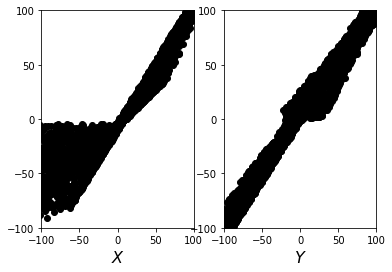

100%|██████████| 24/24 [00:00<00:00, 33.51it/s]

Epoch: 78 Train loss: 2497.6804


Test loss: 2454.6433


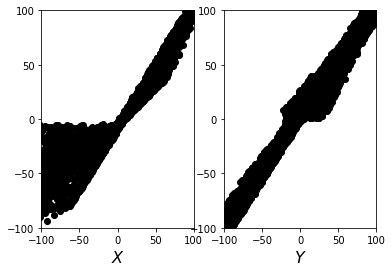

100%|██████████| 24/24 [00:00<00:00, 16.93it/s]

Epoch: 79 Train loss: 2439.3647


Test loss: 2385.5432


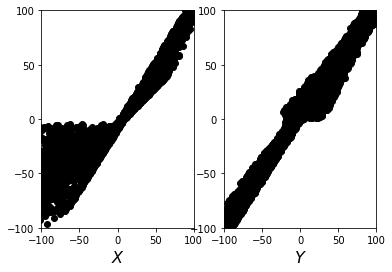

100%|██████████| 24/24 [00:00<00:00, 44.66it/s]

Epoch: 80 Train loss: 2375.0879


Test loss: 2319.8743


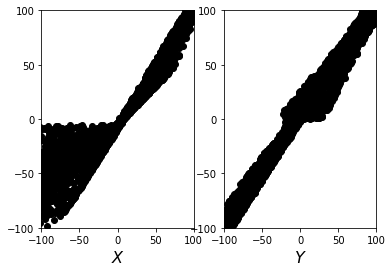

100%|██████████| 24/24 [00:00<00:00, 72.96it/s]

Epoch: 81 Train loss: 2306.3555


Test loss: 2248.7852


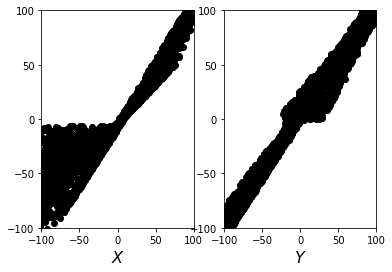

100%|██████████| 24/24 [00:00<00:00, 61.90it/s]

Epoch: 82 Train loss: 2238.4204


Test loss: 2173.4321


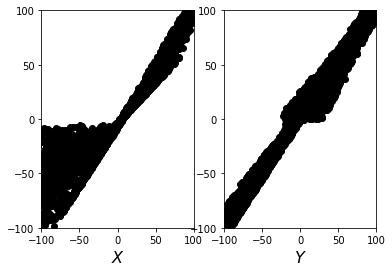

100%|██████████| 24/24 [00:00<00:00, 65.67it/s]

Epoch: 83 Train loss: 2168.2549


Test loss: 2098.9314


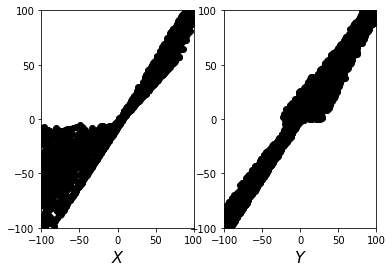

100%|██████████| 24/24 [00:00<00:00, 69.67it/s]

Epoch: 84 Train loss: 2098.2122


Test loss: 2025.0885


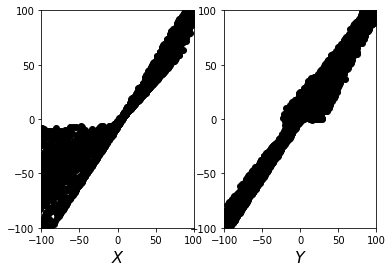

100%|██████████| 24/24 [00:00<00:00, 73.62it/s]

Epoch: 85 Train loss: 2023.6472


Test loss: 1945.6483


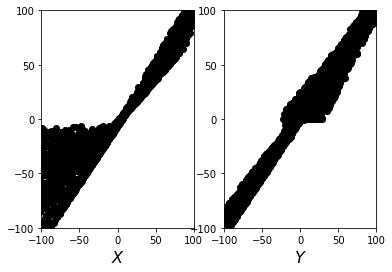

100%|██████████| 24/24 [00:00<00:00, 73.39it/s]

Epoch: 86 Train loss: 1946.4841


Test loss: 1859.7823


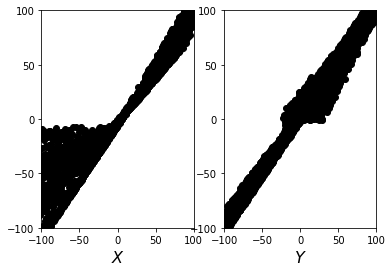

100%|██████████| 24/24 [00:00<00:00, 68.51it/s]

Epoch: 87 Train loss: 1868.9763


Test loss: 1777.4220


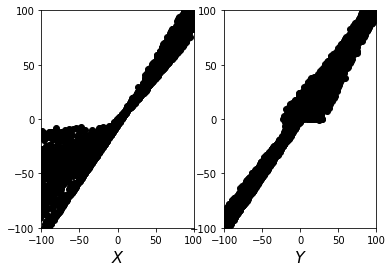

100%|██████████| 24/24 [00:00<00:00, 88.78it/s]

Epoch: 88 Train loss: 1794.1482


Test loss: 1698.1860


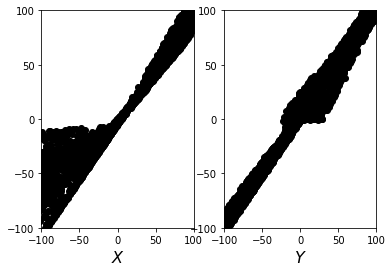

100%|██████████| 24/24 [00:00<00:00, 75.37it/s]

Epoch: 89 Train loss: 1720.8317


Test loss: 1622.1780


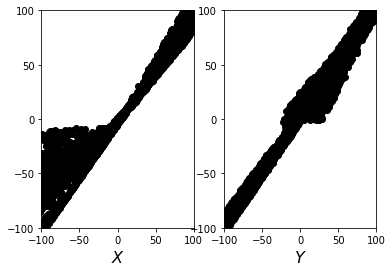

100%|██████████| 24/24 [00:00<00:00, 81.41it/s]

Epoch: 90 Train loss: 1648.0804


Test loss: 1546.5706


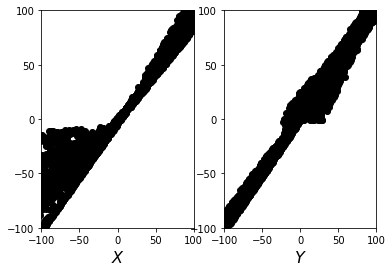

100%|██████████| 24/24 [00:00<00:00, 92.07it/s]

Epoch: 91 Train loss: 1579.8448


Test loss: 1482.0106


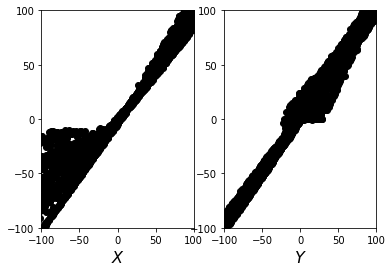

100%|██████████| 24/24 [00:00<00:00, 85.23it/s]

Epoch: 92 Train loss: 1521.1322


Test loss: 1419.7144


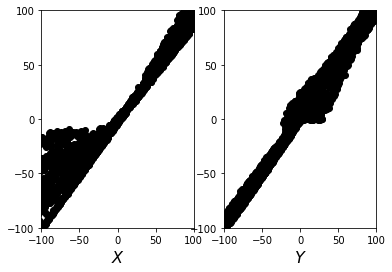

100%|██████████| 24/24 [00:00<00:00, 84.20it/s]

Epoch: 93 Train loss: 1458.3943


Test loss: 1354.6752


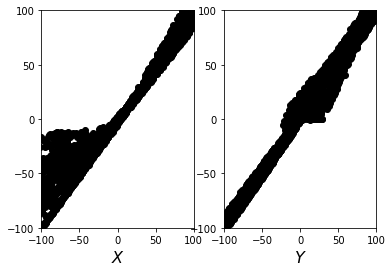

100%|██████████| 24/24 [00:00<00:00, 64.85it/s]

Epoch: 94 Train loss: 1400.2349


Test loss: 1291.6696


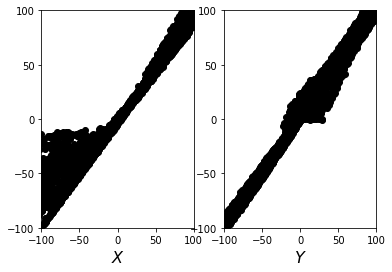

100%|██████████| 24/24 [00:00<00:00, 74.52it/s]

Epoch: 95 Train loss: 1347.8610


Test loss: 1236.8357


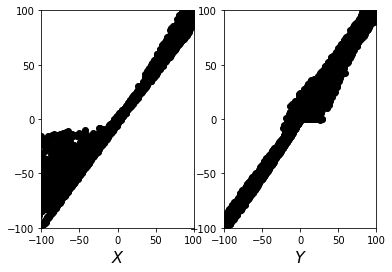

100%|██████████| 24/24 [00:00<00:00, 71.62it/s]

Epoch: 96 Train loss: 1295.7533


Test loss: 1183.5715


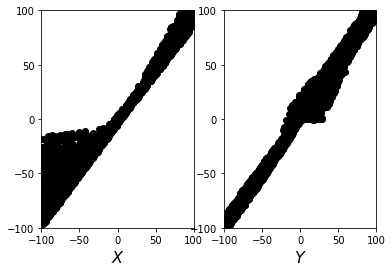

100%|██████████| 24/24 [00:00<00:00, 82.16it/s]

Epoch: 97 Train loss: 1243.3505


Test loss: 1133.2542


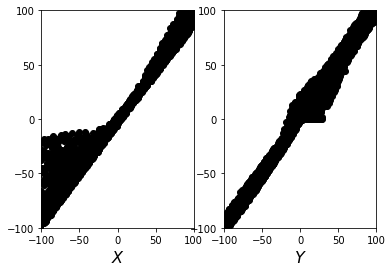

100%|██████████| 24/24 [00:00<00:00, 72.82it/s]

Epoch: 98 Train loss: 1193.2120


Test loss: 1091.5155


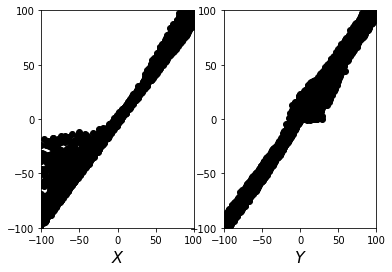

100%|██████████| 24/24 [00:00<00:00, 72.77it/s]

Epoch: 99 Train loss: 1146.9578


Test loss: 1046.8607


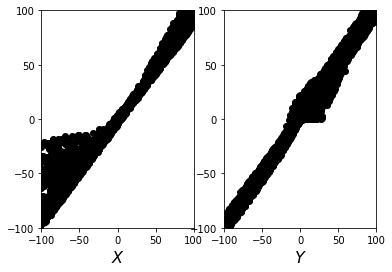

100%|██████████| 24/24 [00:00<00:00, 65.40it/s]

Epoch: 100 Train loss: 1095.7091


Test loss: 1001.5648


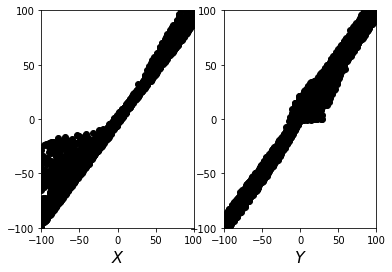

100%|██████████| 24/24 [00:00<00:00, 46.86it/s]

Epoch: 101 Train loss: 1048.9224


Test loss: 957.5764


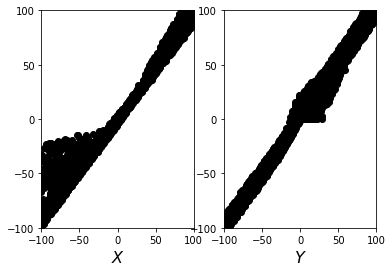

100%|██████████| 24/24 [00:00<00:00, 47.77it/s]

Epoch: 102 Train loss: 1003.3593


Test loss: 913.7132


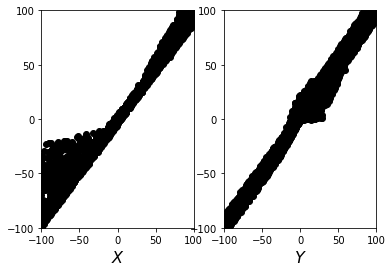

100%|██████████| 24/24 [00:00<00:00, 43.29it/s]

Epoch: 103 Train loss: 958.0622


Test loss: 868.9825


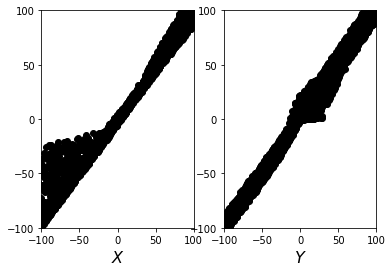

100%|██████████| 24/24 [00:00<00:00, 50.68it/s]

Epoch: 104 Train loss: 909.1036


Test loss: 821.9309


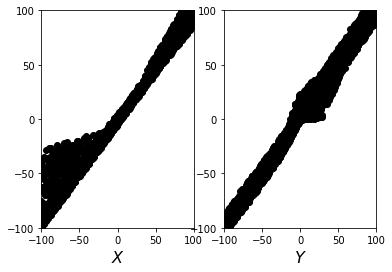

100%|██████████| 24/24 [00:00<00:00, 59.53it/s]

Epoch: 105 Train loss: 858.5130


Test loss: 778.1672


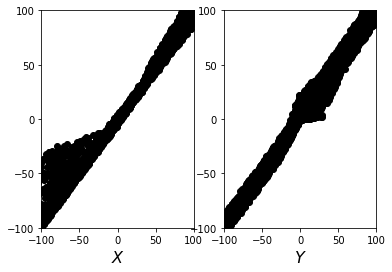

100%|██████████| 24/24 [00:00<00:00, 52.99it/s]

Epoch: 106 Train loss: 806.2372


Test loss: 733.4042


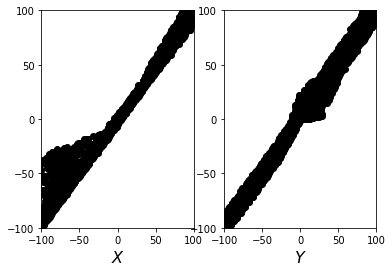

100%|██████████| 24/24 [00:00<00:00, 66.38it/s]

Epoch: 107 Train loss: 755.3318


Test loss: 689.9554


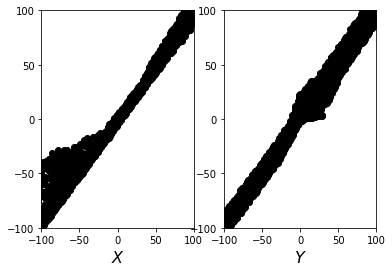

100%|██████████| 24/24 [00:00<00:00, 51.80it/s]

Epoch: 108 Train loss: 708.1232


Test loss: 647.7321


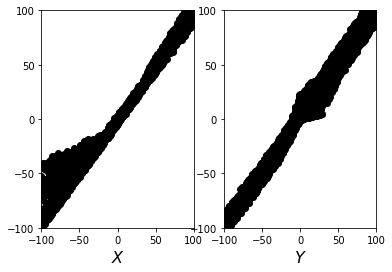

100%|██████████| 24/24 [00:00<00:00, 33.84it/s]

Epoch: 109 Train loss: 663.8640


Test loss: 604.3130


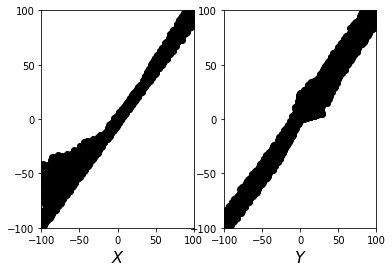

100%|██████████| 24/24 [00:00<00:00, 56.75it/s]

Epoch: 110 Train loss: 622.3005


Test loss: 563.7418


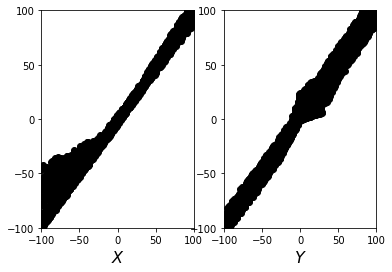

100%|██████████| 24/24 [00:00<00:00, 54.33it/s]

Epoch: 111 Train loss: 581.9842


Test loss: 526.6268


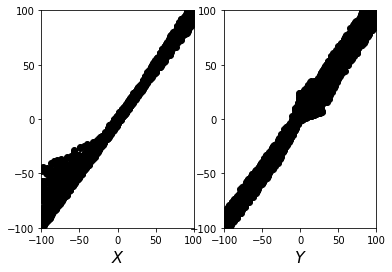

100%|██████████| 24/24 [00:00<00:00, 50.21it/s]

Epoch: 112 Train loss: 544.0005


Test loss: 490.8987


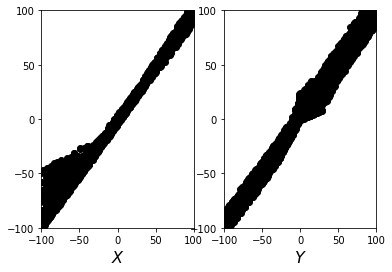

100%|██████████| 24/24 [00:00<00:00, 47.48it/s]

Epoch: 113 Train loss: 507.2382


Test loss: 456.6606


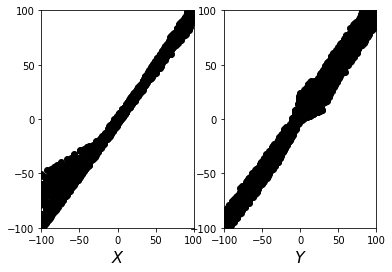

100%|██████████| 24/24 [00:00<00:00, 52.09it/s]

Epoch: 114 Train loss: 471.0312


Test loss: 423.6552


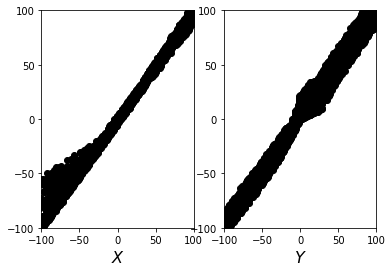

100%|██████████| 24/24 [00:00<00:00, 44.18it/s]

Epoch: 115 Train loss: 438.6507


Test loss: 394.7934


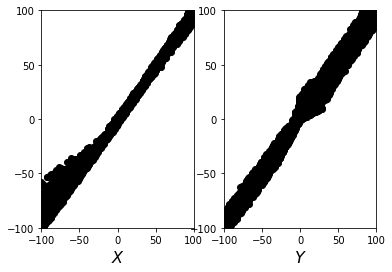

100%|██████████| 24/24 [00:00<00:00, 60.90it/s]

Epoch: 116 Train loss: 408.7670


Test loss: 369.5536


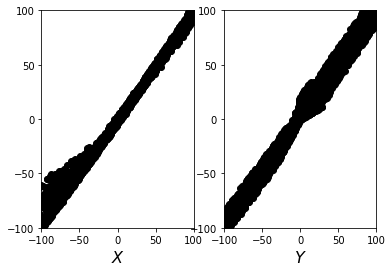

100%|██████████| 24/24 [00:00<00:00, 45.68it/s]

Epoch: 117 Train loss: 384.9265


Test loss: 347.8128


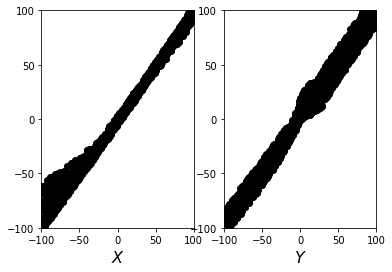

100%|██████████| 24/24 [00:00<00:00, 42.94it/s]

Epoch: 118 Train loss: 362.3741


Test loss: 327.4739


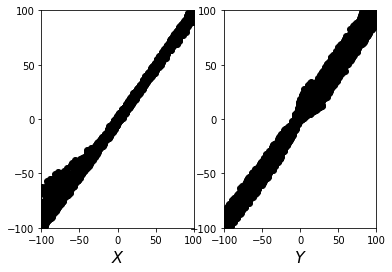

100%|██████████| 24/24 [00:00<00:00, 50.96it/s]

Epoch: 119 Train loss: 342.7849


Test loss: 309.7039


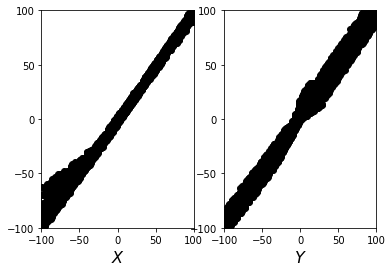

100%|██████████| 24/24 [00:00<00:00, 51.97it/s]

Epoch: 120 Train loss: 324.1714


Test loss: 294.0519


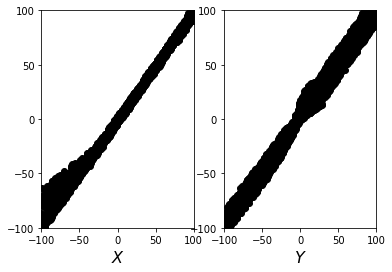

100%|██████████| 24/24 [00:00<00:00, 40.87it/s]

Epoch: 121 Train loss: 307.5695


Test loss: 277.7523


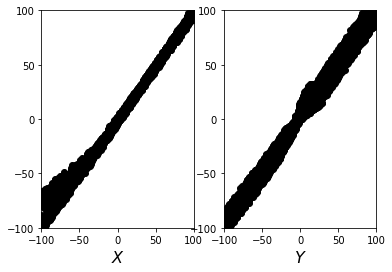

100%|██████████| 24/24 [00:00<00:00, 63.09it/s]

Epoch: 122 Train loss: 291.4511


Test loss: 262.8434


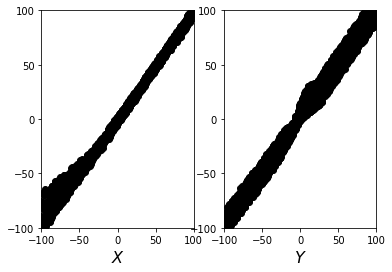

100%|██████████| 24/24 [00:00<00:00, 61.78it/s]

Epoch: 123 Train loss: 276.7844


Test loss: 249.7325


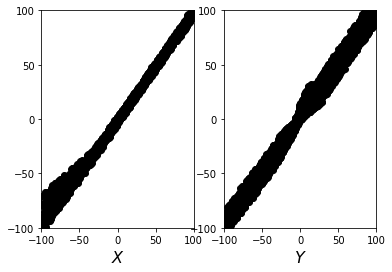

100%|██████████| 24/24 [00:00<00:00, 67.20it/s]

Epoch: 124 Train loss: 263.3137


Test loss: 238.0043


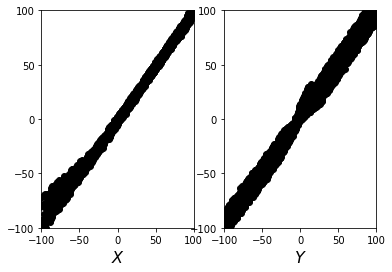

100%|██████████| 24/24 [00:00<00:00, 66.89it/s]

Epoch: 125 Train loss: 253.4648


Test loss: 227.2989


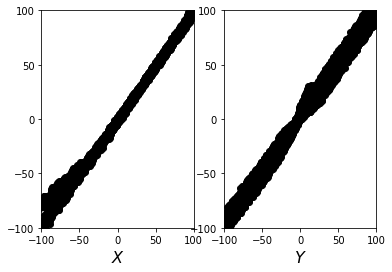

100%|██████████| 24/24 [00:00<00:00, 63.46it/s]

Epoch: 126 Train loss: 241.8826


Test loss: 217.4599


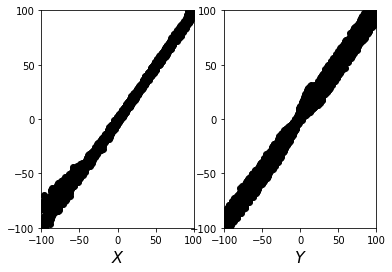

100%|██████████| 24/24 [00:00<00:00, 61.27it/s]

Epoch: 127 Train loss: 231.2871


Test loss: 209.0401


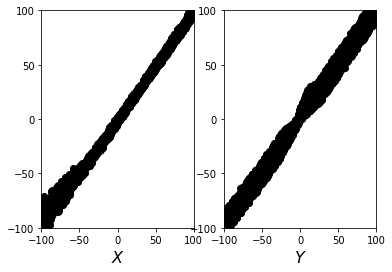

100%|██████████| 24/24 [00:00<00:00, 73.23it/s]

Epoch: 128 Train loss: 221.6759


Test loss: 201.3775


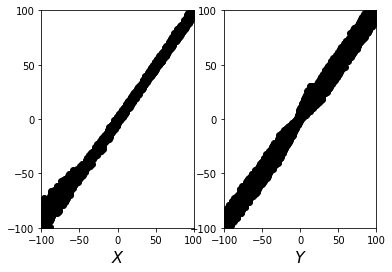

100%|██████████| 24/24 [00:00<00:00, 36.34it/s]

Epoch: 129 Train loss: 213.0748


Test loss: 195.5469


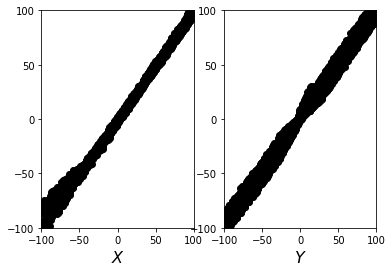

100%|██████████| 24/24 [00:00<00:00, 46.03it/s]

Epoch: 130 Train loss: 205.8039


Test loss: 190.0526


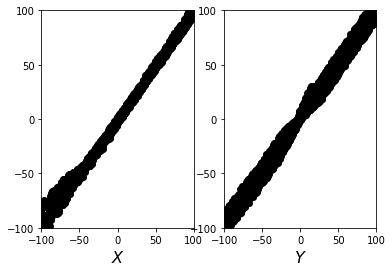

100%|██████████| 24/24 [00:00<00:00, 33.43it/s]

Epoch: 131 Train loss: 197.8744


Test loss: 184.5200


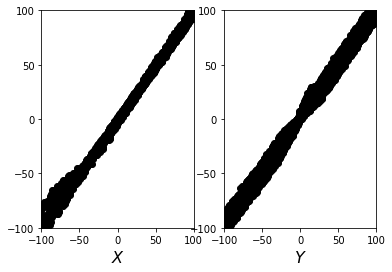

100%|██████████| 24/24 [00:00<00:00, 19.13it/s]

Epoch: 132 Train loss: 191.6022


Test loss: 179.7513


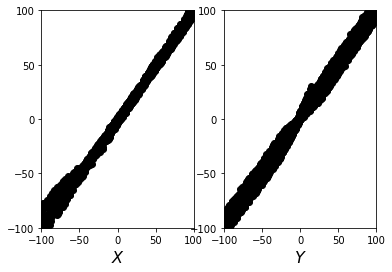

100%|██████████| 24/24 [00:00<00:00, 44.79it/s]

Epoch: 133 Train loss: 186.6506


Test loss: 174.9868


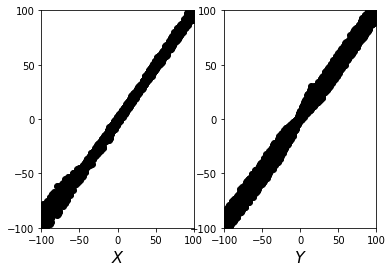

100%|██████████| 24/24 [00:00<00:00, 44.58it/s]

Epoch: 134 Train loss: 180.9667


Test loss: 171.2395


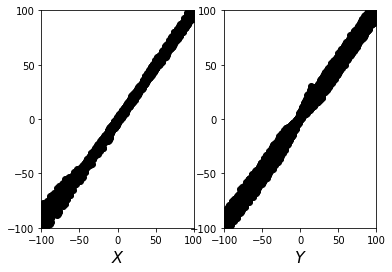

100%|██████████| 24/24 [00:00<00:00, 59.94it/s]

Epoch: 135 Train loss: 176.1930


Test loss: 167.2060


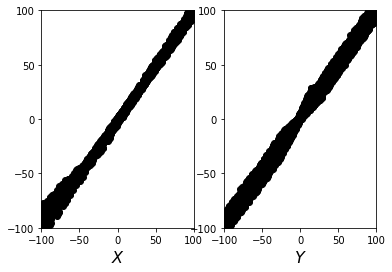

100%|██████████| 24/24 [00:00<00:00, 71.09it/s]

Epoch: 136 Train loss: 171.7135


Test loss: 163.9374


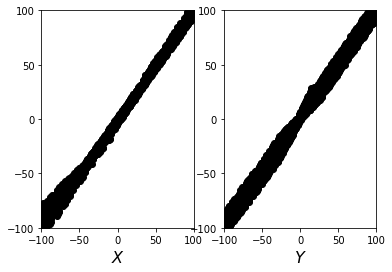

100%|██████████| 24/24 [00:00<00:00, 64.10it/s]

Epoch: 137 Train loss: 167.3450


Test loss: 160.1988


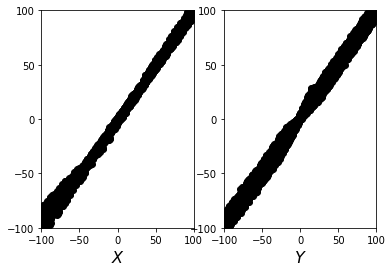

100%|██████████| 24/24 [00:00<00:00, 54.31it/s]

Epoch: 138 Train loss: 163.2042


Test loss: 156.2869


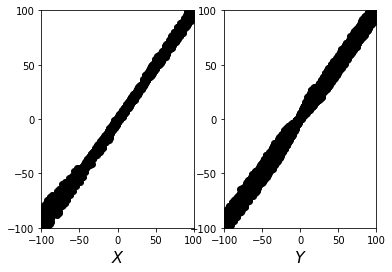

100%|██████████| 24/24 [00:00<00:00, 35.58it/s]

Epoch: 139 Train loss: 159.0921


Test loss: 154.1634


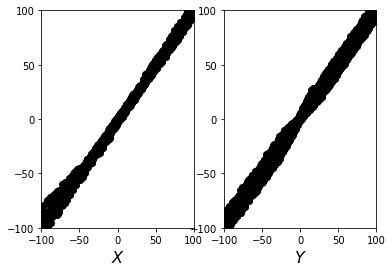

100%|██████████| 24/24 [00:00<00:00, 22.12it/s]

Epoch: 140 Train loss: 156.0486


Test loss: 150.7350


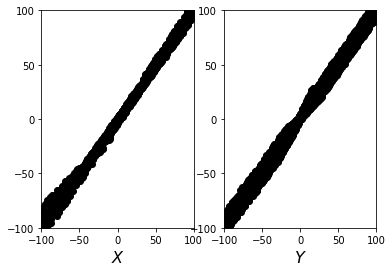

100%|██████████| 24/24 [00:00<00:00, 53.95it/s]

Epoch: 141 Train loss: 152.8667


Test loss: 148.2179


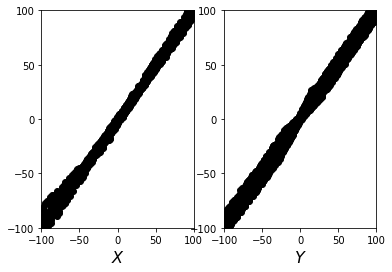

100%|██████████| 24/24 [00:00<00:00, 49.17it/s]

Epoch: 142 Train loss: 150.2195


Test loss: 145.8441


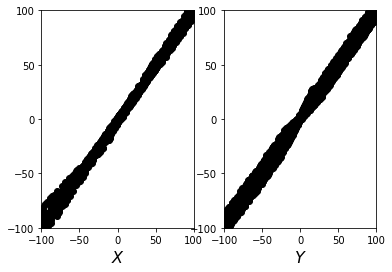

100%|██████████| 24/24 [00:00<00:00, 62.91it/s]

Epoch: 143 Train loss: 147.4998


Test loss: 142.2945


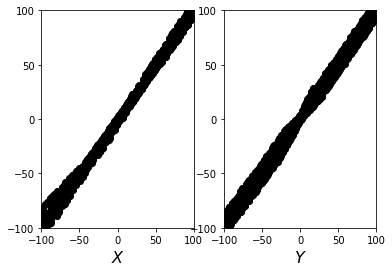

100%|██████████| 24/24 [00:00<00:00, 65.48it/s]

Epoch: 144 Train loss: 144.3155


Test loss: 139.7794


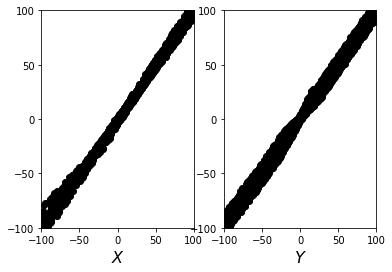

100%|██████████| 24/24 [00:01<00:00, 23.74it/s]

Epoch: 145 Train loss: 141.8908


Test loss: 137.4349


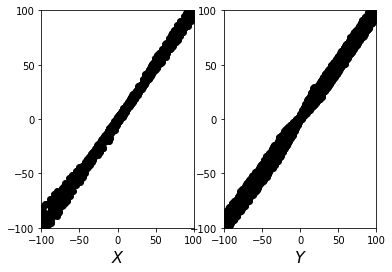

100%|██████████| 24/24 [00:00<00:00, 77.77it/s]

Epoch: 146 Train loss: 139.5644


Test loss: 136.0673


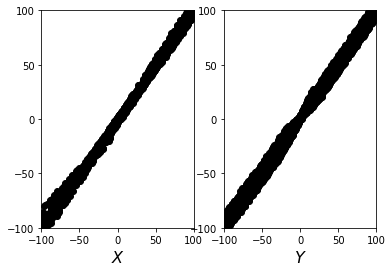

100%|██████████| 24/24 [00:00<00:00, 59.10it/s]

Epoch: 147 Train loss: 137.0528


Test loss: 133.0809


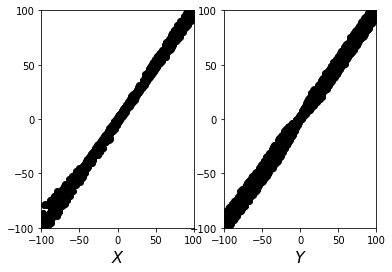

100%|██████████| 24/24 [00:00<00:00, 58.21it/s]

Epoch: 148 Train loss: 134.7048


Test loss: 131.3835


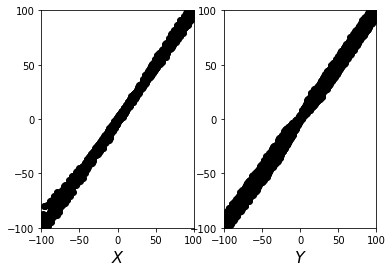

100%|██████████| 24/24 [00:00<00:00, 62.80it/s]

Epoch: 149 Train loss: 132.3333


Test loss: 129.2662


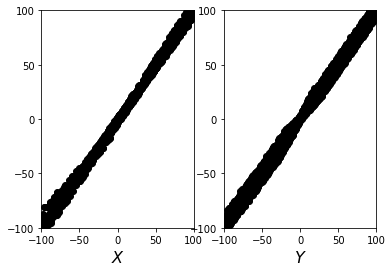

100%|██████████| 24/24 [00:00<00:00, 51.98it/s]

Epoch: 150 Train loss: 129.4288


Test loss: 126.8369


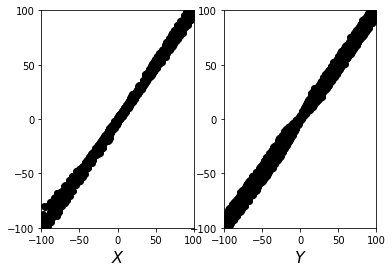

100%|██████████| 24/24 [00:00<00:00, 58.72it/s]


Epoch: 151 Train loss: 126.4821
Test loss: 123.0492


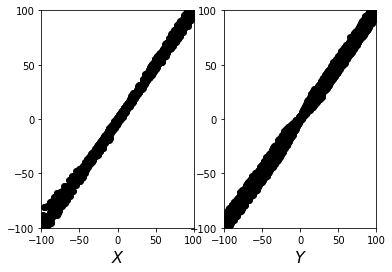

100%|██████████| 24/24 [00:00<00:00, 62.71it/s]

Epoch: 152 Train loss: 122.6490


Test loss: 119.6458


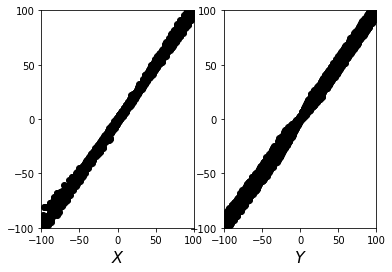

100%|██████████| 24/24 [00:00<00:00, 56.59it/s]

Epoch: 153 Train loss: 119.4700


Test loss: 116.7987


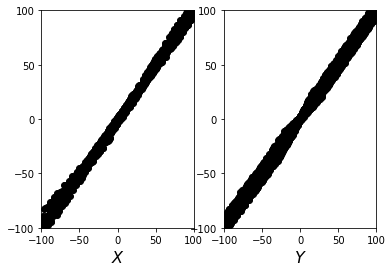

100%|██████████| 24/24 [00:00<00:00, 61.29it/s]

Epoch: 154 Train loss: 116.8866


Test loss: 113.5721


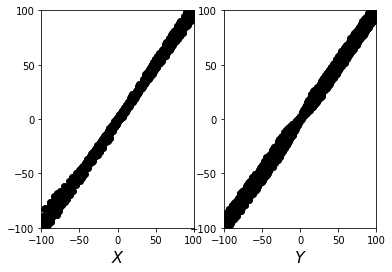

100%|██████████| 24/24 [00:00<00:00, 44.95it/s]

Epoch: 155 Train loss: 114.0900


Test loss: 111.3954


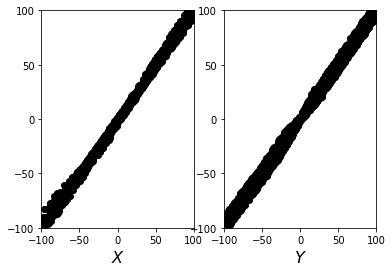

100%|██████████| 24/24 [00:00<00:00, 65.45it/s]

Epoch: 156 Train loss: 111.5229


Test loss: 108.6862


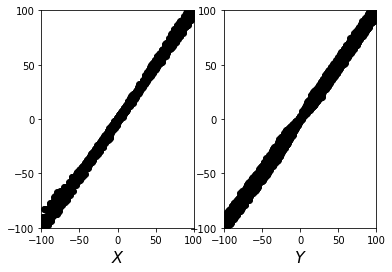

100%|██████████| 24/24 [00:00<00:00, 58.93it/s]

Epoch: 157 Train loss: 108.3007


Test loss: 106.1864


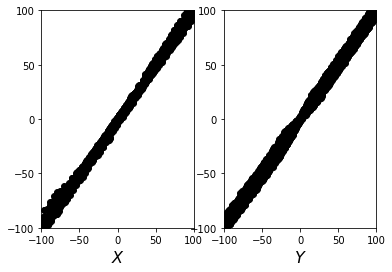

100%|██████████| 24/24 [00:00<00:00, 60.24it/s]

Epoch: 158 Train loss: 105.6750


Test loss: 103.8601


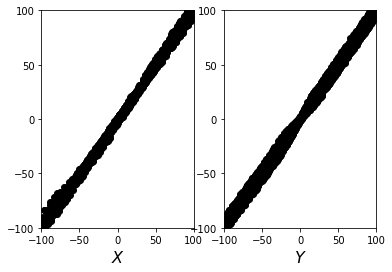

100%|██████████| 24/24 [00:00<00:00, 65.96it/s]

Epoch: 159 Train loss: 103.2736


Test loss: 101.1999


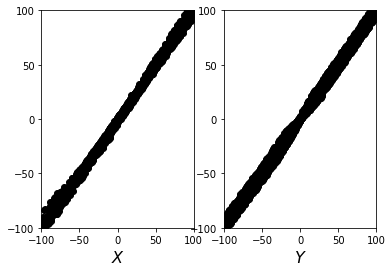

100%|██████████| 24/24 [00:00<00:00, 56.73it/s]

Epoch: 160 Train loss: 100.9972


Test loss: 98.9328


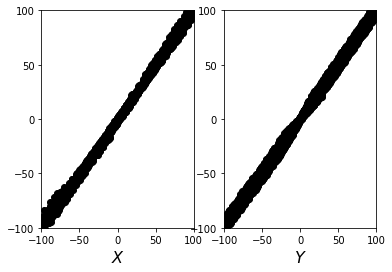

100%|██████████| 24/24 [00:00<00:00, 60.52it/s]

Epoch: 161 Train loss: 98.3653


Test loss: 96.7012


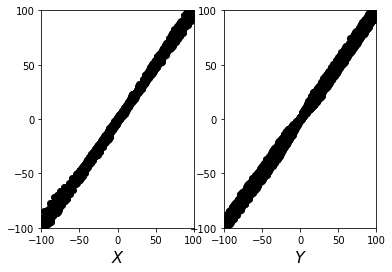

100%|██████████| 24/24 [00:00<00:00, 63.20it/s]

Epoch: 162 Train loss: 96.1737


Test loss: 94.6887


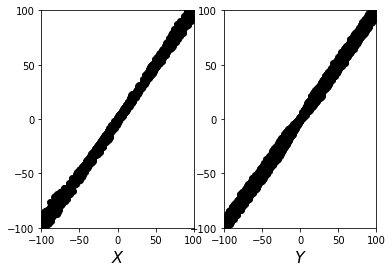

100%|██████████| 24/24 [00:00<00:00, 39.27it/s]

Epoch: 163 Train loss: 94.1339


Test loss: 92.3498


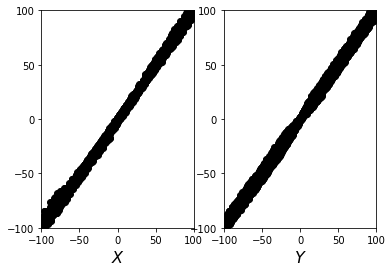

100%|██████████| 24/24 [00:00<00:00, 54.58it/s]

Epoch: 164 Train loss: 92.3097


Test loss: 90.4620


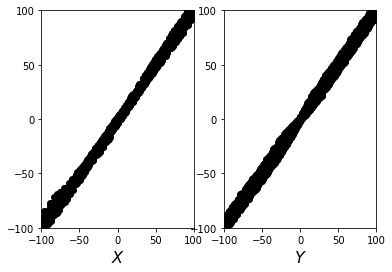

100%|██████████| 24/24 [00:00<00:00, 52.76it/s]

Epoch: 165 Train loss: 89.9009


Test loss: 88.1247


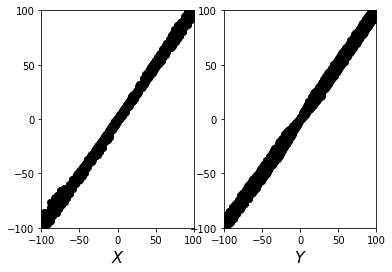

100%|██████████| 24/24 [00:00<00:00, 53.21it/s]

Epoch: 166 Train loss: 87.7495


Test loss: 85.8605


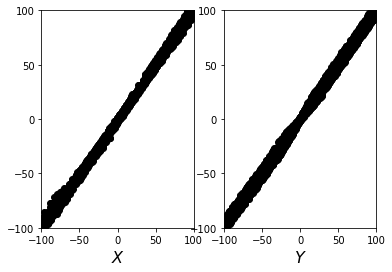

100%|██████████| 24/24 [00:00<00:00, 45.06it/s]


Epoch: 167 Train loss: 85.7744
Test loss: 84.2487


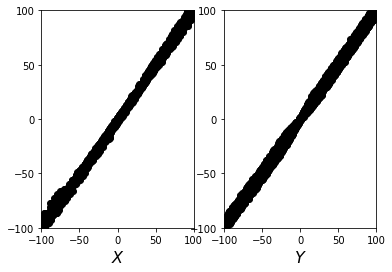

100%|██████████| 24/24 [00:00<00:00, 70.77it/s]

Epoch: 168 Train loss: 84.0044


Test loss: 82.2487


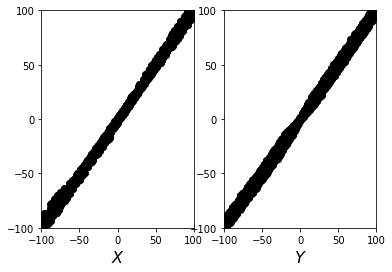

100%|██████████| 24/24 [00:00<00:00, 52.12it/s]

Epoch: 169 Train loss: 81.7311


Test loss: 80.2169


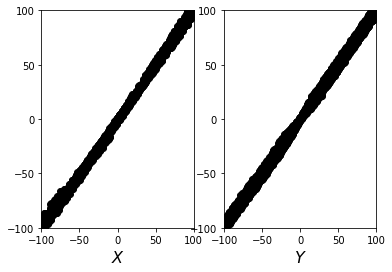

100%|██████████| 24/24 [00:00<00:00, 73.21it/s]

Epoch: 170 Train loss: 79.8015


Test loss: 78.2753


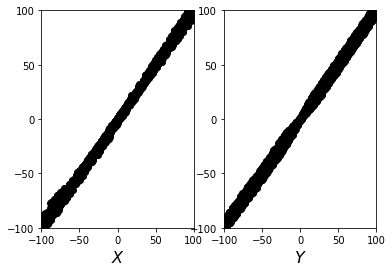

100%|██████████| 24/24 [00:00<00:00, 59.53it/s]

Epoch: 171 Train loss: 78.0004


Test loss: 76.5639


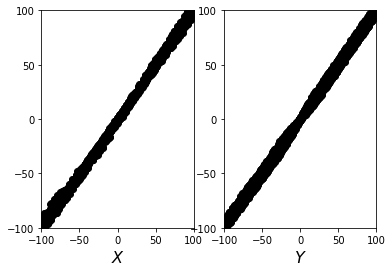

100%|██████████| 24/24 [00:00<00:00, 60.86it/s]

Epoch: 172 Train loss: 76.3585


Test loss: 74.3709


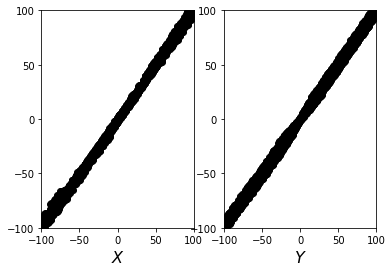

100%|██████████| 24/24 [00:00<00:00, 46.34it/s]

Epoch: 173 Train loss: 74.1977


Test loss: 72.8943


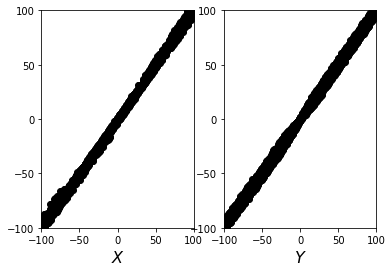

100%|██████████| 24/24 [00:00<00:00, 68.19it/s]

Epoch: 174 Train loss: 72.7008


Test loss: 71.2305


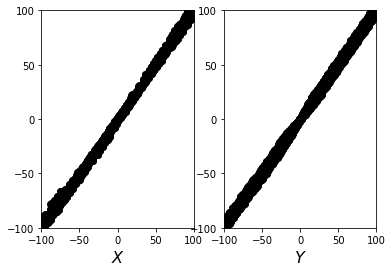

100%|██████████| 24/24 [00:00<00:00, 54.76it/s]


Epoch: 175 Train loss: 70.5783
Test loss: 69.5091


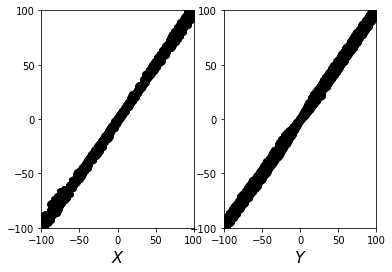

100%|██████████| 24/24 [00:00<00:00, 40.82it/s]

Epoch: 176 Train loss: 69.4725


Test loss: 67.6016


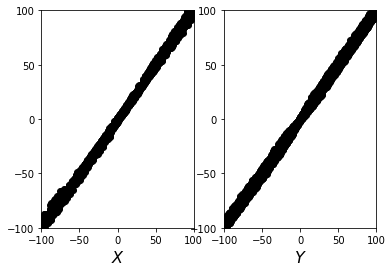

100%|██████████| 24/24 [00:00<00:00, 55.71it/s]

Epoch: 177 Train loss: 67.7940


Test loss: 65.9758


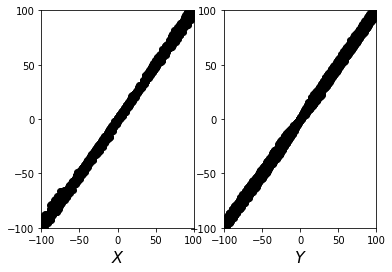

100%|██████████| 24/24 [00:00<00:00, 61.55it/s]

Epoch: 178 Train loss: 65.8447


Test loss: 64.4650


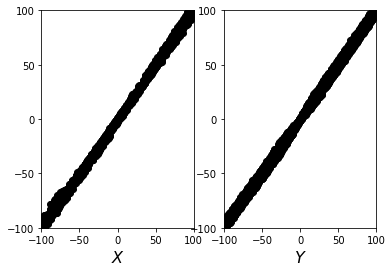

100%|██████████| 24/24 [00:00<00:00, 66.98it/s]

Epoch: 179 Train loss: 64.3118


Test loss: 63.1030


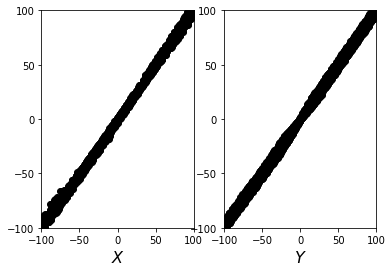

100%|██████████| 24/24 [00:00<00:00, 62.96it/s]

Epoch: 180 Train loss: 63.1269


Test loss: 61.6041


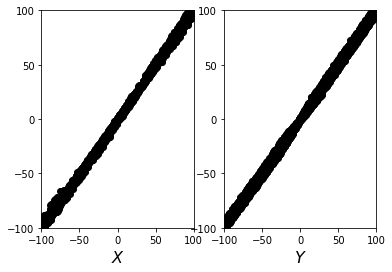

100%|██████████| 24/24 [00:00<00:00, 51.42it/s]

Epoch: 181 Train loss: 61.6035


Test loss: 60.0682


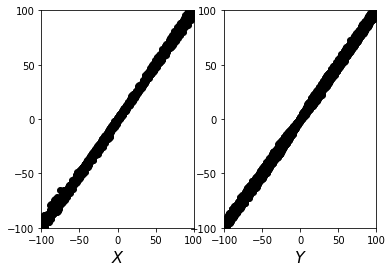

100%|██████████| 24/24 [00:00<00:00, 60.20it/s]


Epoch: 182 Train loss: 59.9962
Test loss: 58.5017


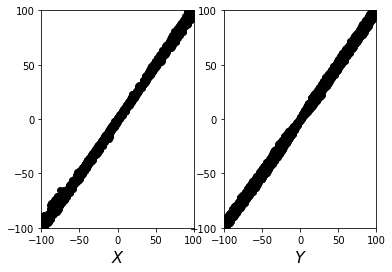

100%|██████████| 24/24 [00:00<00:00, 49.07it/s]

Epoch: 183 Train loss: 58.4870


Test loss: 57.0107


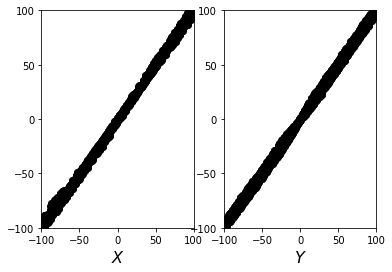

100%|██████████| 24/24 [00:00<00:00, 47.70it/s]

Epoch: 184 Train loss: 57.1104


Test loss: 55.7272


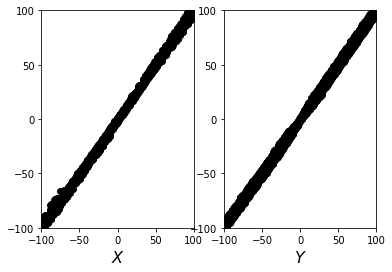

100%|██████████| 24/24 [00:00<00:00, 39.31it/s]

Epoch: 185 Train loss: 55.7496


Test loss: 54.4494


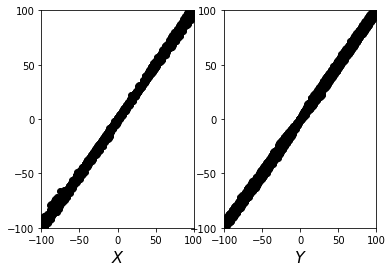

100%|██████████| 24/24 [00:00<00:00, 34.34it/s]

Epoch: 186 Train loss: 54.5042


Test loss: 53.3274


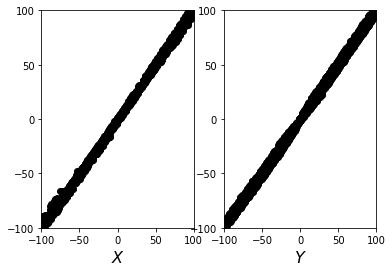

100%|██████████| 24/24 [00:00<00:00, 45.20it/s]


Epoch: 187 Train loss: 53.1779
Test loss: 52.1735


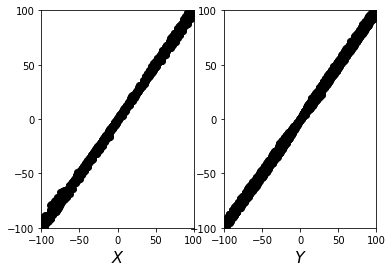

100%|██████████| 24/24 [00:00<00:00, 42.86it/s]

Epoch: 188 Train loss: 51.7887


Test loss: 50.6809


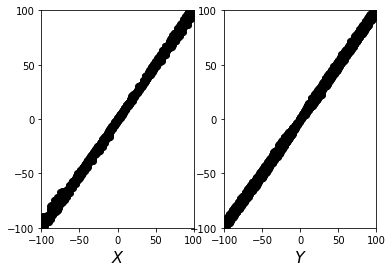

100%|██████████| 24/24 [00:00<00:00, 27.91it/s]

Epoch: 189 Train loss: 50.0499


Test loss: 49.5608


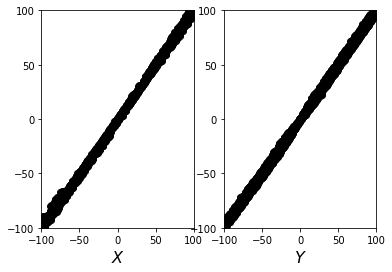

100%|██████████| 24/24 [00:00<00:00, 43.54it/s]

Epoch: 190 Train loss: 49.0110


Test loss: 48.1498


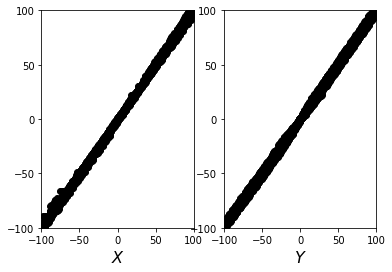

100%|██████████| 24/24 [00:00<00:00, 49.21it/s]

Epoch: 191 Train loss: 47.8036


Test loss: 46.8886


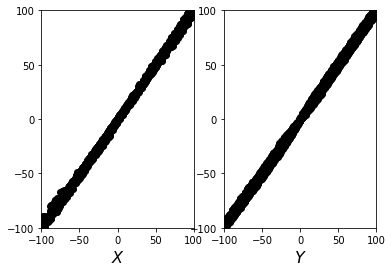

100%|██████████| 24/24 [00:00<00:00, 38.96it/s]

Epoch: 192 Train loss: 46.5595


Test loss: 45.5469


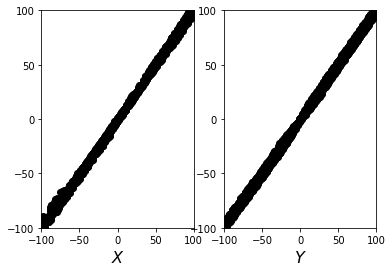

100%|██████████| 24/24 [00:00<00:00, 42.88it/s]

Epoch: 193 Train loss: 45.4581


Test loss: 44.2357


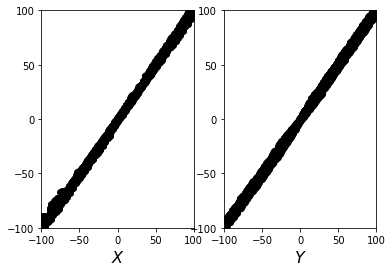

100%|██████████| 24/24 [00:00<00:00, 45.84it/s]

Epoch: 194 Train loss: 44.7992


Test loss: 43.4222


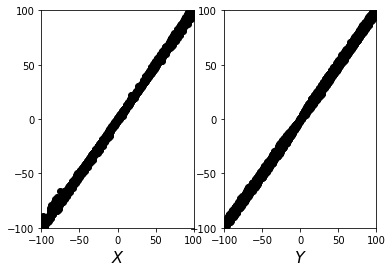

100%|██████████| 24/24 [00:00<00:00, 43.09it/s]

Epoch: 195 Train loss: 43.6597


Test loss: 42.1260


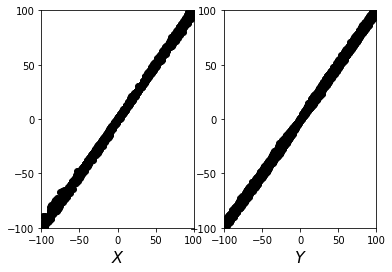

100%|██████████| 24/24 [00:00<00:00, 69.67it/s]

Epoch: 196 Train loss: 41.9717


Test loss: 41.0698


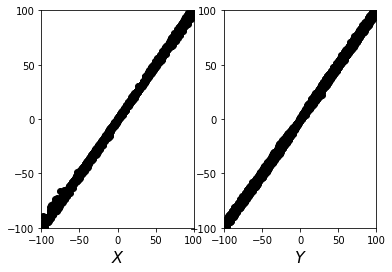

100%|██████████| 24/24 [00:00<00:00, 61.41it/s]

Epoch: 197 Train loss: 41.1131


Test loss: 40.0472


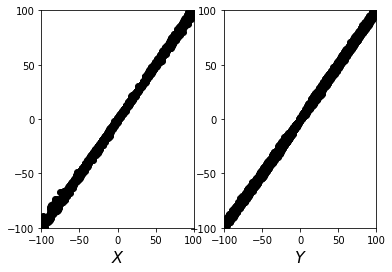

100%|██████████| 24/24 [00:00<00:00, 54.76it/s]

Epoch: 198 Train loss: 39.9459


Test loss: 39.0514


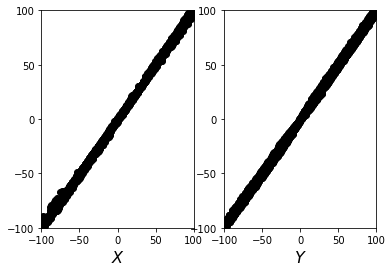

100%|██████████| 24/24 [00:00<00:00, 59.82it/s]

Epoch: 199 Train loss: 39.2955


Test loss: 37.9000


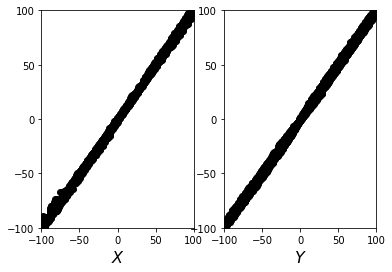

100%|██████████| 24/24 [00:00<00:00, 55.89it/s]

Epoch: 200 Train loss: 38.0574


Test loss: 37.1013


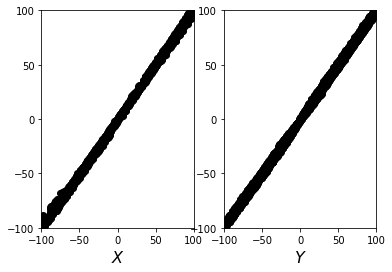

100%|██████████| 24/24 [00:00<00:00, 44.29it/s]


Epoch: 201 Train loss: 37.0315
Test loss: 36.1689


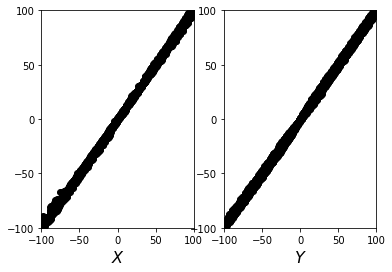

100%|██████████| 24/24 [00:00<00:00, 46.84it/s]

Epoch: 202 Train loss: 36.1914


Test loss: 35.4267


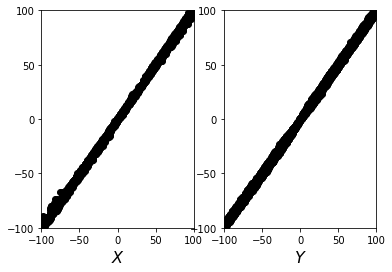

100%|██████████| 24/24 [00:00<00:00, 39.56it/s]

Epoch: 203 Train loss: 35.0683


Test loss: 34.3642


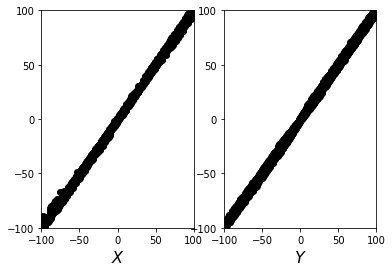

100%|██████████| 24/24 [00:00<00:00, 59.13it/s]

Epoch: 204 Train loss: 34.2081


Test loss: 33.5637


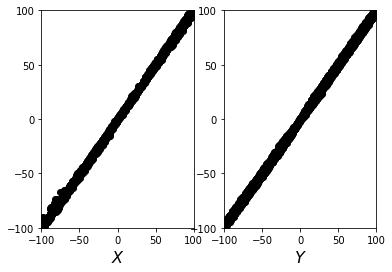

100%|██████████| 24/24 [00:00<00:00, 46.36it/s]

Epoch: 205 Train loss: 33.2701


Test loss: 32.6119


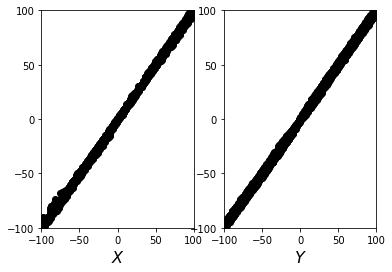

100%|██████████| 24/24 [00:00<00:00, 53.68it/s]

Epoch: 206 Train loss: 32.3056


Test loss: 31.9601


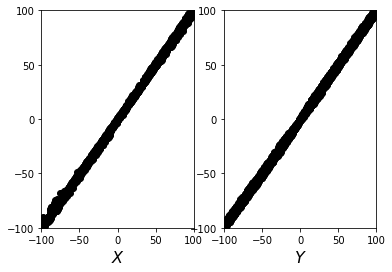

100%|██████████| 24/24 [00:00<00:00, 60.57it/s]

Epoch: 207 Train loss: 31.7139


Test loss: 31.0321


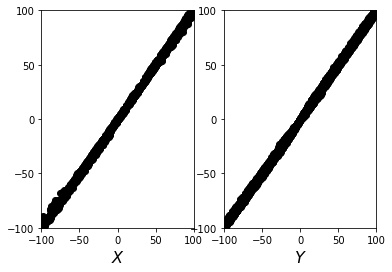

100%|██████████| 24/24 [00:00<00:00, 56.07it/s]

Epoch: 208 Train loss: 30.9197


Test loss: 30.6683


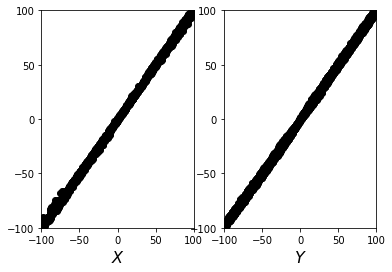

100%|██████████| 24/24 [00:00<00:00, 62.29it/s]

Epoch: 209 Train loss: 29.8395


Test loss: 29.3642


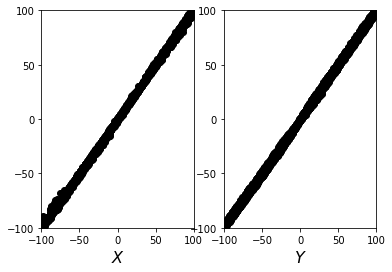

100%|██████████| 24/24 [00:00<00:00, 60.86it/s]

Epoch: 210 Train loss: 28.9971


Test loss: 28.5440


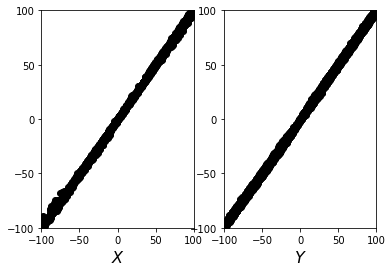

100%|██████████| 24/24 [00:00<00:00, 63.14it/s]

Epoch: 211 Train loss: 27.9998


Test loss: 28.3289


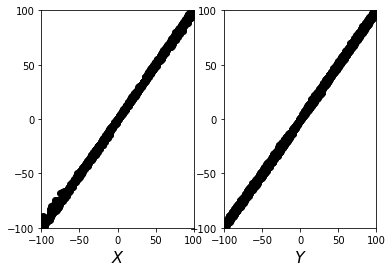

100%|██████████| 24/24 [00:00<00:00, 61.19it/s]

Epoch: 212 Train loss: 27.4995


Test loss: 27.3794


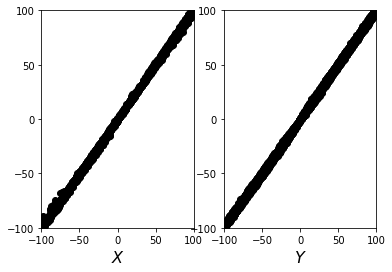

100%|██████████| 24/24 [00:00<00:00, 55.89it/s]

Epoch: 213 Train loss: 26.8056


Test loss: 26.7129


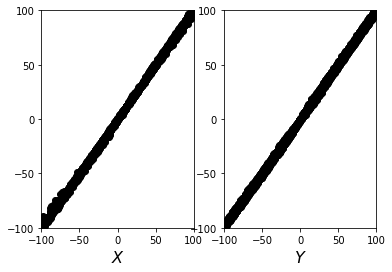

100%|██████████| 24/24 [00:00<00:00, 39.41it/s]

Epoch: 214 Train loss: 26.1701


Test loss: 25.9525


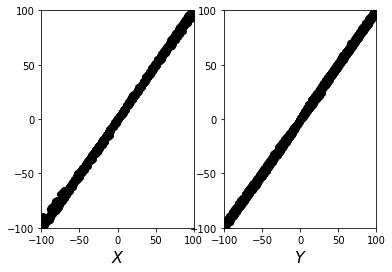

100%|██████████| 24/24 [00:00<00:00, 49.47it/s]

Epoch: 215 Train loss: 25.2764


Test loss: 25.0107


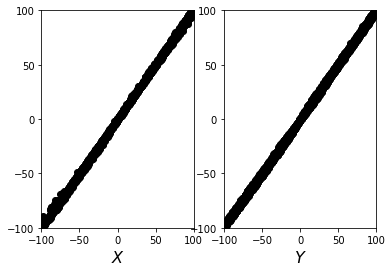

100%|██████████| 24/24 [00:00<00:00, 23.59it/s]

Epoch: 216 Train loss: 24.6263


Test loss: 24.4131


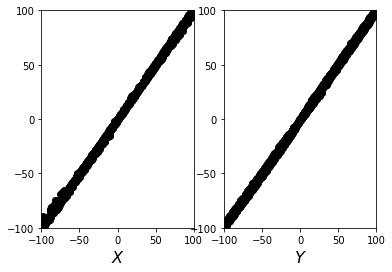

100%|██████████| 24/24 [00:00<00:00, 50.31it/s]

Epoch: 217 Train loss: 24.0406


Test loss: 23.9582


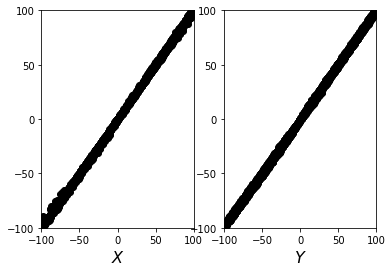

100%|██████████| 24/24 [00:00<00:00, 20.96it/s]

Epoch: 218 Train loss: 23.3489


Test loss: 23.4098


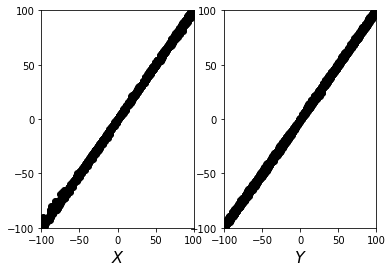

100%|██████████| 24/24 [00:00<00:00, 56.43it/s]

Epoch: 219 Train loss: 22.7545


Test loss: 22.9145


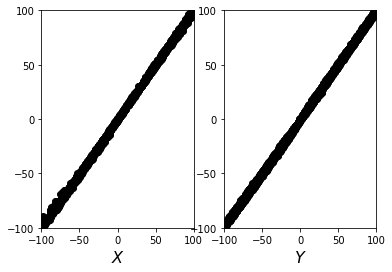

100%|██████████| 24/24 [00:00<00:00, 46.38it/s]

Epoch: 220 Train loss: 21.9768


Test loss: 22.0997


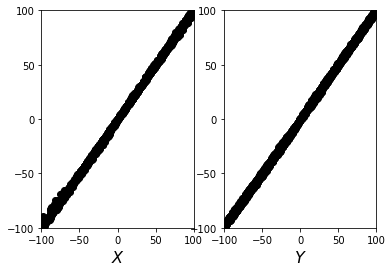

100%|██████████| 24/24 [00:00<00:00, 66.39it/s]

Epoch: 221 Train loss: 21.2947


Test loss: 21.7813


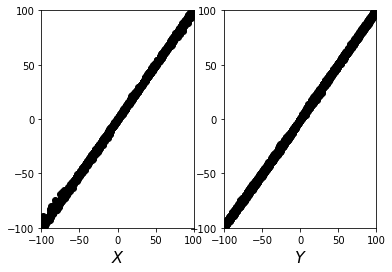

100%|██████████| 24/24 [00:00<00:00, 43.90it/s]

Epoch: 222 Train loss: 20.7987


Test loss: 21.0312


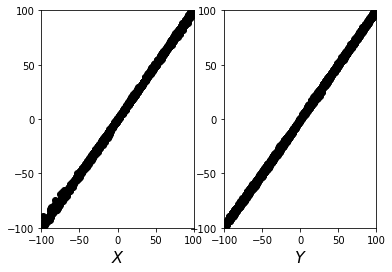

100%|██████████| 24/24 [00:00<00:00, 59.31it/s]

Epoch: 223 Train loss: 20.3967


Test loss: 20.6501


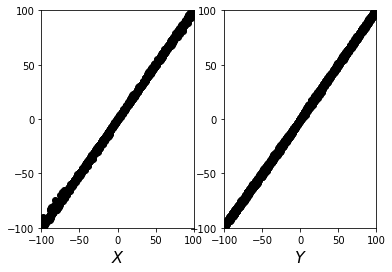

100%|██████████| 24/24 [00:00<00:00, 62.68it/s]

Epoch: 224 Train loss: 19.9606


Test loss: 19.9620


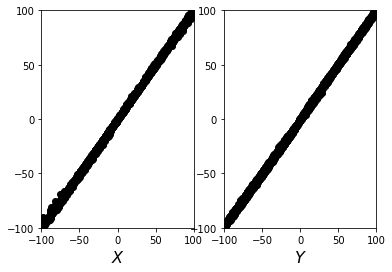

100%|██████████| 24/24 [00:00<00:00, 48.10it/s]

Epoch: 225 Train loss: 19.3722


Test loss: 19.3861


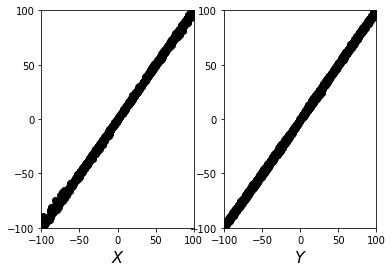

100%|██████████| 24/24 [00:00<00:00, 47.93it/s]

Epoch: 226 Train loss: 18.7770


Test loss: 19.0556


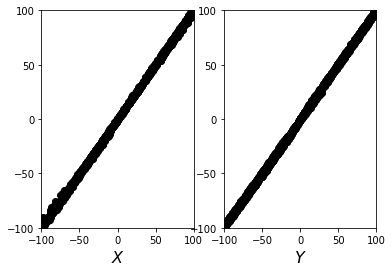

100%|██████████| 24/24 [00:00<00:00, 44.26it/s]

Epoch: 227 Train loss: 18.3968


Test loss: 18.7052


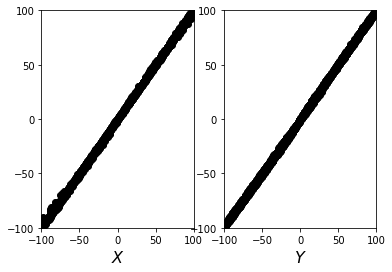

100%|██████████| 24/24 [00:00<00:00, 42.87it/s]

Epoch: 228 Train loss: 17.9444


Test loss: 18.2844


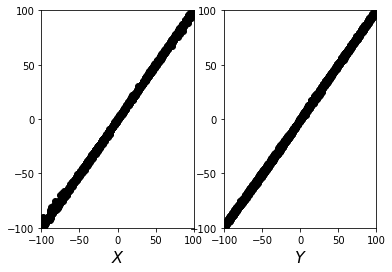

100%|██████████| 24/24 [00:00<00:00, 58.60it/s]

Epoch: 229 Train loss: 17.4113


Test loss: 17.5652


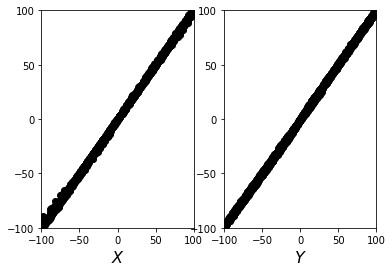

100%|██████████| 24/24 [00:00<00:00, 62.26it/s]

Epoch: 230 Train loss: 17.0185


Test loss: 17.3969


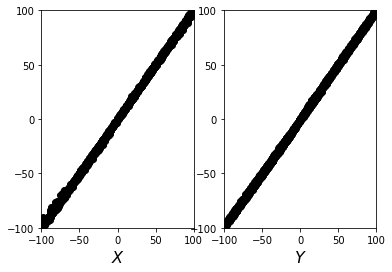

100%|██████████| 24/24 [00:00<00:00, 62.01it/s]

Epoch: 231 Train loss: 16.5372


Test loss: 16.7784


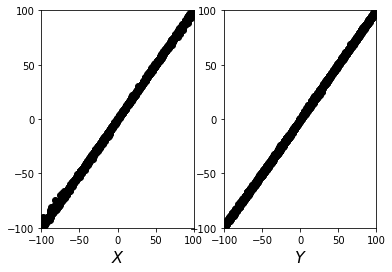

100%|██████████| 24/24 [00:00<00:00, 57.97it/s]

Epoch: 232 Train loss: 15.9652


Test loss: 16.4635


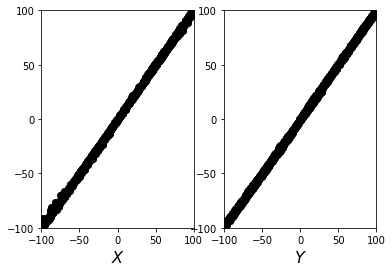

100%|██████████| 24/24 [00:00<00:00, 49.04it/s]

Epoch: 233 Train loss: 15.6476


Test loss: 15.9662


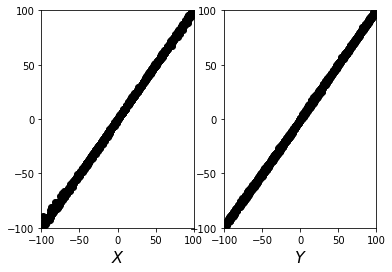

100%|██████████| 24/24 [00:00<00:00, 56.99it/s]

Epoch: 234 Train loss: 15.3327


Test loss: 15.6610


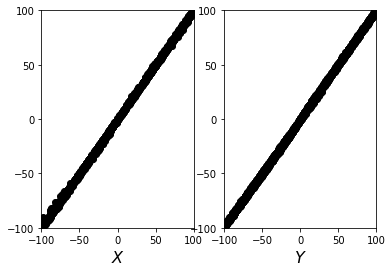

100%|██████████| 24/24 [00:00<00:00, 64.22it/s]

Epoch: 235 Train loss: 14.9158


Test loss: 15.3618


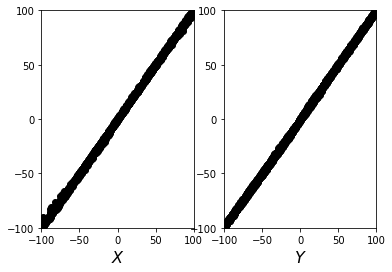

100%|██████████| 24/24 [00:00<00:00, 61.88it/s]

Epoch: 236 Train loss: 14.6410


Test loss: 14.8508


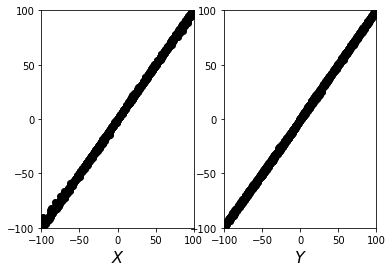

100%|██████████| 24/24 [00:00<00:00, 57.79it/s]

Epoch: 237 Train loss: 14.2230


Test loss: 14.5230


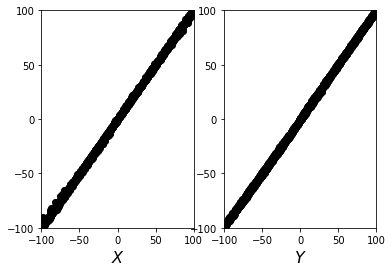

100%|██████████| 24/24 [00:00<00:00, 62.15it/s]

Epoch: 238 Train loss: 14.0273


Test loss: 14.0757


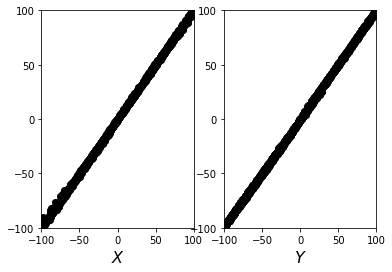

100%|██████████| 24/24 [00:00<00:00, 40.29it/s]

Epoch: 239 Train loss: 13.6398


Test loss: 13.8539


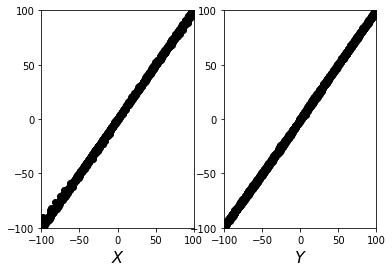

100%|██████████| 24/24 [00:00<00:00, 16.99it/s]

Epoch: 240 Train loss: 13.2808


Test loss: 13.4820


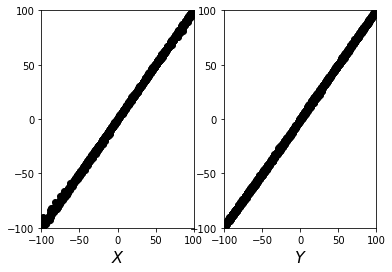

100%|██████████| 24/24 [00:00<00:00, 43.55it/s]

Epoch: 241 Train loss: 12.9620


Test loss: 13.2739


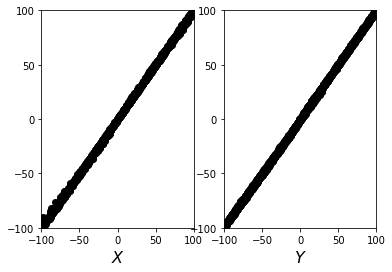

100%|██████████| 24/24 [00:00<00:00, 61.50it/s]

Epoch: 242 Train loss: 12.9388


Test loss: 12.7527


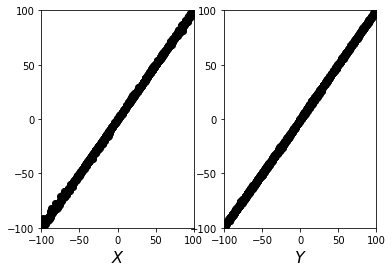

100%|██████████| 24/24 [00:00<00:00, 43.63it/s]

Epoch: 243 Train loss: 12.5749


Test loss: 12.6025


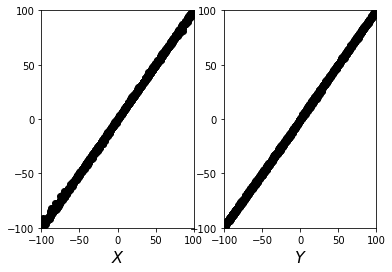

100%|██████████| 24/24 [00:00<00:00,  3.23it/s]

Epoch: 244 Train loss: 12.1344


Test loss: 12.4125


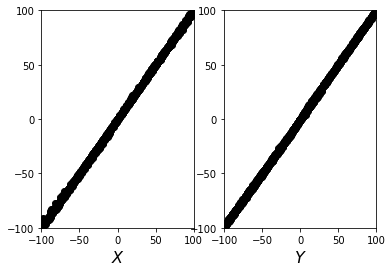

100%|██████████| 24/24 [00:00<00:00, 60.44it/s]

Epoch: 245 Train loss: 11.9932


Test loss: 12.2325


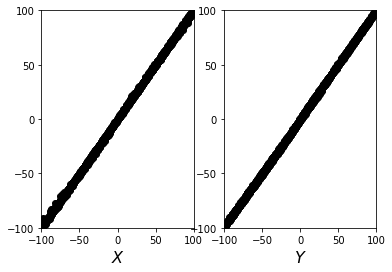

100%|██████████| 24/24 [00:00<00:00, 58.25it/s]

Epoch: 246 Train loss: 11.9064


Test loss: 11.8683


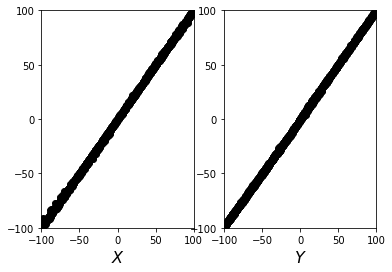

100%|██████████| 24/24 [00:00<00:00, 19.66it/s]

Epoch: 247 Train loss: 11.6953


Test loss: 11.4660


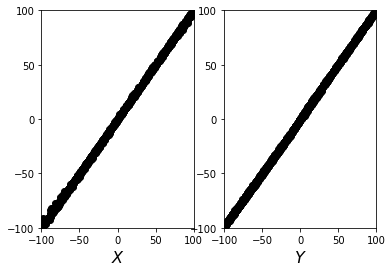

100%|██████████| 24/24 [00:00<00:00, 49.39it/s]

Epoch: 248 Train loss: 11.4156


Test loss: 11.5200


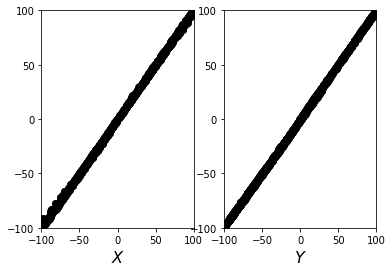

100%|██████████| 24/24 [00:00<00:00, 44.69it/s]

Epoch: 249 Train loss: 11.1058


Test loss: 11.1223


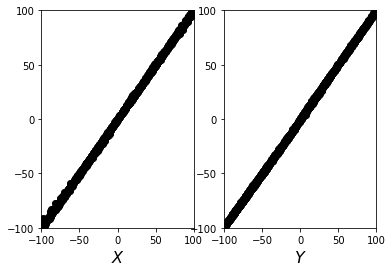

100%|██████████| 24/24 [00:00<00:00, 46.97it/s]

Epoch: 250 Train loss: 10.7883


Test loss: 11.0128


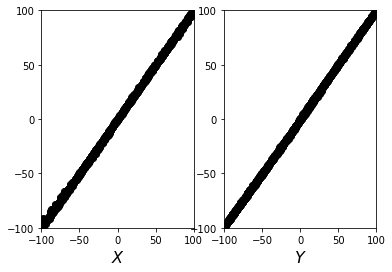

100%|██████████| 24/24 [00:00<00:00, 50.42it/s]

Epoch: 251 Train loss: 10.6595


Test loss: 10.9695


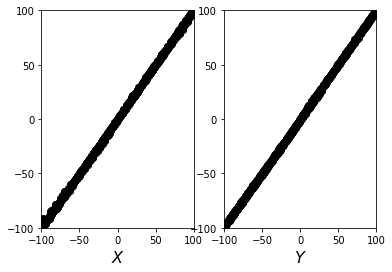

100%|██████████| 24/24 [00:00<00:00, 60.36it/s]

Epoch: 252 Train loss: 10.4437


Test loss: 10.5843


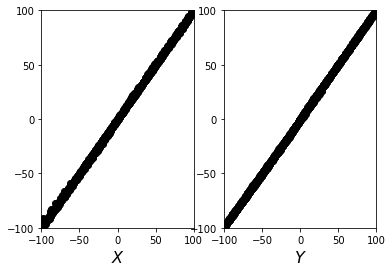

100%|██████████| 24/24 [00:00<00:00, 63.89it/s]

Epoch: 253 Train loss: 10.2244


Test loss: 10.2080


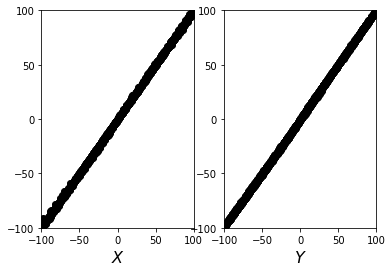

100%|██████████| 24/24 [00:00<00:00, 48.43it/s]

Epoch: 254 Train loss: 10.0643


Test loss: 10.0413


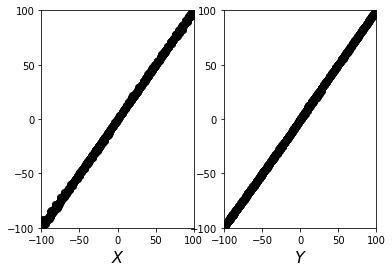

100%|██████████| 24/24 [00:00<00:00, 62.17it/s]

Epoch: 255 Train loss: 10.0473


Test loss: 10.2505


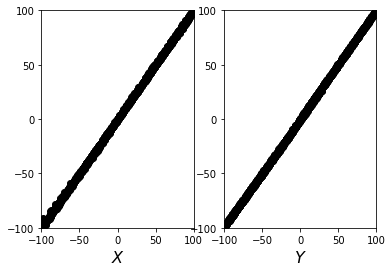

100%|██████████| 24/24 [00:00<00:00, 66.96it/s]

Epoch: 256 Train loss: 9.8104


Test loss: 9.9180


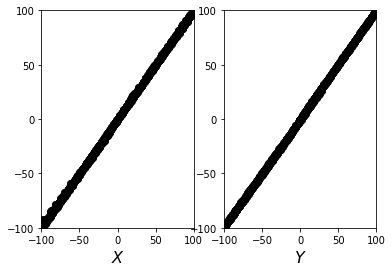

100%|██████████| 24/24 [00:00<00:00, 54.00it/s]

Epoch: 257 Train loss: 9.6680


Test loss: 9.6151


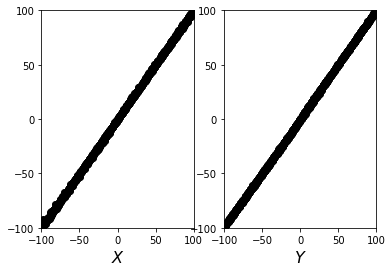

100%|██████████| 24/24 [00:00<00:00, 47.27it/s]

Epoch: 258 Train loss: 9.2881


Test loss: 9.4273


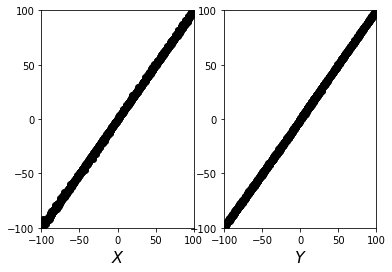

100%|██████████| 24/24 [00:00<00:00, 44.54it/s]

Epoch: 259 Train loss: 9.1348


Test loss: 9.6083


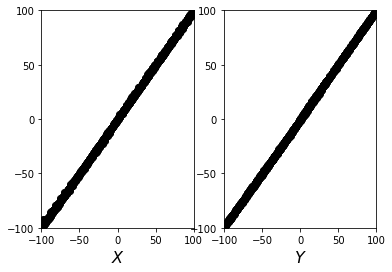

100%|██████████| 24/24 [00:00<00:00, 58.43it/s]

Epoch: 260 Train loss: 9.1196


Test loss: 9.6154


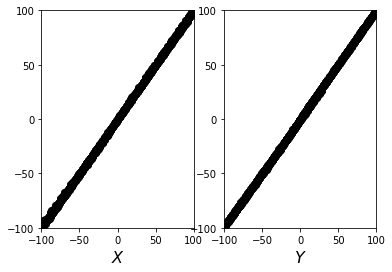

100%|██████████| 24/24 [00:00<00:00, 69.17it/s]

Epoch: 261 Train loss: 8.8126


Test loss: 9.1548


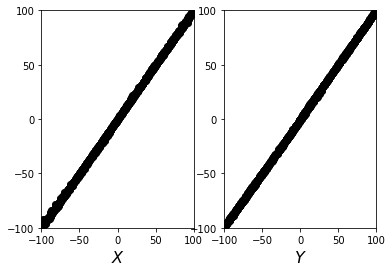

100%|██████████| 24/24 [00:00<00:00, 53.00it/s]

Epoch: 262 Train loss: 8.8547


Test loss: 9.2451


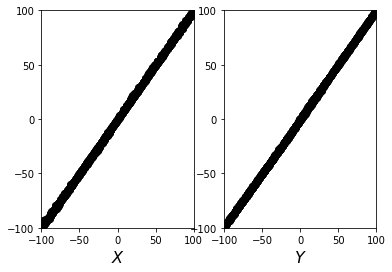

100%|██████████| 24/24 [00:00<00:00, 48.29it/s]

Epoch: 263 Train loss: 8.6979


Test loss: 8.8092


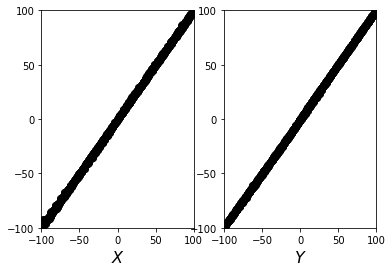

100%|██████████| 24/24 [00:00<00:00, 52.44it/s]

Epoch: 264 Train loss: 8.4489


Test loss: 8.6789


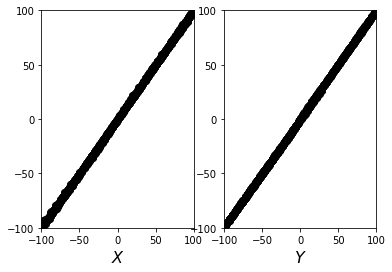

100%|██████████| 24/24 [00:00<00:00, 58.88it/s]

Epoch: 265 Train loss: 8.2529


Test loss: 8.7931


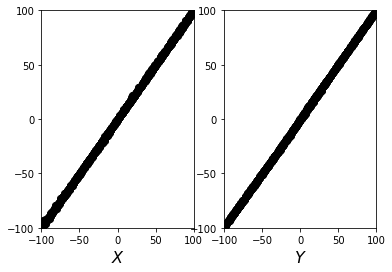

100%|██████████| 24/24 [00:00<00:00, 63.18it/s]

Epoch: 266 Train loss: 8.2545


Test loss: 8.8577


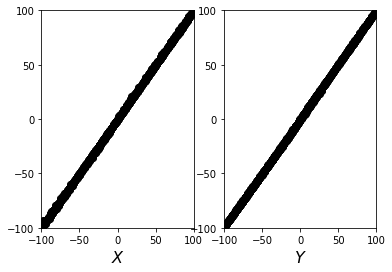

100%|██████████| 24/24 [00:00<00:00, 55.70it/s]

Epoch: 267 Train loss: 8.2642


Test loss: 8.6076


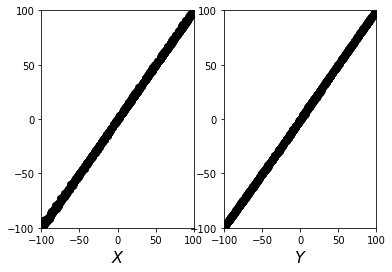

100%|██████████| 24/24 [00:00<00:00, 62.78it/s]

Epoch: 268 Train loss: 8.0207


Test loss: 8.1911


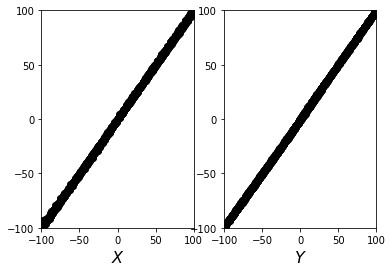

100%|██████████| 24/24 [00:00<00:00, 22.29it/s]

Epoch: 269 Train loss: 7.9143


Test loss: 8.2590


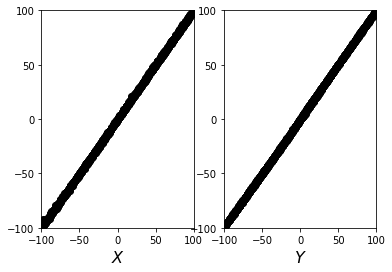

100%|██████████| 24/24 [00:00<00:00, 55.74it/s]

Epoch: 270 Train loss: 7.7313


Test loss: 8.4705


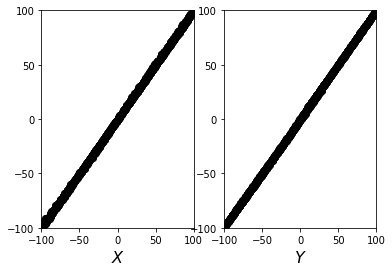

100%|██████████| 24/24 [00:00<00:00, 55.19it/s]

Epoch: 271 Train loss: 7.7167


Test loss: 8.2030


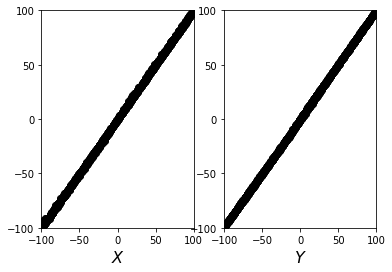

100%|██████████| 24/24 [00:00<00:00, 45.34it/s]

Epoch: 272 Train loss: 7.5628


Test loss: 8.1288


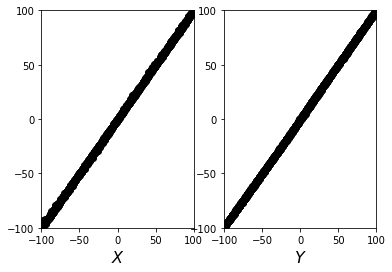

100%|██████████| 24/24 [00:00<00:00, 60.58it/s]

Epoch: 273 Train loss: 7.5495


Test loss: 7.7821


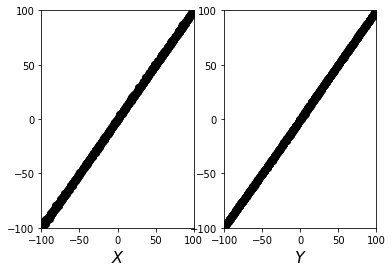

100%|██████████| 24/24 [00:00<00:00, 64.05it/s]

Epoch: 274 Train loss: 7.4233


Test loss: 7.8663


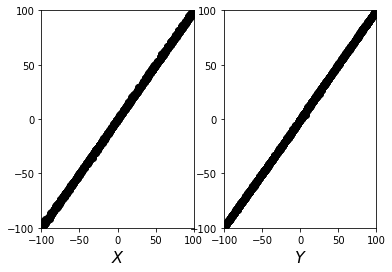

100%|██████████| 24/24 [00:00<00:00, 54.38it/s]

Epoch: 275 Train loss: 7.2206


Test loss: 7.5220


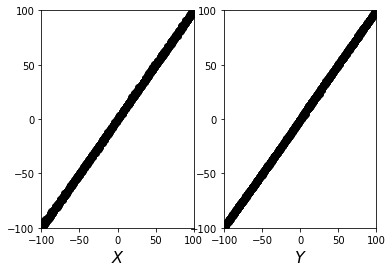

100%|██████████| 24/24 [00:00<00:00, 61.12it/s]

Epoch: 276 Train loss: 7.2300


Test loss: 7.4692


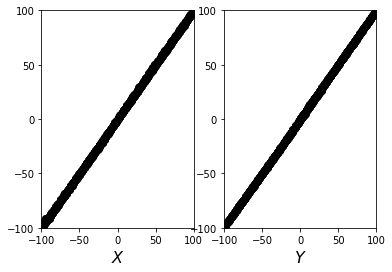

100%|██████████| 24/24 [00:00<00:00, 64.96it/s]

Epoch: 277 Train loss: 7.2117


Test loss: 7.6143


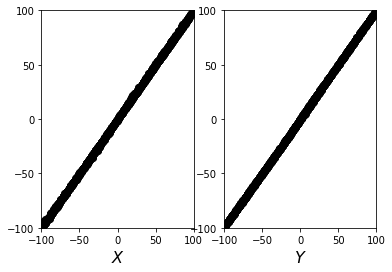

100%|██████████| 24/24 [00:00<00:00, 48.66it/s]

Epoch: 278 Train loss: 7.0632


Test loss: 7.5724


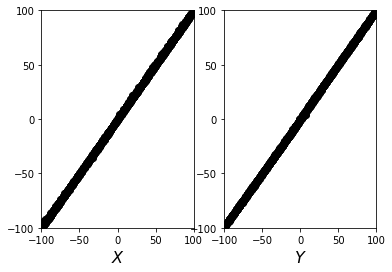

100%|██████████| 24/24 [00:00<00:00, 53.96it/s]

Epoch: 279 Train loss: 6.9389


Test loss: 7.1746


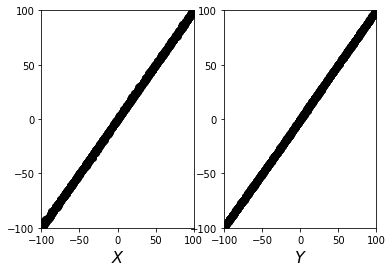

100%|██████████| 24/24 [00:00<00:00, 46.43it/s]

Epoch: 280 Train loss: 6.8181


Test loss: 7.3733


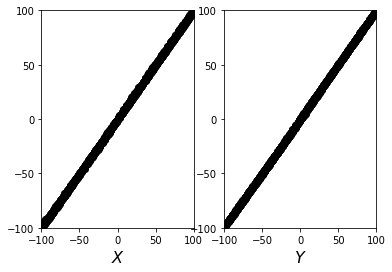

100%|██████████| 24/24 [00:00<00:00, 53.67it/s]

Epoch: 281 Train loss: 6.9763


Test loss: 7.5708


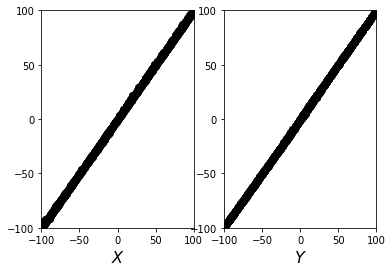

100%|██████████| 24/24 [00:00<00:00, 52.82it/s]

Epoch: 282 Train loss: 6.7876


Test loss: 7.0533


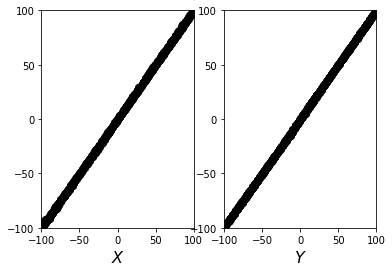

100%|██████████| 24/24 [00:00<00:00, 18.75it/s]

Epoch: 283 Train loss: 6.8479


Test loss: 7.5277


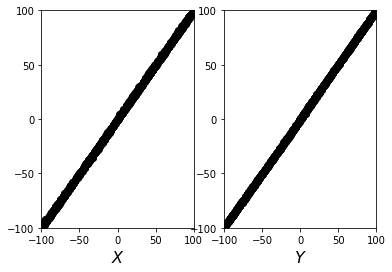

100%|██████████| 24/24 [00:00<00:00, 70.02it/s]

Epoch: 284 Train loss: 6.7140


Test loss: 6.9148


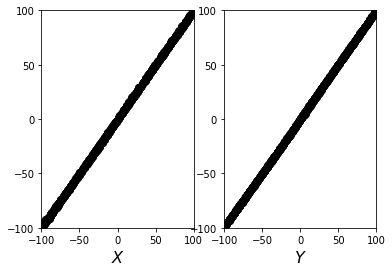

100%|██████████| 24/24 [00:00<00:00, 47.19it/s]

Epoch: 285 Train loss: 6.5396


Test loss: 7.0243


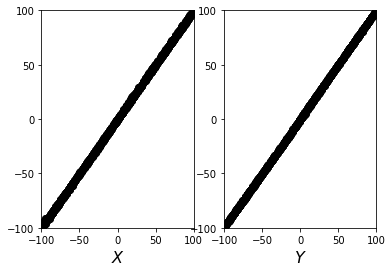

100%|██████████| 24/24 [00:00<00:00, 64.39it/s]

Epoch: 286 Train loss: 6.4840


Test loss: 6.9163


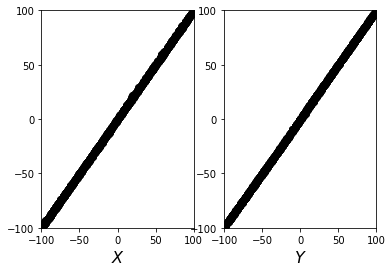

100%|██████████| 24/24 [00:00<00:00, 55.30it/s]

Epoch: 287 Train loss: 6.4405


Test loss: 6.5744


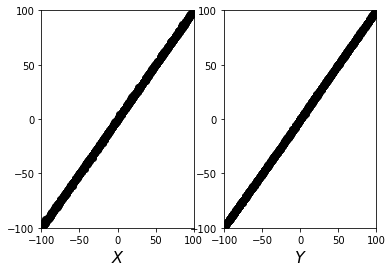

100%|██████████| 24/24 [00:00<00:00, 60.68it/s]

Epoch: 288 Train loss: 6.2792


Test loss: 6.5760


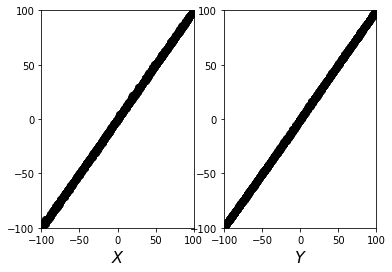

100%|██████████| 24/24 [00:00<00:00, 57.00it/s]


Epoch: 289 Train loss: 6.4345
Test loss: 6.4944


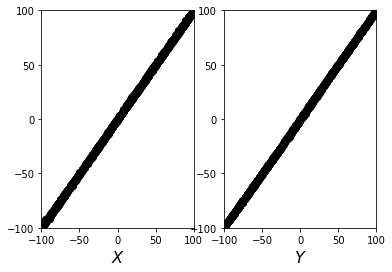

100%|██████████| 24/24 [00:00<00:00, 51.24it/s]

Epoch: 290 Train loss: 6.2199


Test loss: 6.3494


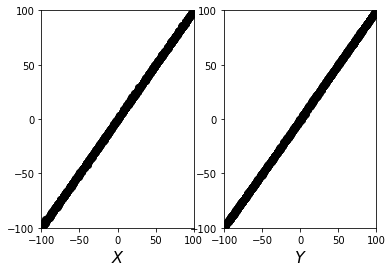

100%|██████████| 24/24 [00:00<00:00, 57.69it/s]

Epoch: 291 Train loss: 6.2160


Test loss: 6.5252


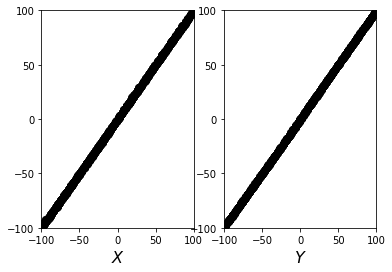

100%|██████████| 24/24 [00:00<00:00, 46.71it/s]

Epoch: 292 Train loss: 6.1952


Test loss: 6.2813


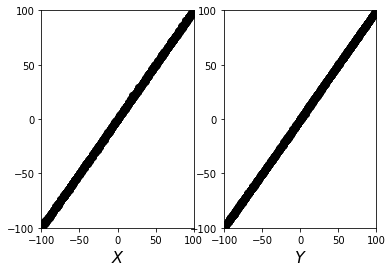

100%|██████████| 24/24 [00:00<00:00, 51.48it/s]

Epoch: 293 Train loss: 6.2350


Test loss: 6.6371


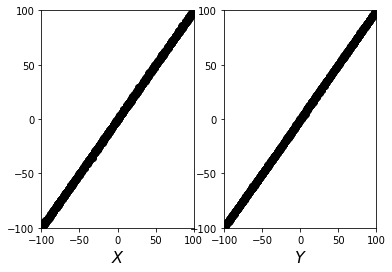

100%|██████████| 24/24 [00:00<00:00, 46.79it/s]

Epoch: 294 Train loss: 6.0495


Test loss: 6.0880


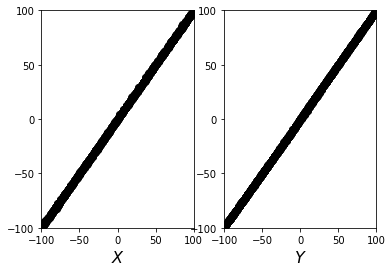

100%|██████████| 24/24 [00:00<00:00, 60.15it/s]

Epoch: 295 Train loss: 6.1692


Test loss: 6.1714


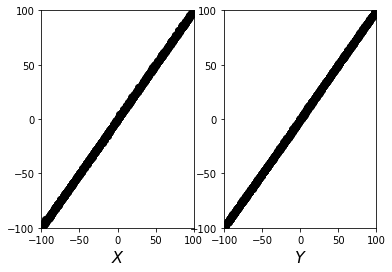

100%|██████████| 24/24 [00:00<00:00, 64.15it/s]

Epoch: 296 Train loss: 6.0517


Test loss: 6.1830


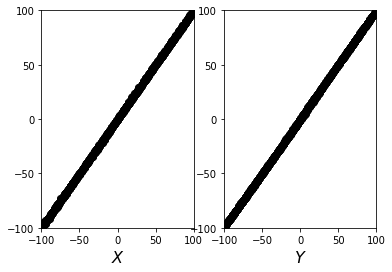

100%|██████████| 24/24 [00:00<00:00, 56.84it/s]


Epoch: 297 Train loss: 5.9603
Test loss: 6.5609


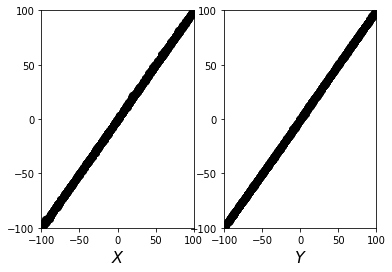

100%|██████████| 24/24 [00:00<00:00, 51.17it/s]

Epoch: 298 Train loss: 6.1259


Test loss: 6.3793


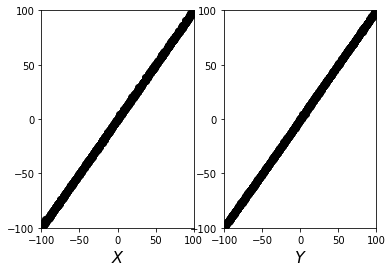

100%|██████████| 24/24 [00:00<00:00, 48.37it/s]

Epoch: 299 Train loss: 5.9865


Test loss: 6.3024


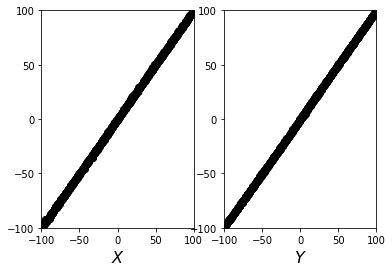

100%|██████████| 24/24 [00:00<00:00, 44.83it/s]

Epoch: 300 Train loss: 5.9902


Test loss: 6.2430


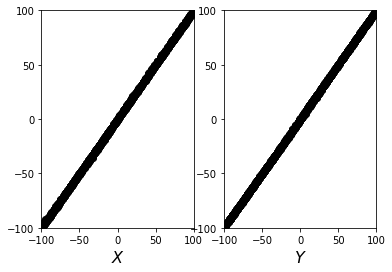

100%|██████████| 24/24 [00:00<00:00, 53.63it/s]

Epoch: 301 Train loss: 5.8455


Test loss: 6.1131


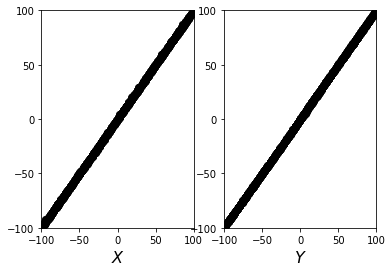

100%|██████████| 24/24 [00:00<00:00, 20.43it/s]

Epoch: 302 Train loss: 5.9004


Test loss: 6.0697


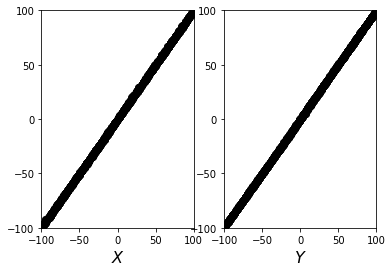

100%|██████████| 24/24 [00:00<00:00, 50.89it/s]

Epoch: 303 Train loss: 5.9666


Test loss: 6.3498


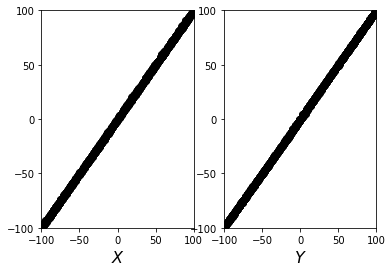

100%|██████████| 24/24 [00:00<00:00, 45.16it/s]

Epoch: 304 Train loss: 5.7555


Test loss: 5.8314


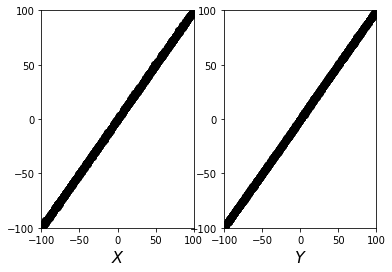

100%|██████████| 24/24 [00:00<00:00, 58.72it/s]

Epoch: 305 Train loss: 5.9312


Test loss: 5.9761


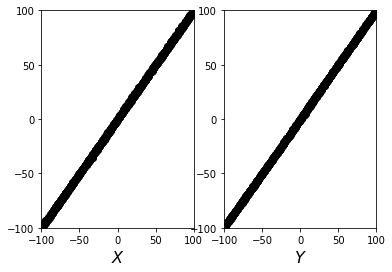

100%|██████████| 24/24 [00:00<00:00, 54.58it/s]

Epoch: 306 Train loss: 5.5805


Test loss: 5.6895


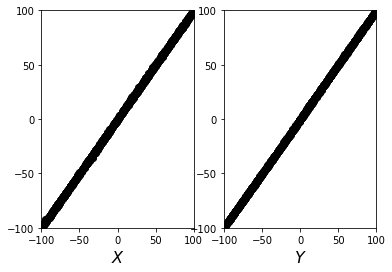

100%|██████████| 24/24 [00:00<00:00, 56.95it/s]


Epoch: 307 Train loss: 5.5677
Test loss: 5.5871


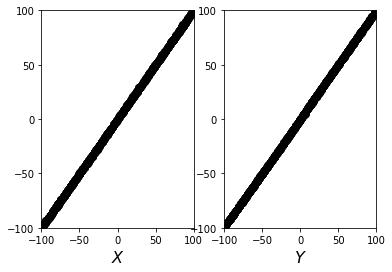

100%|██████████| 24/24 [00:00<00:00, 69.69it/s]

Epoch: 308 Train loss: 5.6685


Test loss: 5.7226


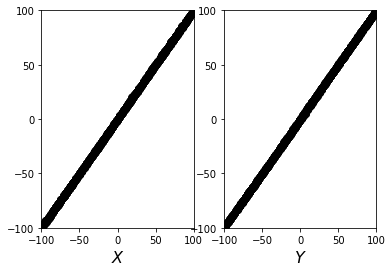

100%|██████████| 24/24 [00:00<00:00, 63.32it/s]

Epoch: 309 Train loss: 5.5873


Test loss: 5.4697


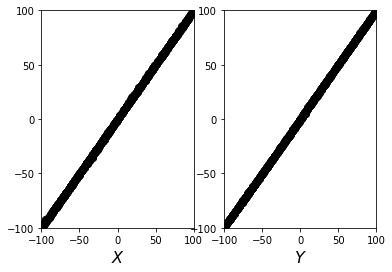

100%|██████████| 24/24 [00:00<00:00, 60.69it/s]

Epoch: 310 Train loss: 5.4996


Test loss: 5.5582


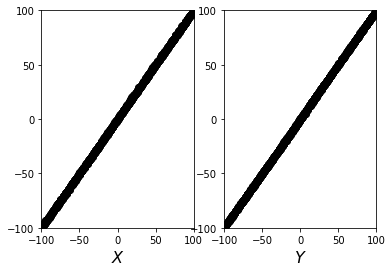

100%|██████████| 24/24 [00:01<00:00, 20.60it/s]

Epoch: 311 Train loss: 5.4958


Test loss: 5.6999


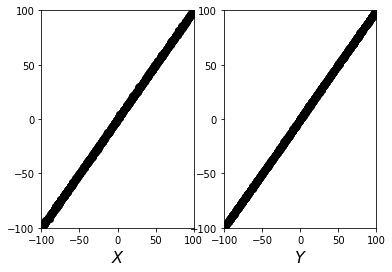

100%|██████████| 24/24 [00:00<00:00, 45.90it/s]

Epoch: 312 Train loss: 5.6237


Test loss: 5.8390


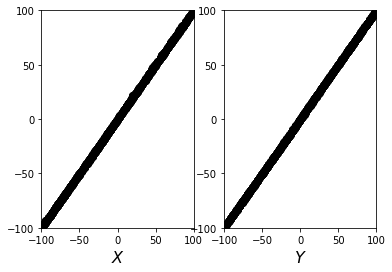

100%|██████████| 24/24 [00:00<00:00, 53.47it/s]

Epoch: 313 Train loss: 5.3691


Test loss: 5.4212


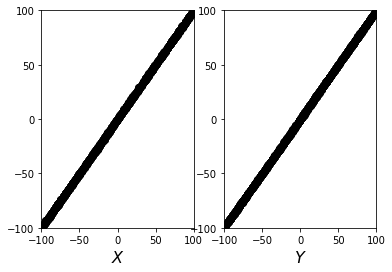

100%|██████████| 24/24 [00:00<00:00, 47.60it/s]

Epoch: 314 Train loss: 5.3080


Test loss: 5.5598


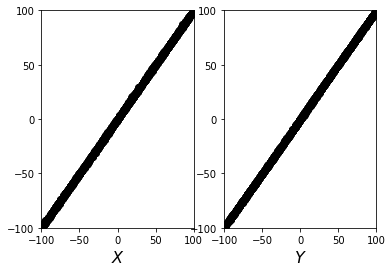

100%|██████████| 24/24 [00:00<00:00, 39.19it/s]

Epoch: 315 Train loss: 5.4347


Test loss: 5.5236


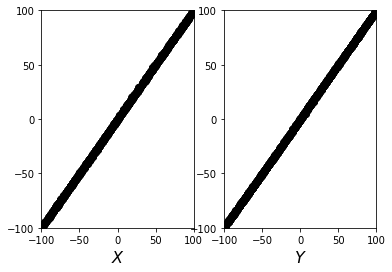

100%|██████████| 24/24 [00:00<00:00, 57.86it/s]

Epoch: 316 Train loss: 5.1693


Test loss: 5.2376


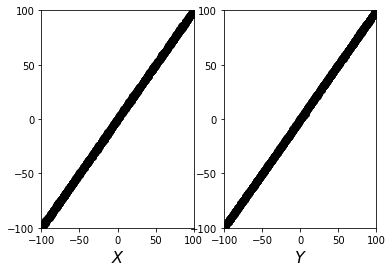

100%|██████████| 24/24 [00:00<00:00, 58.86it/s]

Epoch: 317 Train loss: 5.2037


Test loss: 5.3828


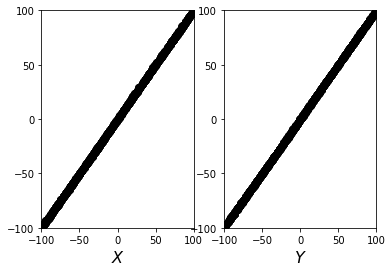

100%|██████████| 24/24 [00:00<00:00, 56.61it/s]

Epoch: 318 Train loss: 5.2638


Test loss: 5.4723


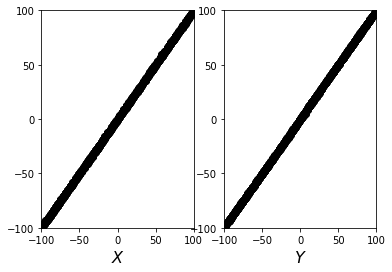

100%|██████████| 24/24 [00:00<00:00, 60.49it/s]

Epoch: 319 Train loss: 5.2092


Test loss: 4.8469


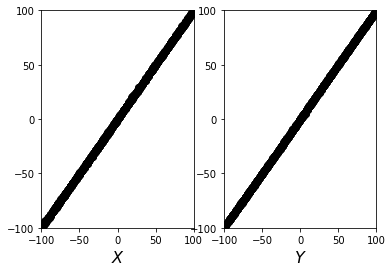

100%|██████████| 24/24 [00:00<00:00, 58.41it/s]

Epoch: 320 Train loss: 5.0196


Test loss: 5.3274


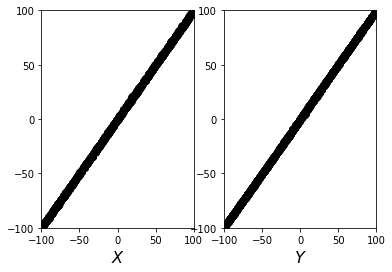

100%|██████████| 24/24 [00:00<00:00, 61.59it/s]

Epoch: 321 Train loss: 5.1164


Test loss: 4.8123


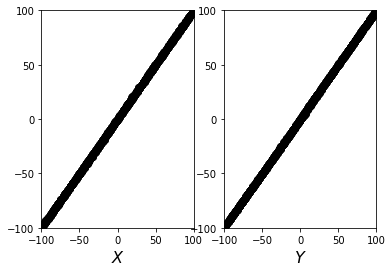

100%|██████████| 24/24 [00:00<00:00, 68.74it/s]

Epoch: 322 Train loss: 4.9186


Test loss: 5.0751


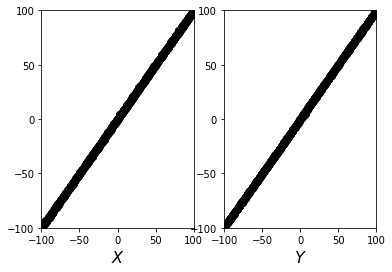

100%|██████████| 24/24 [00:00<00:00, 61.15it/s]

Epoch: 323 Train loss: 5.0194


Test loss: 5.0830


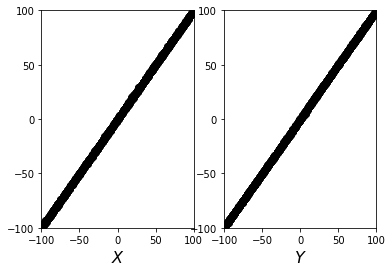

100%|██████████| 24/24 [00:00<00:00, 33.78it/s]

Epoch: 324 Train loss: 5.1328


Test loss: 5.0403


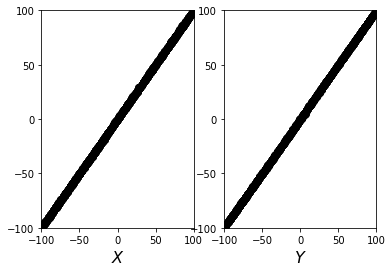

100%|██████████| 24/24 [00:00<00:00, 41.98it/s]

Epoch: 325 Train loss: 4.9881


Test loss: 5.0927


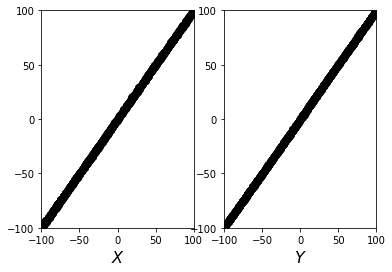

100%|██████████| 24/24 [00:00<00:00, 53.95it/s]

Epoch: 326 Train loss: 5.0018


Test loss: 4.8637


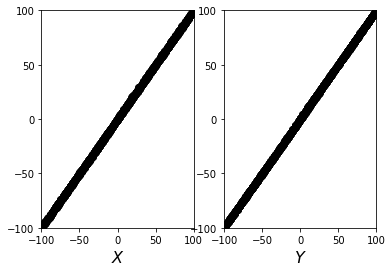

100%|██████████| 24/24 [00:00<00:00, 49.58it/s]

Epoch: 327 Train loss: 4.9551


Test loss: 4.8742


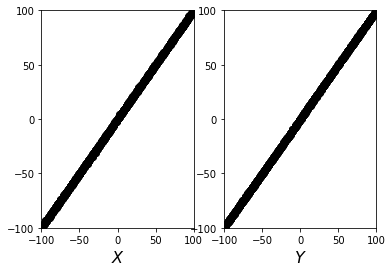

100%|██████████| 24/24 [00:00<00:00, 22.64it/s]

Epoch: 328 Train loss: 5.0187


Test loss: 5.1490


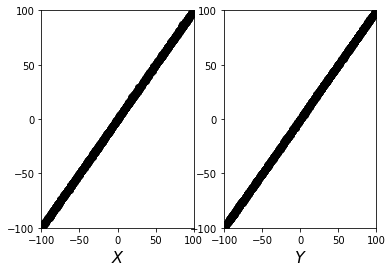

100%|██████████| 24/24 [00:00<00:00, 59.90it/s]

Epoch: 329 Train loss: 4.9484


Test loss: 4.9267


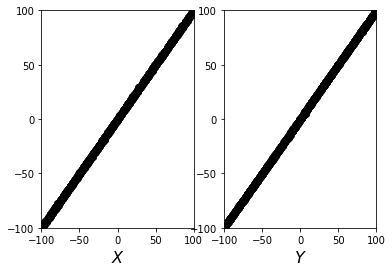

100%|██████████| 24/24 [00:00<00:00, 61.17it/s]

Epoch: 330 Train loss: 4.8276


Test loss: 4.9117


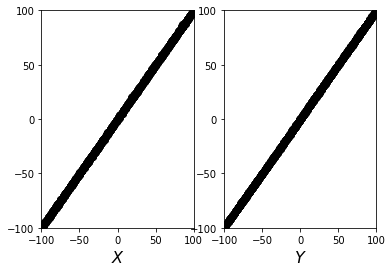

100%|██████████| 24/24 [00:00<00:00, 66.97it/s]

Epoch: 331 Train loss: 4.8137


Test loss: 4.7406


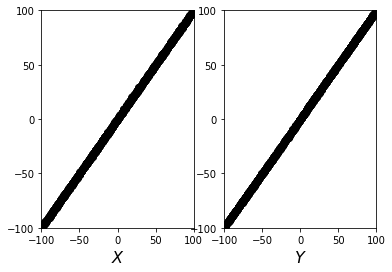

100%|██████████| 24/24 [00:00<00:00, 43.11it/s]

Epoch: 332 Train loss: 4.8777


Test loss: 5.3131


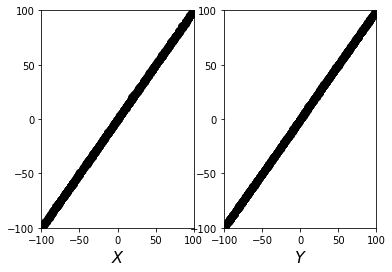

100%|██████████| 24/24 [00:00<00:00, 40.15it/s]

Epoch: 333 Train loss: 4.8015


Test loss: 4.6531


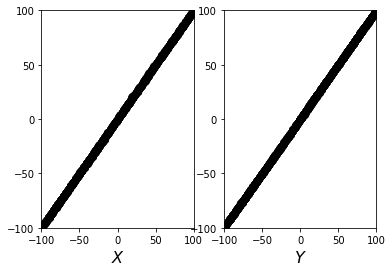

100%|██████████| 24/24 [00:00<00:00, 59.88it/s]

Epoch: 334 Train loss: 4.7169


Test loss: 4.5660


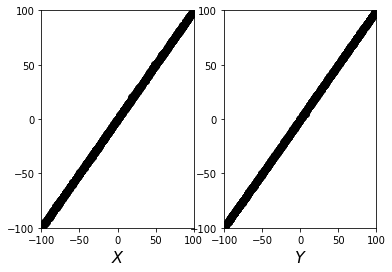

100%|██████████| 24/24 [00:00<00:00, 20.48it/s]

Epoch: 335 Train loss: 4.6600


Test loss: 4.7349


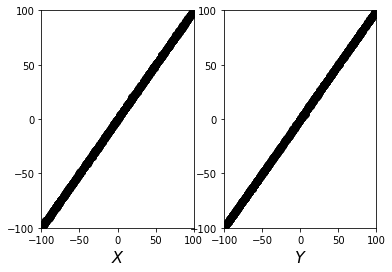

100%|██████████| 24/24 [00:00<00:00, 37.26it/s]

Epoch: 336 Train loss: 4.7855


Test loss: 4.6615


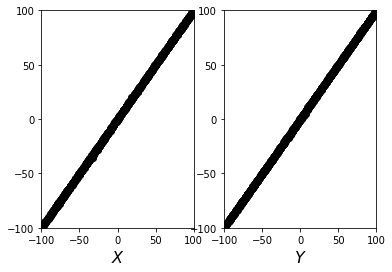

100%|██████████| 24/24 [00:00<00:00, 36.49it/s]

Epoch: 337 Train loss: 4.6501


Test loss: 4.6249


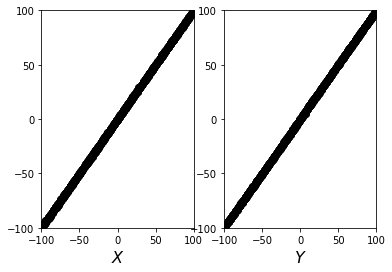

100%|██████████| 24/24 [00:00<00:00, 45.84it/s]

Epoch: 338 Train loss: 4.7006


Test loss: 4.4687


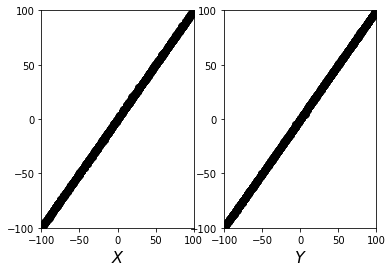

100%|██████████| 24/24 [00:00<00:00, 46.79it/s]

Epoch: 339 Train loss: 4.6429


Test loss: 4.5591


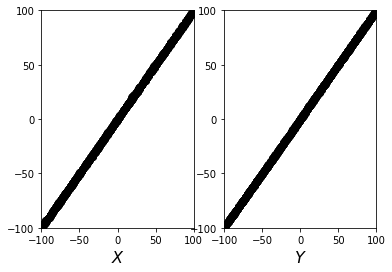

100%|██████████| 24/24 [00:00<00:00, 43.23it/s]

Epoch: 340 Train loss: 4.6541


Test loss: 4.6255


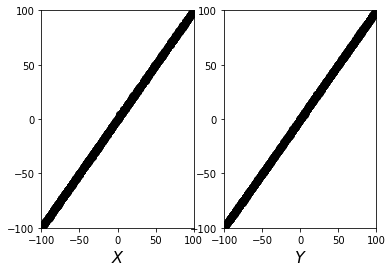

100%|██████████| 24/24 [00:00<00:00, 54.70it/s]

Epoch: 341 Train loss: 4.5818


Test loss: 4.6382


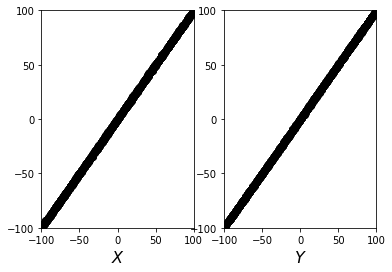

100%|██████████| 24/24 [00:00<00:00, 62.72it/s]

Epoch: 342 Train loss: 4.7029


Test loss: 4.7048


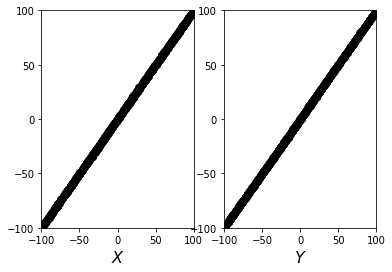

100%|██████████| 24/24 [00:00<00:00, 62.73it/s]

Epoch: 343 Train loss: 4.5726


Test loss: 4.6692


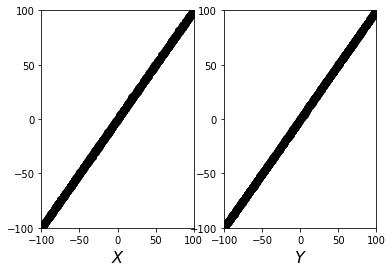

100%|██████████| 24/24 [00:00<00:00, 60.32it/s]

Epoch: 344 Train loss: 4.4667


Test loss: 4.7602


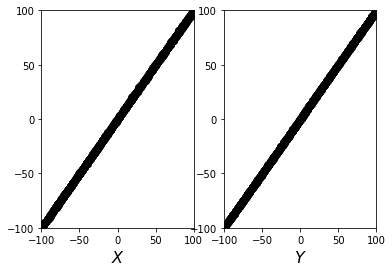

100%|██████████| 24/24 [00:00<00:00, 58.07it/s]

Epoch: 345 Train loss: 4.5803


Test loss: 4.4851


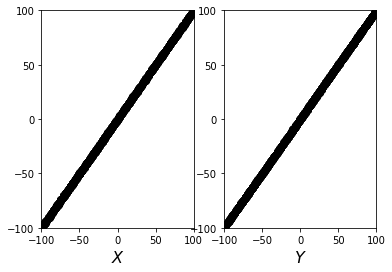

100%|██████████| 24/24 [00:00<00:00, 60.99it/s]

Epoch: 346 Train loss: 4.5196


Test loss: 4.4011


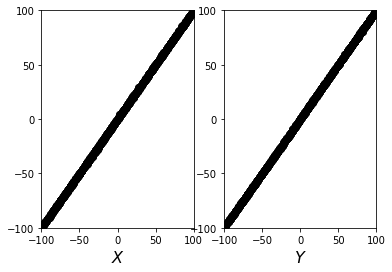

100%|██████████| 24/24 [00:00<00:00, 57.52it/s]

Epoch: 347 Train loss: 4.3550


Test loss: 4.1929


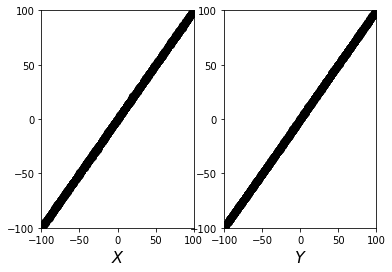

100%|██████████| 24/24 [00:00<00:00, 52.29it/s]

Epoch: 348 Train loss: 4.2826


Test loss: 4.2897


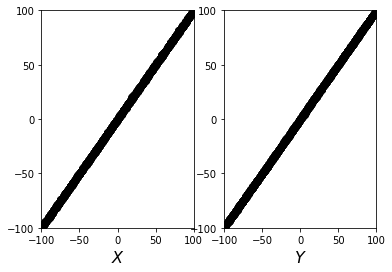

100%|██████████| 24/24 [00:00<00:00, 18.59it/s]

Epoch: 349 Train loss: 4.2255


Test loss: 4.2882


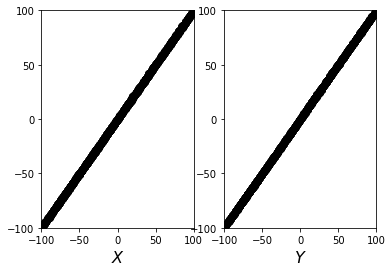

100%|██████████| 24/24 [00:00<00:00, 43.38it/s]

Epoch: 350 Train loss: 4.3133


Test loss: 4.2098


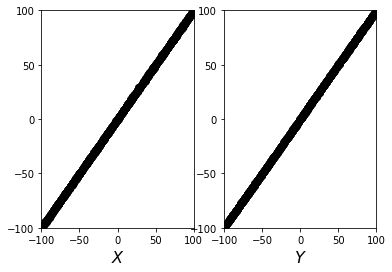

100%|██████████| 24/24 [00:00<00:00, 38.15it/s]

Epoch: 351 Train loss: 4.2097


Test loss: 4.3560


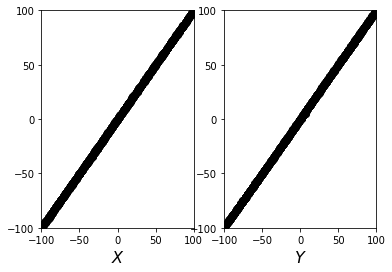

100%|██████████| 24/24 [00:00<00:00, 38.98it/s]

Epoch: 352 Train loss: 4.2265


Test loss: 3.9416


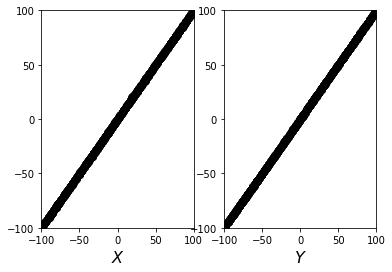

100%|██████████| 24/24 [00:00<00:00, 43.04it/s]

Epoch: 353 Train loss: 4.1572


Test loss: 4.0908


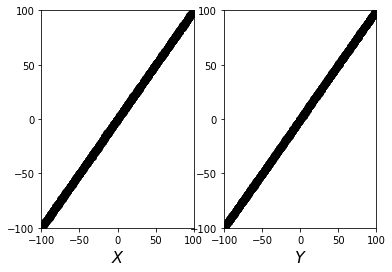

100%|██████████| 24/24 [00:00<00:00, 46.30it/s]

Epoch: 354 Train loss: 4.1198


Test loss: 4.3280


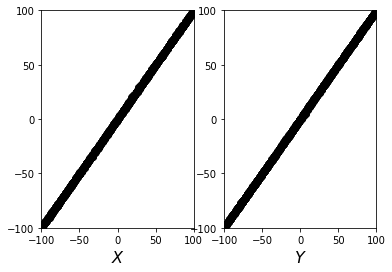

100%|██████████| 24/24 [00:00<00:00, 59.54it/s]


Epoch: 355 Train loss: 4.3376
Test loss: 4.2187


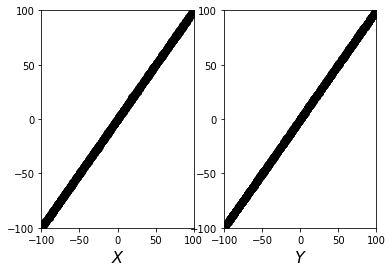

100%|██████████| 24/24 [00:00<00:00, 61.60it/s]

Epoch: 356 Train loss: 4.1900


Test loss: 3.9220


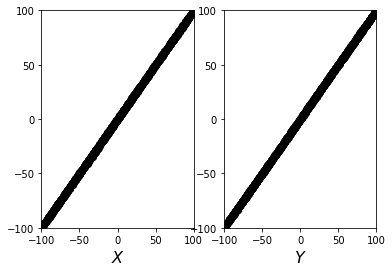

100%|██████████| 24/24 [00:00<00:00, 62.61it/s]

Epoch: 357 Train loss: 4.2460


Test loss: 4.2480


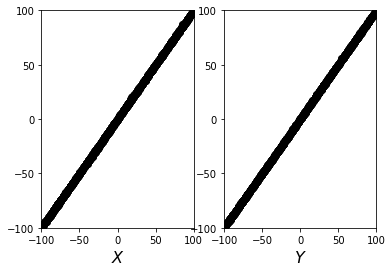

100%|██████████| 24/24 [00:00<00:00, 56.51it/s]


Epoch: 358 Train loss: 4.2187
Test loss: 4.1169


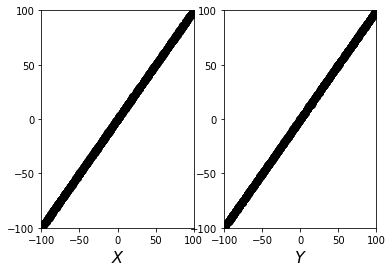

100%|██████████| 24/24 [00:00<00:00, 41.96it/s]

Epoch: 359 Train loss: 4.1923


Test loss: 3.9095


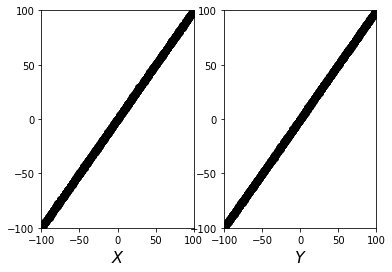

100%|██████████| 24/24 [00:00<00:00, 59.58it/s]

Epoch: 360 Train loss: 4.0346


Test loss: 3.9989


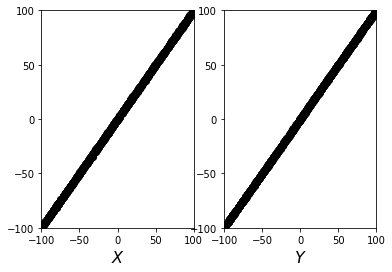

100%|██████████| 24/24 [00:00<00:00, 57.52it/s]

Epoch: 361 Train loss: 4.1145


Test loss: 3.9107


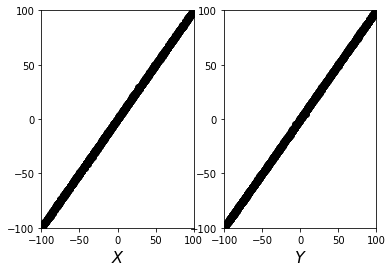

100%|██████████| 24/24 [00:00<00:00, 62.22it/s]

Epoch: 362 Train loss: 4.0968


Test loss: 4.0013


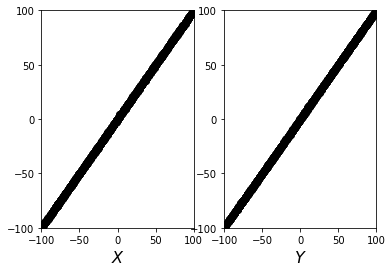

100%|██████████| 24/24 [00:00<00:00, 62.99it/s]

Epoch: 363 Train loss: 4.0624


Test loss: 3.9136


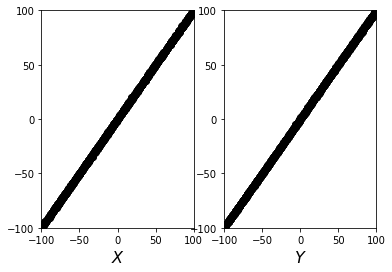

100%|██████████| 24/24 [00:00<00:00, 44.70it/s]


Epoch: 364 Train loss: 4.0150
Test loss: 4.0543


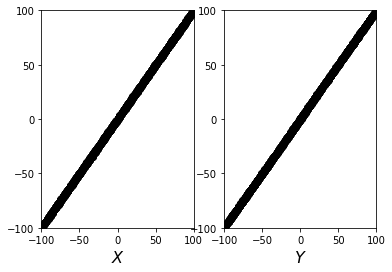

100%|██████████| 24/24 [00:00<00:00, 42.35it/s]

Epoch: 365 Train loss: 4.0247


Test loss: 4.1935


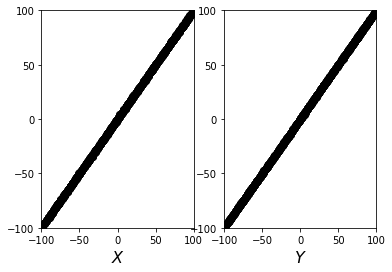

100%|██████████| 24/24 [00:00<00:00, 53.81it/s]

Epoch: 366 Train loss: 4.0552


Test loss: 4.1517


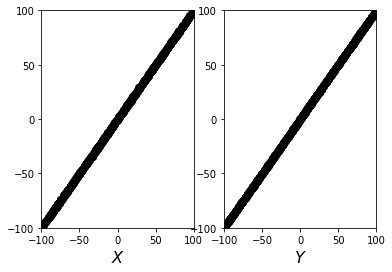

100%|██████████| 24/24 [00:00<00:00, 62.81it/s]

Epoch: 367 Train loss: 3.9917


Test loss: 3.8248


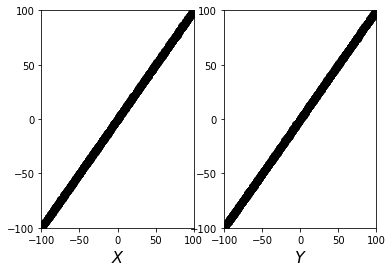

100%|██████████| 24/24 [00:00<00:00, 66.69it/s]

Epoch: 368 Train loss: 3.8731


Test loss: 3.8139


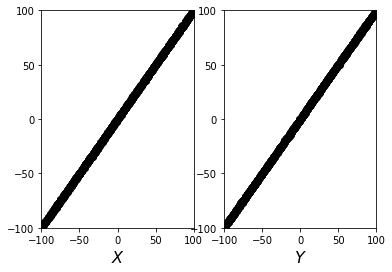

100%|██████████| 24/24 [00:00<00:00, 38.73it/s]

Epoch: 369 Train loss: 3.9762


Test loss: 3.8786


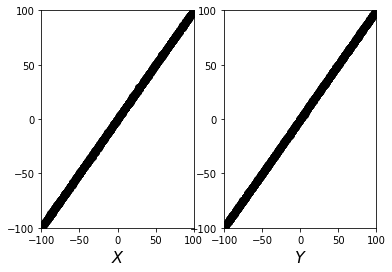

100%|██████████| 24/24 [00:00<00:00, 47.73it/s]

Epoch: 370 Train loss: 3.8796


Test loss: 3.8504


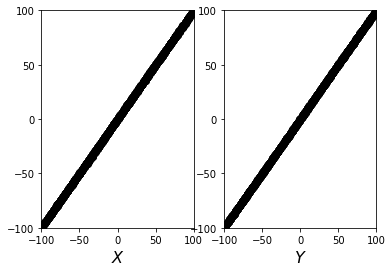

100%|██████████| 24/24 [00:00<00:00, 44.25it/s]

Epoch: 371 Train loss: 3.8830


Test loss: 3.7237


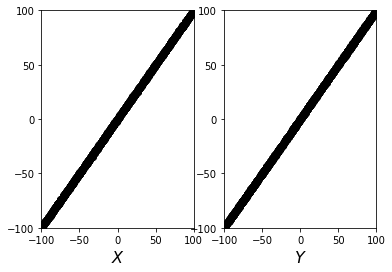

100%|██████████| 24/24 [00:00<00:00, 21.12it/s]

Epoch: 372 Train loss: 3.7843


Test loss: 3.8636


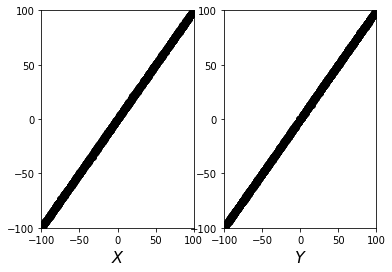

100%|██████████| 24/24 [00:00<00:00, 43.43it/s]

Epoch: 373 Train loss: 3.8042


Test loss: 3.6250


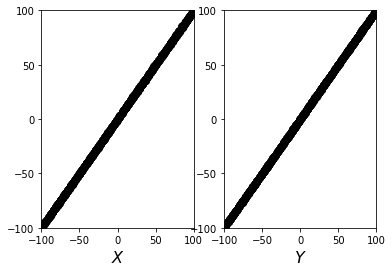

100%|██████████| 24/24 [00:00<00:00, 44.86it/s]

Epoch: 374 Train loss: 3.7049


Test loss: 3.7991


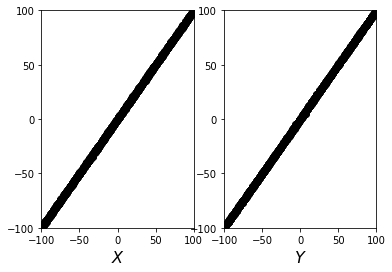

100%|██████████| 24/24 [00:00<00:00, 44.13it/s]

Epoch: 375 Train loss: 3.7929


Test loss: 3.6783


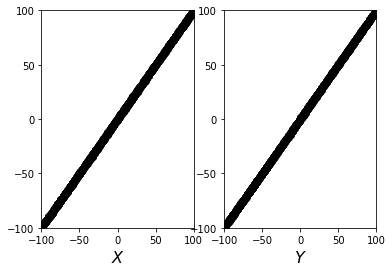

100%|██████████| 24/24 [00:00<00:00, 58.59it/s]


Epoch: 376 Train loss: 3.5828
Test loss: 3.8381


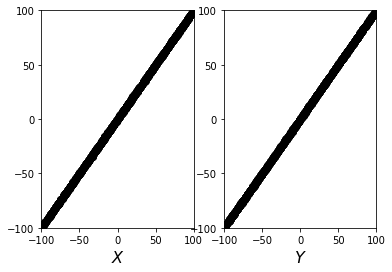

100%|██████████| 24/24 [00:00<00:00, 56.45it/s]

Epoch: 377 Train loss: 3.6919


Test loss: 3.7231


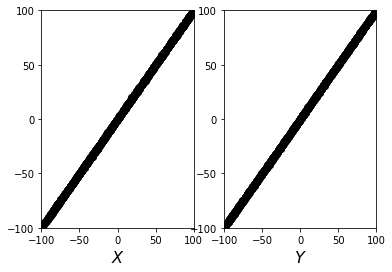

100%|██████████| 24/24 [00:00<00:00, 63.19it/s]

Epoch: 378 Train loss: 3.6815


Test loss: 3.6356


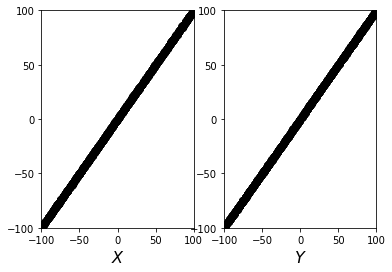

100%|██████████| 24/24 [00:00<00:00, 64.62it/s]

Epoch: 379 Train loss: 3.6179


Test loss: 3.8677


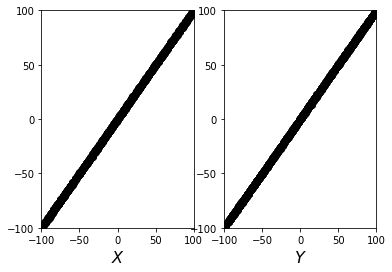

100%|██████████| 24/24 [00:00<00:00, 43.37it/s]

Epoch: 380 Train loss: 3.6460


Test loss: 3.6430


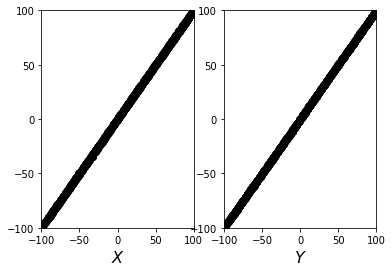

100%|██████████| 24/24 [00:00<00:00, 58.38it/s]

Epoch: 381 Train loss: 3.6134


Test loss: 3.6970


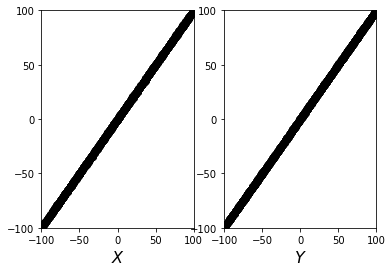

100%|██████████| 24/24 [00:00<00:00, 55.69it/s]

Epoch: 382 Train loss: 3.5539


Test loss: 3.4895


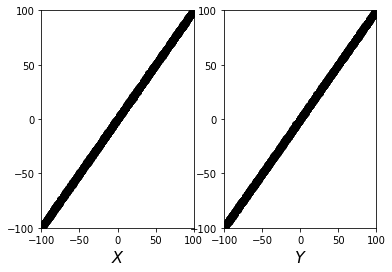

100%|██████████| 24/24 [00:00<00:00, 60.10it/s]

Epoch: 383 Train loss: 3.5989


Test loss: 3.6578


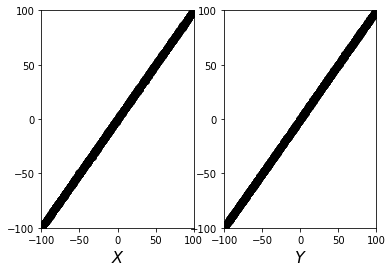

100%|██████████| 24/24 [00:00<00:00, 51.71it/s]

Epoch: 384 Train loss: 3.5767


Test loss: 3.6530


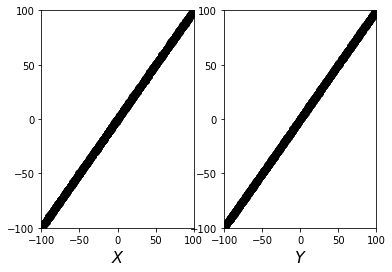

100%|██████████| 24/24 [00:00<00:00, 60.93it/s]

Epoch: 385 Train loss: 3.5414


Test loss: 3.4657


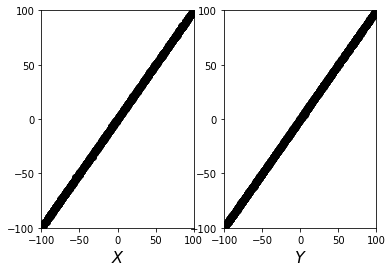

100%|██████████| 24/24 [00:00<00:00, 54.89it/s]

Epoch: 386 Train loss: 3.5004


Test loss: 3.5796


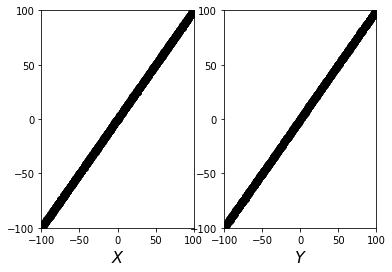

100%|██████████| 24/24 [00:00<00:00, 42.36it/s]

Epoch: 387 Train loss: 3.5686


Test loss: 3.4315


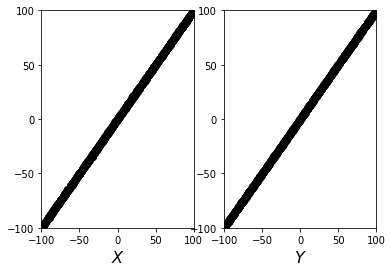

100%|██████████| 24/24 [00:00<00:00, 51.14it/s]

Epoch: 388 Train loss: 3.4762


Test loss: 3.4963


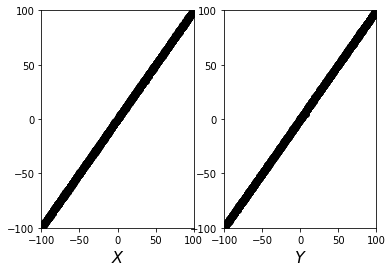

100%|██████████| 24/24 [00:00<00:00, 52.86it/s]

Epoch: 389 Train loss: 3.4622


Test loss: 3.6498


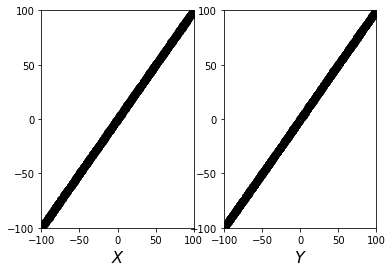

100%|██████████| 24/24 [00:00<00:00, 59.73it/s]


Epoch: 390 Train loss: 3.5236
Test loss: 3.5647


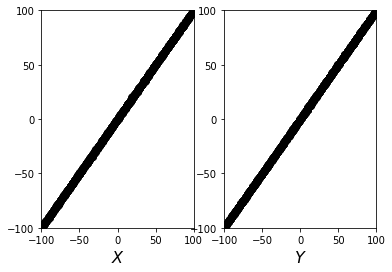

100%|██████████| 24/24 [00:00<00:00, 57.44it/s]

Epoch: 391 Train loss: 3.5245


Test loss: 3.5342


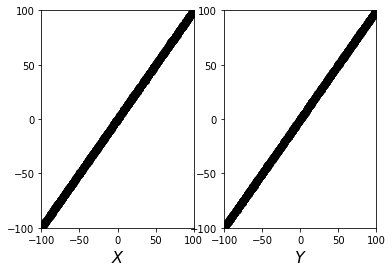

100%|██████████| 24/24 [00:00<00:00, 63.23it/s]

Epoch: 392 Train loss: 3.5976


Test loss: 3.6599


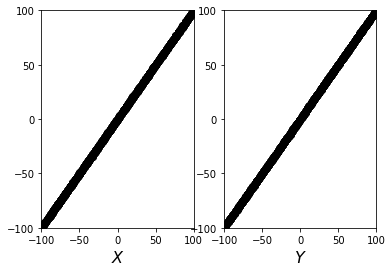

100%|██████████| 24/24 [00:00<00:00, 54.15it/s]

Epoch: 393 Train loss: 3.5875


Test loss: 3.4082


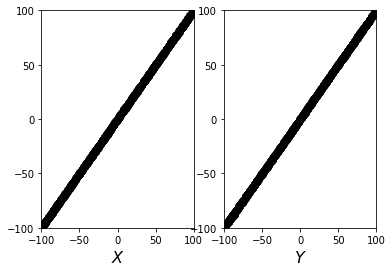

100%|██████████| 24/24 [00:01<00:00, 20.70it/s]

Epoch: 394 Train loss: 3.3936


Test loss: 3.3416


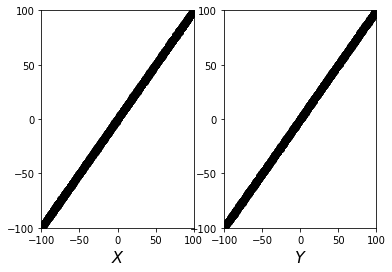

100%|██████████| 24/24 [00:00<00:00, 61.49it/s]

Epoch: 395 Train loss: 3.4558


Test loss: 3.4716


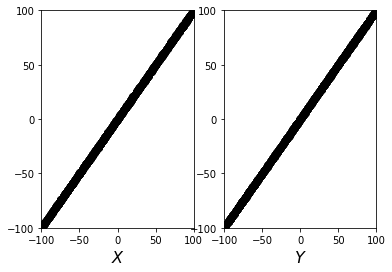

100%|██████████| 24/24 [00:00<00:00, 68.35it/s]

Epoch: 396 Train loss: 3.4434


Test loss: 3.3730


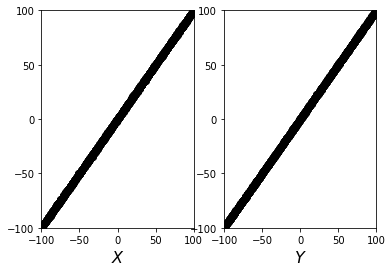

100%|██████████| 24/24 [00:00<00:00, 58.55it/s]

Epoch: 397 Train loss: 3.3844


Test loss: 3.3252


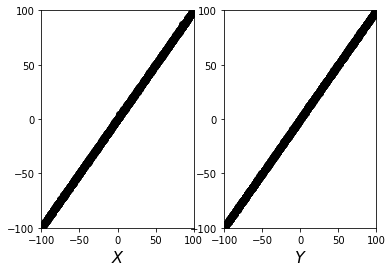

100%|██████████| 24/24 [00:00<00:00, 63.84it/s]

Epoch: 398 Train loss: 3.5680


Test loss: 3.8754


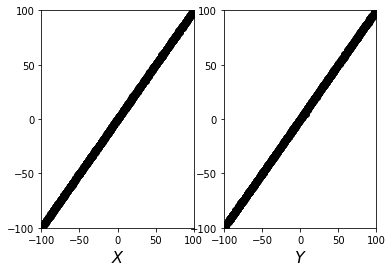

100%|██████████| 24/24 [00:00<00:00, 42.71it/s]

Epoch: 399 Train loss: 3.5264


Test loss: 3.5889


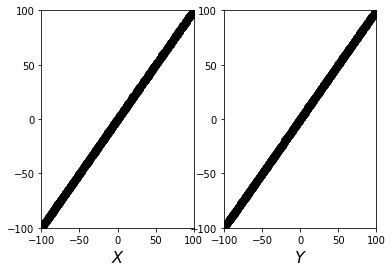

100%|██████████| 24/24 [00:00<00:00, 46.77it/s]

Epoch: 400 Train loss: 3.4970


Test loss: 3.5755


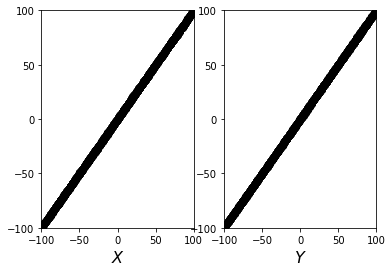

In [102]:
writer = SummaryWriter()

plot_number = 1

s_sample = 0.5 * torch.randn(64, s_dim).to(device)
c_sample = torch.eye(10)[[plot_number]*64].to(device)

# _o, _c = iter(test_loader).next()
# _o = _o.to(device)
# _c = torch.eye(10)[_c].to(device)


for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    
#     recon = plot_reconstrunction(_o[:8], _c[:8])
#     sample = plot_image_from_latent(s_sample, c_sample)
#     recon_changing_c = plot_reconstrunction_changing_c(_o[:8], _c[:8])

    writer.add_scalar('train_loss', train_loss.item(), epoch)
    writer.add_scalar('test_loss', test_loss.item(), epoch)
    
    #for plot
    history["train_loss"].append(train_loss.item())
    history["test_loss"].append(test_loss.item())

    _s = q.sample({"o": data["o"].to(device), "c": data["c"].to(device)}, return_all=False)
    ax = plt.subplot(1, 2, 1)
    tru = plt.scatter(data["s"][:,0],_s["s"][:,0],color='black',marker='o',edgecolors="black")
    plt.xticks(np.arange(min_data,max_data+grid_inter,grid_inter))
    plt.yticks(np.arange(min_data,max_data+grid_inter,grid_inter))
    ax.set_xlim([min_data,max_data])
    ax.set_ylim([min_data,max_data])
    #plt.ylabel('$s$', fontsize=16)
    plt.xlabel('$X$', fontsize=16)
    
    ay = plt.subplot(1, 2, 2)
    sam = plt.scatter(data["s"][:,1],_s["s"][:,1],color='black',marker='o',edgecolors="black")
    plt.xticks(np.arange(min_data,max_data+grid_inter,grid_inter))
    plt.yticks(np.arange(min_data,max_data+grid_inter,grid_inter))
    ay.set_xlim([min_data,max_data])
    ay.set_ylim([min_data,max_data])
    plt.xlabel('$Y$', fontsize=16)
    ims.append([tru]+[sam])
    
    x = np.linspace(0,100,1)  # xの値域(0, 1, 2, 3)
    y = x               # 直線の式
    plt.plot(x,y,"r-")      # 直線を引く
    plt.show()
    

#     writer.add_image('Image_from_latent', sample, epoch)
#     writer.add_image('Image_reconstrunction', recon, epoch)
#     writer.add_image('Image_reconstrunction_change_c', recon_changing_c, epoch)
    
writer.close()

In [103]:
# #animation
# def iinit():    
#     return (ims[0])
# # animation function: this is called sequentially
# def animate(i):
#   return (ims[i])

# #plot gif
# fig = plt.figure()
# plt.legend(['True','Result'], loc='upper left', fontsize=16)
# ani = animation.ArtistAnimation(fig, ims)
# anim = animation.FuncAnimation(fig, animate, init_func=iinit, frames=epochs, interval=100, blit=True)
# plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
# HTML(ani.to_html5_video())
# rc('animation', html='jshtml')
# anim

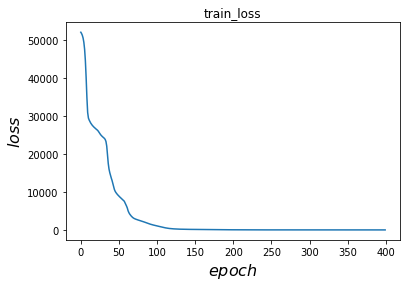

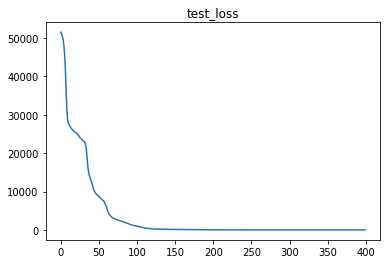

In [104]:
#plot loss    
plt.ylabel('$loss$', fontsize=16)
plt.xlabel('$epoch$', fontsize=16)
plt.title("train_loss")
plt.plot(range(epochs), history["train_loss"])
plt.show()
plt.title("test_loss")
plt.plot(range(epochs), history["test_loss"])
plt.show()

In [111]:
import csv
test_sample_num = 3000
test_sigma=torch.Tensor([0.5,0.5]*test_sample_num).view(test_sample_num,2)

with open('usplus1.csv','w') as f:
    for x in [-5.0,0.0,5.0]:
        for y in [-5.0,0.0,5.0]:
            data=unique_datagenerator(test_sample_num,test_sigma,x,y)
            _s = q.sample({"o": data["o"].to(device), "c": data["c"].to(device),"st1":data["st1"].to(device),"u":data["u"]}, return_all=False)
            lossx=0
            lossy=0
            _ss=_s["s"]
            for i in range(0,test_sample_num-1,1):
                lossx+=np.square(data["s"][i][0].numpy()-_ss[i][0].numpy())
                lossy+=np.square(data["s"][i][1].numpy()-_ss[i][1].numpy())
            print(lossx/test_sample_num)
            print(lossy/test_sample_num)
            writer = csv.writer(f, lineterminator='\n')
            writer.writerows([[ lossx/test_sample_num, lossy/test_sample_num ]])
            
            

tensor([[ -8.9238, -88.3120],
        [ 48.2083,  72.6032],
        [-75.3164,  52.1015],
        ...,
        [-78.2710, -95.0012],
        [-87.0534, -24.9367],
        [-37.3280, -22.3124]])
tensor([[-5., -5.],
        [-5., -5.],
        [-5., -5.],
        ...,
        [-5., -5.],
        [-5., -5.],
        [-5., -5.]])
tensor([[ -13.9238,  -93.3120],
        [  43.2083,   67.6032],
        [ -80.3164,   47.1015],
        ...,
        [ -83.2710, -100.0012],
        [ -92.0534,  -29.9367],
        [ -42.3280,  -27.3124]])
0.251678963330016
0.20722167294126667
tensor([[  4.7318,   0.4849],
        [-79.9917, -35.1411],
        [  3.1271,  76.0589],
        ...,
        [ 73.6303, -76.0772],
        [ 44.8307,  24.5583],
        [ 18.7479, -55.4509]])
tensor([[-5.,  0.],
        [-5.,  0.],
        [-5.,  0.],
        ...,
        [-5.,  0.],
        [-5.,  0.],
        [-5.,  0.]])
tensor([[ -0.2682,   0.4849],
        [-84.9917, -35.1411],
        [ -1.8729,  76.0589],
        ..

In [105]:
#u_tでの挙動をみるためのテスト
data=unique_datagenerator(sample_num,ssigma,5.0,-5.0)
_s = q.sample({"o": data["o"].to(device), "c": data["c"].to(device)}, return_all=False)
_o= p.sample({"s": _s["s"].to(device)}, return_all=False)

tensor([[ 19.0115, -14.7967],
        [-41.8537, -42.7576],
        [-49.0408,  26.0688],
        ...,
        [ 89.9367,  69.3877],
        [ 99.8322, -56.9356],
        [ -5.4466, -56.4003]])
tensor([[ 5., -5.],
        [ 5., -5.],
        [ 5., -5.],
        ...,
        [ 5., -5.],
        [ 5., -5.],
        [ 5., -5.]])
tensor([[ 24.0115, -19.7967],
        [-36.8537, -47.7576],
        [-44.0408,  21.0688],
        ...,
        [ 94.9367,  64.3877],
        [104.8322, -61.9356],
        [ -0.4466, -61.4003]])


In [1]:
#u_tでの挙動を見るためのテストの描画
plt.subplot(1, 2, 1)
tru = plt.scatter(data["s"][:,0],_s["s"][:,0],color='blue',marker='o',edgecolors="blue")
plt.xticks(np.arange(min_data,max_data,grid_inter))
plt.yticks(np.arange(min_data,max_data,grid_inter))
plt.ylabel('$st　from　q$', fontsize=16)
plt.xlabel('$true　s_{tx}$', fontsize=16)

plt.subplot(1, 2, 2)
sam = plt.scatter(data["s"][:,1],_s["s"][:,1],color='red',marker='x',edgecolors="red")
plt.xticks(np.arange(min_data,max_data,grid_inter))
plt.yticks(np.arange(min_data,max_data,grid_inter))
plt.xlabel('$true　s_{ty}$', fontsize=16)
ims.append([tru]+[sam])
plt.grid(which='minor',color='black',linestyle='-')
plt.show()

NameError: name 'plt' is not defined

In [108]:
print(data["s"][:,0])
print(_ss[:,0])

tensor([ -3.5532,  96.2479,  87.0042,  ...,  24.4987, -10.5905,   9.2074])
tensor([ -3.2339,  95.6933,  87.0640,  ...,  25.1846, -10.0615,   8.7942])


{'s': tensor([[ -3.2339,  97.0158],
        [ 95.6933,  10.8866],
        [ 87.0640, -76.7599],
        ...,
        [ 25.1846, -76.2932],
        [-10.0615, -75.5341],
        [  8.7942, -83.4547]])}
tensor([[ 2.3796e+01, -2.0234e+01],
        [-3.6510e+01, -4.7219e+01],
        [-4.4419e+01,  2.1057e+01],
        ...,
        [ 9.4203e+01,  6.5320e+01],
        [ 1.0559e+02, -6.1976e+01],
        [-9.9104e-02, -6.1124e+01]])
tensor([[ -3.5532,  98.1028],
        [ 96.2479,  11.1860],
        [ 87.0042, -77.1656],
        ...,
        [ 24.4987, -76.2830],
        [-10.5905, -75.5190],
        [  9.2074, -82.7555]])


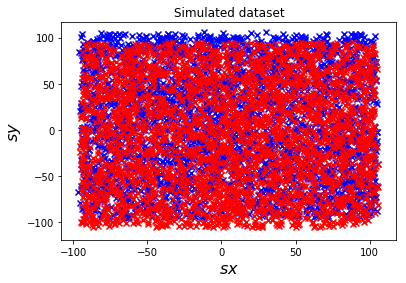

In [109]:
print(_s)
print(_o["o"])
print(data["s"])

# plt.scatter(sample_o[:,0],sample_o[:,1],color='blue',marker='o',edgecolors="blue")
plt.scatter(data["o"][:,0],data["o"][:,1],color='blue',marker='x',edgecolors="red")
plt.scatter(_o["o"][:,0],_o["o"][:,1],color='red',marker='x',edgecolors="red")
plt.xlabel('$sx$', fontsize=16)
plt.ylabel('$sy$', fontsize=16)
plt.title("Simulated dataset")
plt.show()

In [110]:
loss=0
_ss=_s["s"]
for i in range(0,sample_num-1,1):
    loss+=np.abs(data["s"][i].numpy()-_ss[i])
print(loss/sample_num)

TypeError: rsub() received an invalid combination of arguments - got (Tensor, numpy.ndarray), but expected one of:
 * (Tensor input, Tensor other, Number alpha)
 * (Tensor input, Number other, Number alpha)


In [ ]:
max_data=10#max_data
min_data=-4#min_data
grid_inter=1

plot_data=test_data

_s = q.sample({"o": plot_data["o"].to(device), "c": plot_data["c"].to(device)}, return_all=False)

#show sample points
plt.scatter(plot_data["s"][:,0],plot_data["s"][:,1],color='blue',marker='o',edgecolors="blue")
plt.scatter(_s["s"][:,0],_s["s"][:,1],color='red',marker='x',edgecolors="red")
plt.xlabel('$sx$', fontsize=16)
plt.ylabel('$sy$', fontsize=16)
plt.title("Simulated dataset")
plt.show()

plt.subplot(1, 2, 1)
plt.scatter(plot_data["s"][:,0],plot_data["s"][:,1],color='blue',marker='o',edgecolors="blue")
plt.xticks(np.arange(min_data-1,max_data+1,grid_inter))
plt.subplot(1,2,2)
plt.scatter(_s["s"][:,0],_s["s"][:,1],color='red',marker='x',edgecolors="red")
plt.xticks(np.arange(min_data-1,max_data+1,grid_inter))
plt.show()
